# 2: Explicit ODE Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from TestProblems import prey_predator_model, van_der_pol_model, CSTR_3state_model, CSTR_1state_model
from Solvers import ExplicitEulerFixedSteps, ExplicitEulerAdaptiveStep, ImplicitEulerFixedStep, ImplicitEulerAdaptiveStep, rk4, ExplicitRungeKuttaSolver, ExplicitRungeKuttaSolverAdaptive, dormand_prince_45, ESDIRK

## Stability plot for the Explicit Euler method

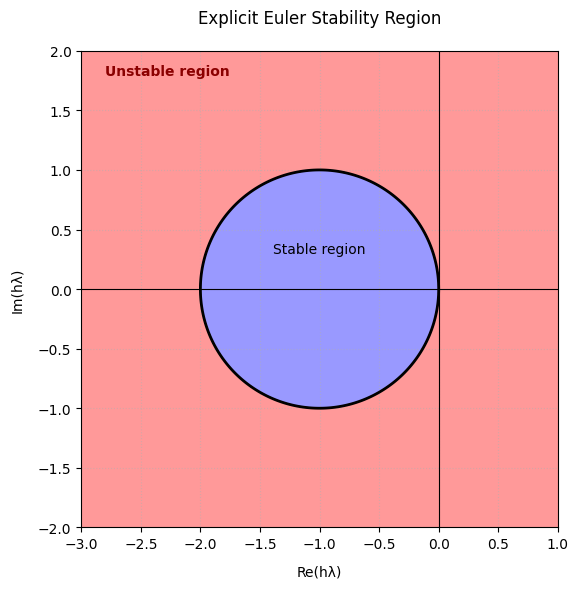

In [2]:
# Create grid in the complex plane
x = np.linspace(-3, 1, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Amplification factor for Explicit Euler: R(z) = 1 + z
R = 1 + Z
R_mag = np.abs(R)

# Create figure
plt.figure(figsize=(7, 6))

# Plot stable (red) and unstable (blue) regions
plt.contourf(X, Y, R_mag <= 1, levels=[0, 0.5, 1.5], 
             colors=['red', 'blue'], alpha=0.4)

# Draw stability boundary (|R(z)| = 1)
plt.contour(X, Y, R_mag, levels=[1], colors='black', linewidths=2)

# Draw unit circle (visual reference)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta)-1, np.sin(theta), 'k--', lw=1, alpha=0.7)

# Add axes and formatting
plt.axhline(0, color='black', lw=0.8)
plt.axvline(0, color='black', lw=0.8)
plt.title("Explicit Euler Stability Region", pad=20)
plt.xlabel("Re(hλ)", labelpad=10)
plt.ylabel("Im(hλ)", labelpad=10)
plt.gca().set_aspect('equal')

# Add legend and annotations
plt.text(-2.8, 1.8, "Unstable region", color='darkred', weight='bold')
plt.text(-1, 0.3, "Stable region", ha='center', color='black')

plt.grid(True, linestyle=':', alpha=0.5)
plt.xlim(-3, 1)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

## Test algorithms on test problems

In [3]:
def abs_error(y, y_exact):
    return np.abs(y - y_exact)/np.abs(y_exact)

In [11]:
def compare_solvers(model_func, t_span, x0, params=None, 
                   fixed_step_sizes=[0.1, 0.01], 
                   tolerances = [1e-3, 1e-6],
                   h0 = 0.1,
                   reference_solver='RK45', 
                   figsize=(16, 12), 
                   model_name="Model",
                   reference_solver_name="ode45",
                   tight_layout=True,
                   fixed_steps=False,
                   adaptive_steps=False,
                   steptype = "fixed",
                   explicit = False,
                   implicit = False,
                   euler = False,
                   rk45 = False,
                   dopri = False, 
                   esdirk = False,
                   cstr = False):
    # Create figure

    if implicit:
        methodname = "Implicit"
    else:
        methodname = "Explicit"

    if euler:
        overall_methodname = "Euler"
    if rk45:
        overall_methodname = "Classic Runge-Kutta "
    if dopri:
        overall_methodname = "Dormand-Prince 4(5)"
    if esdirk:
        overall_methodname = "ESDIRK 23" 
    
    plt.figure(figsize=figsize)
    plt.suptitle(f"{model_name}: Comparison of {methodname} {overall_methodname} with {steptype} step size vs {reference_solver_name}", fontsize=16)
    
    # Dictionary to store results
    results = {}

        
    # Compare for each step size
    if fixed_steps:
        for i, dt in enumerate(fixed_step_sizes):
            N = int((t_span[1] - t_span[0]) / dt) + 1
            # Determine number of points based on step size
            


            f, J = model_func(*params)
            
            if explicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                            t_eval=np.linspace(t_span[0], t_span[1], N))
                if euler:
                    t, y = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)
                if rk45:
                    solver = rk4()
                    t,y = ExplicitRungeKuttaSolver(f, t_span, x0, dt, solver)
            if implicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                            t_eval=np.linspace(t_span[0], t_span[1], N,), jac = J)
                t, y = ImplicitEulerFixedStep(f, J, t_span[0], t_span[1], N, x0)

            if not rk45:
                # Calculate absolute error (assuming you have this function defined)
                error = abs_error(y[:,1:], ref_sol.y)
                # Calculate average error
            else:
                error = abs_error(y, ref_sol.y)
            
            avg_error = (error[0,:] + error[1,:])/2


            
            # Store results
            results[dt] = {
                'ref_sol': ref_sol,
                't': t,
                'y': y,
                'error': error,
                'avg_error': avg_error
            }
            
            # Plot phase space comparison
            plt.subplot(3, 1, i+1)
            plt.plot(y[0,:], y[1,:], label=f'{methodname} {overall_methodname}',linestyle = '--', color='blue')
            plt.plot(ref_sol.y[0,:], ref_sol.y[1,:], label=reference_solver_name, color='red')
            plt.legend()
            plt.title(f"Comparison of {methodname} {overall_methodname} with {steptype} step size and {reference_solver_name} (dt = {dt})")
            plt.xlabel("x1")
            plt.ylabel("x2")

            # Plot error comparison
        plt.subplot(3, 1, 3)
        for dt in fixed_step_sizes:
            res = results[dt]
            if not rk45:
                plt.plot(res['t'][1:], res['avg_error'], label=f'dt = {dt}')
            else:
                plt.plot(res['t'], res['avg_error'], label=f'dt = {dt}')
                
        
        plt.yscale('log')
        plt.title(f"{model_name}: Relative Error Comparison for different step sizes")
        plt.xlabel("Time")
        plt.ylabel("Average Relative Error")
        plt.legend()
        plt.grid(True)
        if tight_layout:
            plt.tight_layout()
        plt.show()
        
    if adaptive_steps:
        N = int((t_span[1] - t_span[0]) / h0) + 1
        for idx, tolerance in enumerate(tolerances):

            f, J = model_func(*params)
            f_esdirk, J_esdirk = model_func(*params, esdirk)
        
            if explicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                t_eval=np.linspace(t_span[0], t_span[1], N))
                if euler:   
                    t, y, h, r = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, tolerance, tolerance)
                if rk4:
                    solver = rk4()
                    t, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
                if dopri:
                    solver = dormand_prince_45()
                    t, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
            if implicit:
                if esdirk:
                    ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                    t_eval=np.linspace(t_span[0], t_span[1], N), jac = J)
                    Method = "ESDIRK23"

                    t, y, g, _, stats = ESDIRK(f_esdirk, J_esdirk, t_span, x0, h0, tolerance, tolerance, Method=Method)
                    h = np.array(stats['h'])
                    r = np.array(stats['r'])
                else:
                    ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                    t_eval=np.linspace(t_span[0], t_span[1], N), jac = J)
                    t, y, h, r = ImplicitEulerAdaptiveStep(f, J, t_span, x0, h0, tolerance, tolerance)
        
            # Store results
            results[tolerance] = {
                'ref_sol': ref_sol,
                't': t,
                'y': y,
                'h': h,
                'r': r
            }
            
            # Plot phase space comparison
            plt.subplot(3, 1, idx+1)
            plt.plot(y[:,0], y[:,1], label=f'{methodname} {overall_methodname}', linestyle = '--', color='blue')
            plt.plot(ref_sol.y[0,:], ref_sol.y[1,:], label=f"{reference_solver_name}, dt = {h0}", color='red')
            plt.legend()
            plt.title(f"Comparison of {methodname} {overall_methodname} with {steptype} step size and {reference_solver_name} (tolerance = {tolerance})")
            plt.xlabel("x1")
            plt.ylabel("x2")


        # Plot adaptive step sizes
        plt.subplot(3, 2, 3)
        for tolerance in tolerances:
            res = results[tolerance]
            diff_shape = abs(res['h'].shape[0] - res['t'].shape[0])
            if diff_shape > 0:
                plt.plot(res['t'], res['h'][:-diff_shape], label=f'tolerance = {tolerance}')
            elif diff_shape < 0:
                plt.plot(res['t'][:-diff_shape], res['h'], label=f'tolerance = {tolerance}')
            else:
                plt.plot(res['t'], res['h'], label=f'tolerance = {tolerance}')
        plt.yscale('log')
        plt.title(f"{model_name}: Adaptive Step Sizes")
        plt.xlabel("Time")
        plt.ylabel("Adaptive Step Size")
        plt.legend()
        plt.grid(True)
        plt.subplot(3,3,2)
        for tolerance in tolerances:
            res = results[tolerance]
            diff_shape = abs(res['r'].shape[0] - res['t'].shape[0])
            if diff_shape > 0:
                plt.plot(res['t'], res['r'][:-diff_shape], label=f'tolerance = {tolerance}')
            elif diff_shape < 0:
                plt.plot(res['t'][:-diff_shape], res['r'], label=f'tolerance = {tolerance}')
            else:
                plt.plot(res['t'], res['r'], label=f'tolerance = {tolerance}')

        plt.title(f"{model_name}: Estimated Error Ratio")
        plt.xlabel("Time")
        plt.ylabel("Estimated Error Ratio")
        plt.legend()
        plt.grid(True)


        plt.grid(True)
        if tight_layout:
            plt.tight_layout()
        plt.show()
        
    return results



In [ ]:
def compare_solvers_cstr(model_func, t_span,  
                   fixed_step_sizes=[0.1, 0.01], 
                   tolerances = [1e-3, 1e-6],
                   h0 = 0.1,
                   reference_solver='BDF', 
                   figsize=(16, 12), 
                   model_name="CSTR 1 state",
                   reference_solver_name="ode15s",
                   fixed_steps=False,
                   adaptive_steps=False,
                   steptype = "fixed",
                   explicit = False,
                   implicit = False,
                   euler = False,
                   rk45 = False,
                   dopri = False, 
                   esdirk = False):
    # Create figure

    if implicit:
        methodname = "Implicit"
    else:
        methodname = "Explicit"

    if euler:
        overall_methodname = "Euler"
    if rk45:
        overall_methodname = "Classic Runge-Kutta "
    if dopri:
        overall_methodname = "Dormand-Prince 4(5)"
    if esdirk:
        overall_methodname = "ESDIRK 23" 

    min = 60
    F = [0.7/min,0.6/min,0.5/min,0.4/min,0.3/min,0.2/min,0.3/min,0.4/min,0.5/min,0.6/min,0.7/min,0.7/min,0.2/min,0.2/min,0.7/min,0.7/min]

    #F = np.arange(0.1, 0.7, 0.1)/min

    t = np.array([None])
    Tf = np.array([None])

    # Storage for results
    #steady_states = np.array([[],[]])
    #flow_rates = np.array([[],[]])  

    
    t_ref = np.array([None])
    Tf_ref = np.array([None])

    # Storage for results
    #steady_states_ref = np.array([[], []])
    #flow_rates_ref = np.array([[],[]])  

    # Initial conditions
    Tin = 273.65
    CA_in = 2.4/2
    CB_in = 1.6/2

    x0 = np.array([Tin])
    x0_ref = np.array([Tin])

    R = np.array([None])
    H = np.array([None])

    N = 30

    plt.figure(figsize=figsize)
    plt.suptitle(f"{model_name}: Comparison of {methodname} {overall_methodname} with {steptype} step size vs {reference_solver_name}", fontsize=16)
    
    # Dictionary to store results
    results = {}

        
    # Compare for each step size
    if fixed_steps:
        for i, dt in enumerate(fixed_step_sizes):
            for idx, f in enumerate(F):
            # Determine number of points based on step size
                params = [f,0.105,CA_in,CB_in,Tin]

                f, J = model_func(params)
                
                if explicit:
                    ref_sol = solve_ivp(f, t_span, x0_ref, method=reference_solver, 
                                t_eval=np.linspace(t_span[0], t_span[1], N))
                    if euler:
                        t_sol, y = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)
                    if rk45:
                        solver = rk4()
                        t_sol,y = ExplicitRungeKuttaSolver(f, t_span, x0, dt, solver)
                if implicit:
                    ref_sol = solve_ivp(f, t_span, x0_ref, method=reference_solver, 
                                t_eval=np.linspace(t_span[0], t_span[1], N,), jac = J)
                    t_sol, y = ImplicitEulerFixedStep(f, J, t_span[0], t_span[1], N, x0)

                T_ss_ref = ref_sol.y[0][-1]
                T_ss = y[0][-1]

                x0 = np.array([T_ss])
                x0_ref = np.array([T_ss_ref])
                Tf = np.concatenate([Tf, y.ravel()-Tin])
                Tf_ref = np.concatenate([Tf_ref, ref_sol.y[0]-Tin])



                #steady_states = np.hstacks([steady_states, x0])   
                #steady_states_ref = np.hstacks([steady_states_ref, x0_ref])
                #flow_rates = np.append([flow_rates, F[idx]*min*1000])
                #flow_rates_ref = np.append([flow_rates_ref, F[idx]*min*1000])

                t = np.concatenate([t, (t_sol+(idx)*t_span[1])/min])
                t_ref = np.concatenate([t_ref, (ref_sol.t+(idx)*t_span[1])/min])

            
            # Calculate absolute error (assuming you have this function defined)
            #error = abs_error(Tf, Tf_ref)
                 # Calculate average error
            results[dt] ={
                'ref_sol': Tf_ref[1:],
                'sol': Tf[1:],
                #'error': error,
                't_ref': t_ref[1:],
                't_sol': t[1:]
            }             
            # Plot phase space comparison
            plt.subplot(3, 1, i+1)
            plt.plot(t, Tf, label=f'{methodname} {overall_methodname}',linestyle = '--', color='blue')
            plt.plot(t_ref, Tf_ref, label=reference_solver_name, color='red')
            plt.legend()
            plt.title(f"Comparison of {methodname} {overall_methodname} with {steptype} step size and {reference_solver_name} (dt = {dt})")
            plt.xlabel("Time")
            plt.ylabel("Temperature")

            # Plot error comparison
        plt.subplot(3, 1, 3)
        for dt in fixed_step_sizes:
            res = results[dt]
            #plt.plot(res['t'][1:], res['error'], label=f'dt = {dt}')
                
        
        plt.yscale('log')
        plt.title(f"{model_name}: Relative Error Comparison for different step sizes")
        plt.xlabel("Time")
        plt.ylabel("Average Relative Error")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        
    if adaptive_steps:
        # Calculate number of points based on 
        for idx, tolerance in enumerate(tolerances):
            for i, f in enumerate(F):
                params = [f,0.105,CA_in,CB_in,Tin]
                f, J = model_func(params)
                f_esdirk, J_esdirk = model_func(params, esdirk)
            
                if explicit:
                    ref_sol = solve_ivp(f, t_span, x0_ref, method=reference_solver, 
                    t_eval=np.linspace(t_span[0], t_span[1], N), jac = J)
                    if euler:   
                        t_sol, y, h, r = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, tolerance, tolerance)
                    if rk4:
                        solver = rk4()
                        t_sol, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
                    if dopri:
                        solver = dormand_prince_45()
                        t_sol, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
                if implicit:
                    if esdirk:
                        ref_sol = solve_ivp(f, t_span, x0_ref, method=reference_solver, 
                        t_eval=np.linspace(t_span[0], t_span[1], N), jac = J)
                        Method = "ESDIRK23"


                        t_sol, y, g, _, stats = ESDIRK(f_esdirk, J_esdirk, t_span, x0, h0, tolerance, tolerance, Method=Method)
                        h = np.array(stats['h'])
                        r = np.array(stats['r'])
                    else:
                        ref_sol = solve_ivp(f, t_span, x0_ref, method=reference_solver, 
                        t_eval=np.linspace(t_span[0], t_span[1], N), jac = J)
                        t_sol, y, h, r = ImplicitEulerAdaptiveStep(f, J, t_span, x0, h0, tolerance, tolerance)
            

                T_ss_ref = ref_sol.y[0][-1]
                T_ss = y[0][-1]

                x0 = np.array([T_ss])
                x0_ref = np.array([T_ss_ref])
                Tf = np.concatenate([Tf, y.ravel()-Tin])
                Tf_ref = np.concatenate([Tf_ref, ref_sol.y[0]-Tin])
                t = np.concatenate([t, (t_sol+(i)*t_span[1])/min])
                t_ref = np.concatenate([t_ref, (ref_sol.t+(i)*t_span[1])/min])
                R = np.concatenate([R, r])
                H = np.concatenate([H, h])


            # Store results
            results[tolerance] = {
                'ref_sol': Tf_ref[1:],
                'sol': Tf[1:],
                'r': R,
                't_ref': t_ref[1:],
                't_sol': t[1:],
                'h': H
            }
            
            # Plot phase space comparison
            plt.subplot(3, 1, idx+1)
            plt.plot(t, Tf, label=f'{methodname} {overall_methodname}', linestyle = '--', color='blue')
            plt.plot(t_ref, Tf_ref, label=f"{reference_solver_name}, dt = {h0}", color='red')
            plt.legend()
            plt.title(f"Comparison of {methodname} {overall_methodname} with {steptype} step size and {reference_solver_name} (tolerance = {tolerance})")
            plt.xlabel("x1")
            plt.ylabel("x2")


        # Plot adaptive step sizes
        plt.subplot(3, 1, 3)
        for tolerance in tolerances:
            res = results[tolerance]
            diff_shape = abs(res['h'].shape[0] - res['t'].shape[0])
            if diff_shape > 0:
                plt.plot(res['t'], res['h'][:-diff_shape], label=f'tolerance = {tolerance}')
            elif diff_shape < 0:
                plt.plot(res['t'][:-diff_shape], res['h'], label=f'tolerance = {tolerance}')
            else:
                plt.plot(res['t'], res['h'], label=f'tolerance = {tolerance}')
        
        plt.yscale('log')
        plt.title(f"{model_name}: Adaptive Step Sizes")
        plt.xlabel("Time")
        plt.ylabel("Adaptive Step Size")
        plt.legend()
        plt.grid(True)

        plt.grid(True)

        plt.tight_layout()
        plt.show()
        
    return results



In [30]:
def compare_solvers(model_func, t_span, x0, params=None, 
                   fixed_step_sizes=[0.1, 0.01], 
                   tolerances=[1e-3, 1e-6],
                   h0=0.1,
                   reference_solver='RK45', 
                   figsize=(16, 16),  # Increased height for additional subplots
                   model_name="Model",
                   reference_solver_name="ode45",
                   tight_layout=True,
                   fixed_steps=False,
                   adaptive_steps=False,
                   steptype="fixed",
                   explicit=False,
                   implicit=False,
                   euler=False,
                   rk45=False,
                   dopri=False, 
                   esdirk=False,
                   cstr=False):
    
    # Method naming
    if implicit:
        methodname = "Implicit"
    else:
        methodname = "Explicit"

    if euler:
        overall_methodname = "Euler"
    if rk45:
        overall_methodname = "Classic Runge-Kutta"
    if dopri:
        overall_methodname = "Dormand-Prince 4(5)"
    if esdirk:
        overall_methodname = "ESDIRK 23" 
    
    # Dictionary to store results
    results = {}

    # Fixed step comparisons
    if fixed_steps:
        plt.figure(figsize=figsize)
        plt.suptitle(f"{model_name}: Comparison of {methodname} {overall_methodname} with {steptype} step size vs {reference_solver_name}", fontsize=16)
        
        for i, dt in enumerate(fixed_step_sizes):
            N = int((t_span[1] - t_span[0]) / dt) + 1
            f, J = model_func(*params)
            
            if explicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                            t_eval=np.linspace(t_span[0], t_span[1], N))
                if euler:
                    t, y = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)
                if rk45:
                    solver = rk4()
                    t, y = ExplicitRungeKuttaSolver(f, t_span, x0, dt, solver)
            if implicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                            t_eval=np.linspace(t_span[0], t_span[1], N), jac=J)
                t, y = ImplicitEulerFixedStep(f, J, t_span[0], t_span[1], N, x0)

            error = abs_error(y[:,1:], ref_sol.y) if not rk45 else abs_error(y, ref_sol.y)
            avg_error = (error[0,:] + error[1,:])/2
            
            results[dt] = {
                'ref_sol': ref_sol,
                't': t,
                'y': y,
                'error': error,
                'avg_error': avg_error
            }
            
            # Phase portrait
            plt.subplot(3, 1, i+1)
            plt.plot(y[0,:], y[1,:], '--', label=f'{methodname} {overall_methodname}', color='blue')
            plt.plot(ref_sol.y[0,:], ref_sol.y[1,:], label=reference_solver_name, color='red')
            plt.legend()
            plt.title(f"Phase Portrait (dt = {dt})")
            plt.xlabel("x1")
            plt.ylabel("x2")
            plt.grid(True)

        # Error comparison
        plt.subplot(3, 1, 3)
        for dt in fixed_step_sizes:
            res = results[dt]
            t_plot = res['t'][1:] if not rk45 else res['t']
            plt.plot(t_plot, res['avg_error'], label=f'dt = {dt}')
        
        plt.yscale('log')
        plt.title("Error Comparison")
        plt.xlabel("Time")
        plt.ylabel("Average Relative Error")
        plt.legend()
        plt.grid(True)
        
        if tight_layout:
            plt.tight_layout()
        plt.show()
        
    # Adaptive step comparisons
    if adaptive_steps:
        fig = plt.figure(figsize=figsize)
        plt.suptitle(f"{model_name}: Adaptive {methodname} {overall_methodname} vs {reference_solver_name}", fontsize=16)
        
        # Create grid for subplots (3 rows, 2 columns)
        gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])
        
        # Phase portraits (top two rows)
        ax1 = fig.add_subplot(gs[0, :])  # First row spans both columns
        ax2 = fig.add_subplot(gs[1, :])  # Second row spans both columns
        
        # Step size and error ratio plots (third row)
        ax3 = fig.add_subplot(gs[2, 0])  # Third row, first column (h)
        ax4 = fig.add_subplot(gs[2, 1])  # Third row, second column (r)
        
        N = int((t_span[1] - t_span[0]) / h0) + 1
        
        for idx, tolerance in enumerate(tolerances):
            f, J = model_func(*params)
            f_esdirk, J_esdirk = model_func(*params, esdirk)
            
            if explicit:
                ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                                  t_eval=np.linspace(t_span[0], t_span[1], N))
                if euler:   
                    t, y, h, r = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, tolerance, tolerance)
                if rk4:
                    solver = rk4()
                    t, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
                if dopri:
                    solver = dormand_prince_45()
                    t, y, h, r = ExplicitRungeKuttaSolverAdaptive(f, t_span, x0, h0, solver, tolerance, tolerance)
            if implicit:
                if esdirk:
                    ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                                      t_eval=np.linspace(t_span[0], t_span[1], N), jac=J)
                    Method = "ESDIRK23"
                    t, y, g, _, stats = ESDIRK(f_esdirk, J_esdirk, t_span, x0, h0, tolerance, tolerance, Method=Method)
                    h = np.array(stats['h'])
                    r = np.array(stats['r'])
                else:
                    ref_sol = solve_ivp(f, t_span, x0, method=reference_solver, 
                                      t_eval=np.linspace(t_span[0], t_span[1], N), jac=J)
                    t, y, h, r = ImplicitEulerAdaptiveStep(f, J, t_span, x0, h0, tolerance, tolerance)
            
            results[tolerance] = {
                'ref_sol': ref_sol,
                't': t,
                'y': y,
                'h': h[2:],
                'r': r[2:]
            }
            
        for idx, tolerance in enumerate(tolerances):
            res = results[tolerance]
            ax3.semilogy(res['h'],  label=f'tol={tolerance:.0e}')
            ax4.semilogy(res['r'],  label=f'tol={tolerance:.0e}')
            if idx == 0:
                # Plot phase portraits
                ax1.plot(y[:,0], y[:,1], '--', color='blue', 
                    label=f'{methodname} {overall_methodname} (tol={tolerance:.0e})')
                ax1.plot(ref_sol.y[0,:], ref_sol.y[1,:], color='red',
                    label=f'{reference_solver_name} (tol={tolerance:.0e})')
            else:
                # Plot phase portraits
                ax2.plot(y[:,0], y[:,1], '--', color='blue', 
                    label=f'{methodname} {overall_methodname} (tol={tolerance:.0e})')
                ax2.plot(ref_sol.y[0,:], ref_sol.y[1,:], color='red', 
                    label=f'{reference_solver_name} (tol={tolerance:.0e})')
            
            # Plot step sizes and error ratios

        
        # Configure phase portrait plots
        for ax, title in zip([ax1, ax2], ['Numerical Method', 'Reference Solver']):
            ax.set_title(f"Phase Portrait - {title}")
            ax.set_xlabel("x1")
            ax.set_ylabel("x2")
            ax.legend()
            ax.grid(True)
        
        # Configure step size and error ratio plots
        ax3.set_title("Adaptive Step Sizes")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Step Size (log scale)")
        ax3.legend()
        ax3.grid(True)
        
        ax4.set_title("Error Ratios")
        ax4.set_xlabel("Time")
        ax4.set_ylabel("Error Ratio (log scale)")
        ax4.legend()
        ax4.grid(True)
        
        if tight_layout:
            plt.tight_layout()
        plt.show()
        
    return results

/var/folders/v_/bb7dt9w12158g8xjfpl9dzfc0000gn/T/ipykernel_31937/1278937448.py:227: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


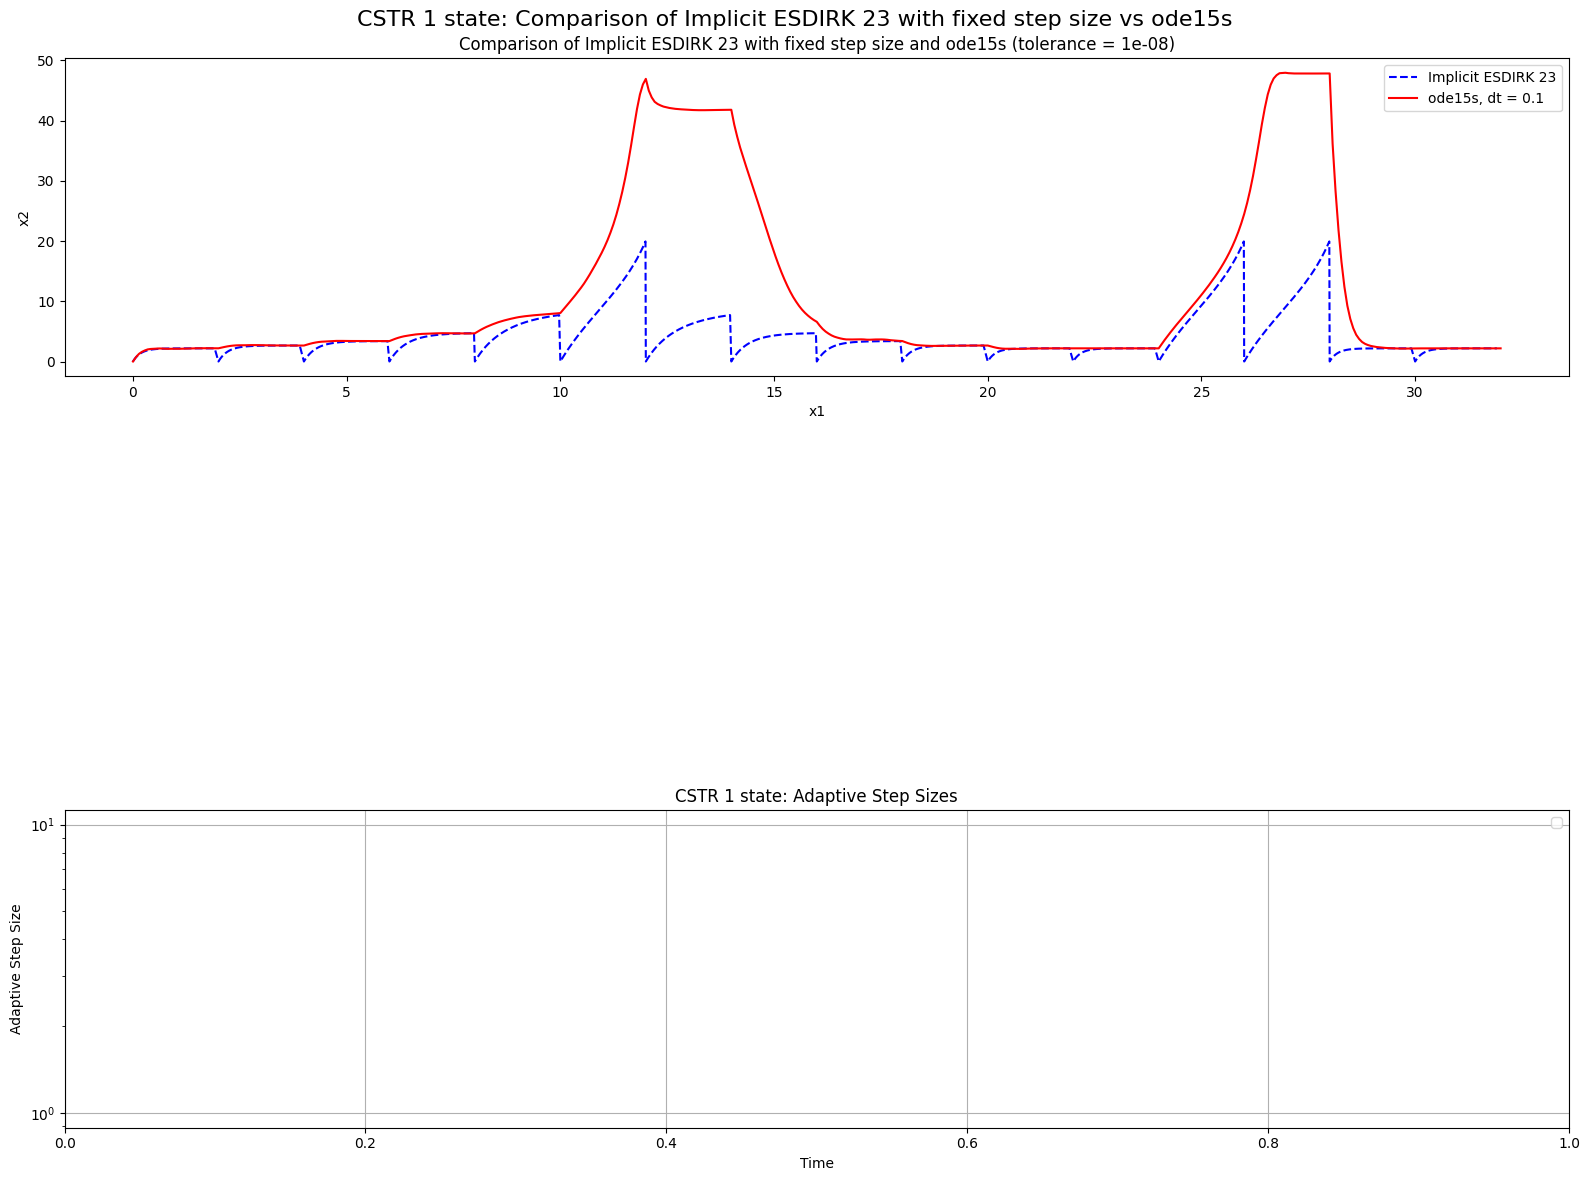

In [22]:
t_span = (0, 120)

result = compare_solvers_cstr(CSTR_1state_model, t_span, adaptive_steps = True, implicit = True, esdirk = True, reference_solver='BDF', tolerances = [1e-8])

In [19]:
#Parameters
from Solvers import ESDIRK
t_span = (0, 120)

min = 60
F = [0.7/min,0.6/min,0.5/min,0.4/min,0.3/min,0.2/min,0.3/min,0.4/min,0.5/min,0.6/min,0.7/min,0.7/min,0.2/min,0.2/min,0.7/min,0.7/min]

#F = np.arange(0.1, 0.7, 0.1)/min

t = np.array([])
Tf = np.array([])

Tin = 273.65
CA_in = 2.4/2
CB_in = 1.6/2

x0 = np.array([Tin])

N = 60

# Storage for results
steady_states = np.array([])
flow_rates = np.array([])

for idx, flow in enumerate(F):
    params = [flow,0.105,CA_in,CB_in,Tin]

    f, J = CSTR_1state_model(params, esdirk = True)
    # Solve using odeint
    t_sol, y, G, _, stats= ESDIRK(f, J, t_span, x0, 0.1, 1e-8, 1e-8, Method = 'ESDIRK23')
    # The steady state is the final point in the simulation
    T_ss = y[0][-1]
    
    x0 = np.array([T_ss])

    Tf = np.concatenate([Tf, y.ravel()-Tin])

    # Store results
    steady_states = np.hstack([steady_states, x0])
    #print(F[idx])
    flow_rates = np.append(flow_rates, F[idx] * min * 1000)  # Convert back to L/min for plotting

    t = np.concatenate([t, (t_sol+(idx)*t_span[1])/min])

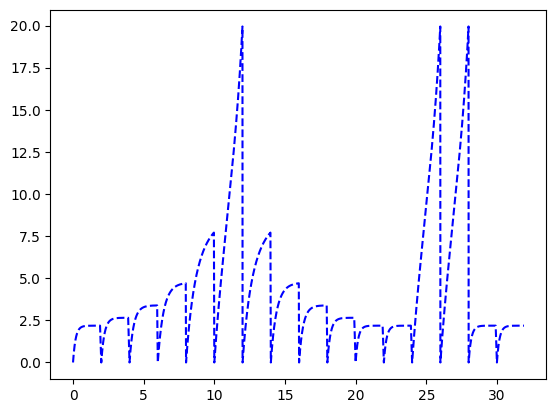

In [8]:
plt.plot(t, Tf, label='Implicit Euler Adaptive Step', linestyle='--', color='blue')

### Prey-predator problem

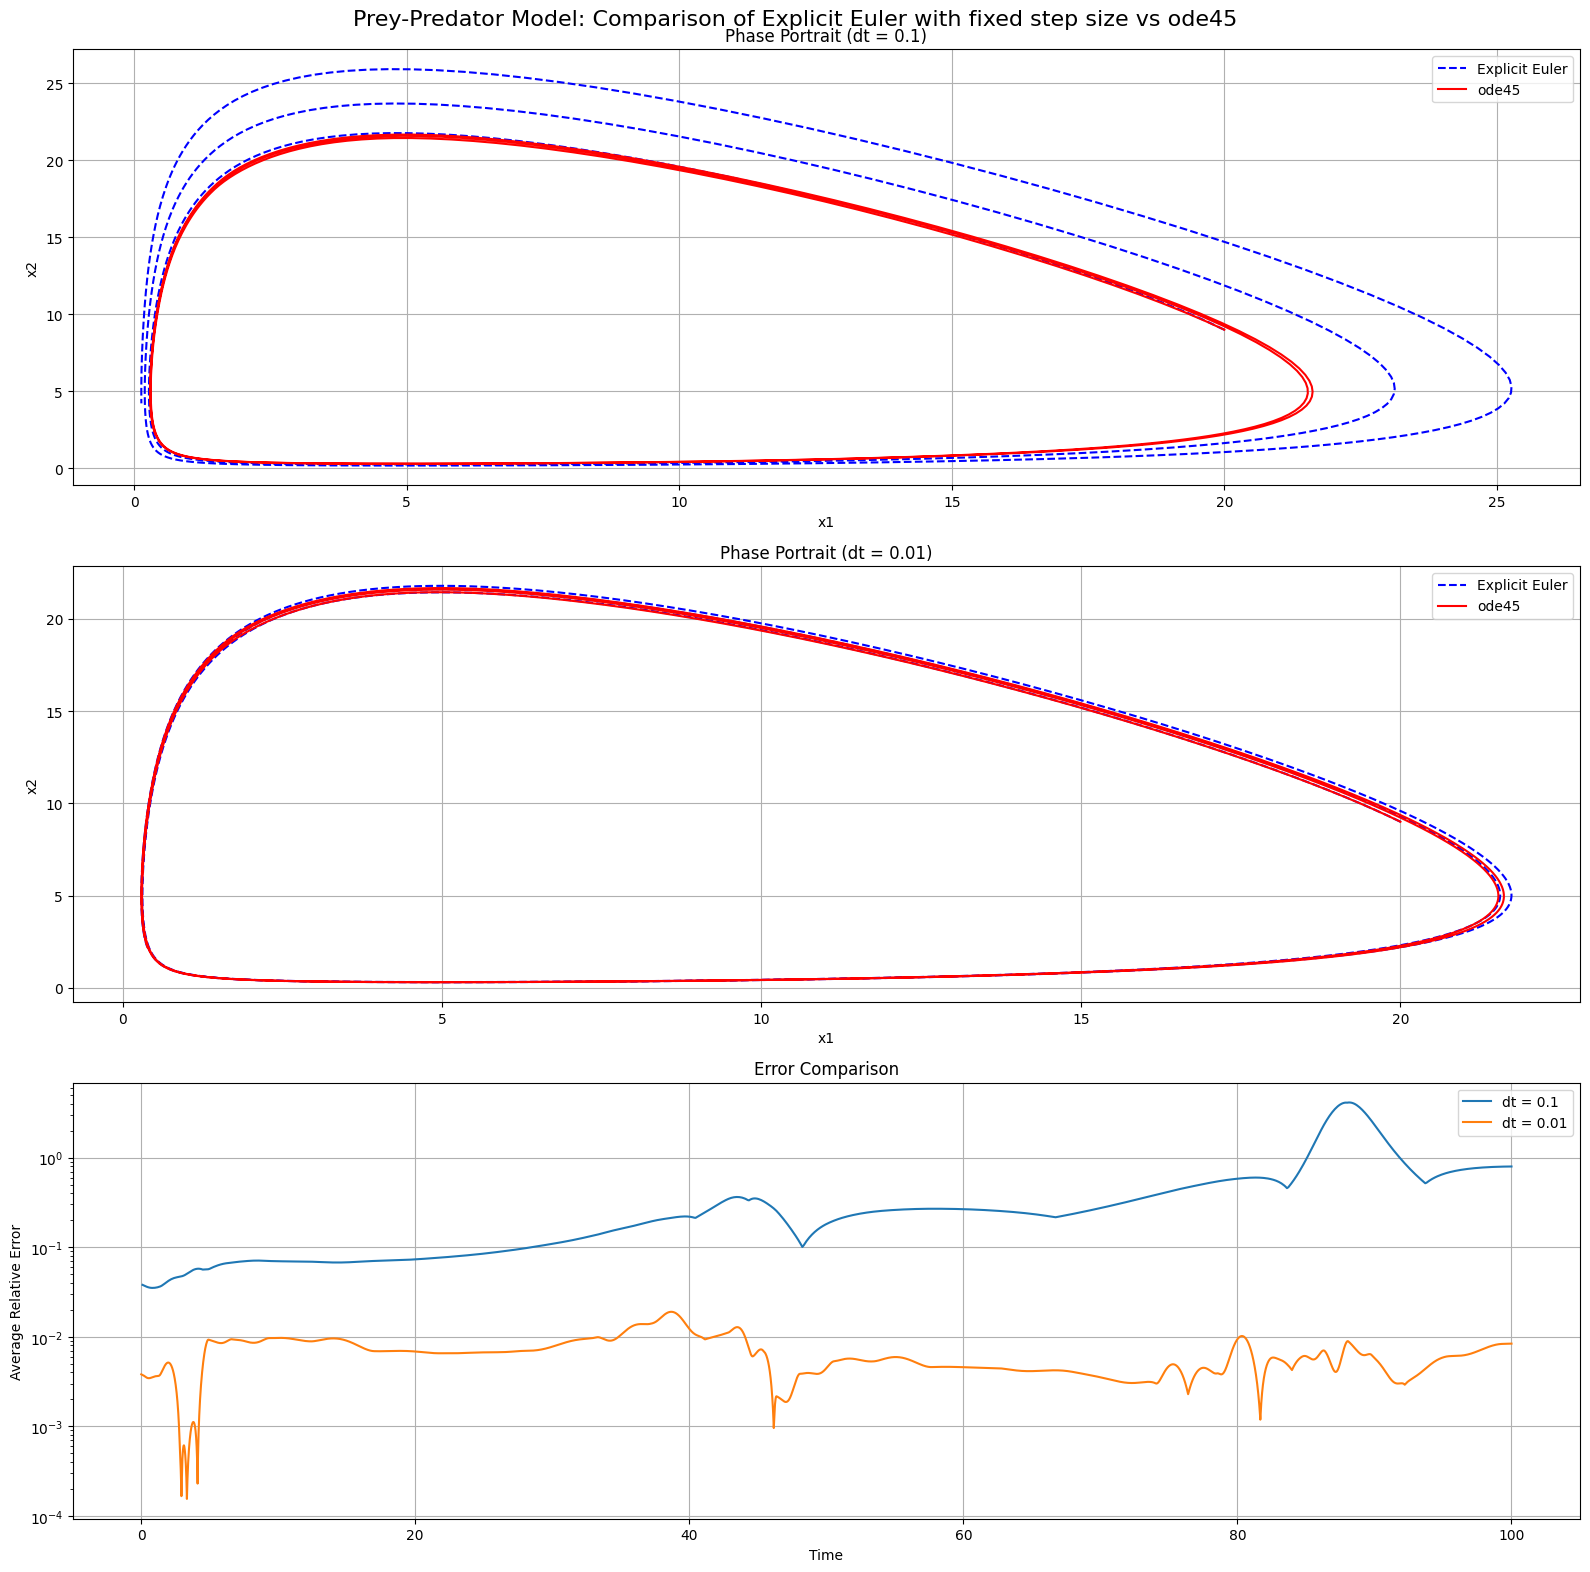

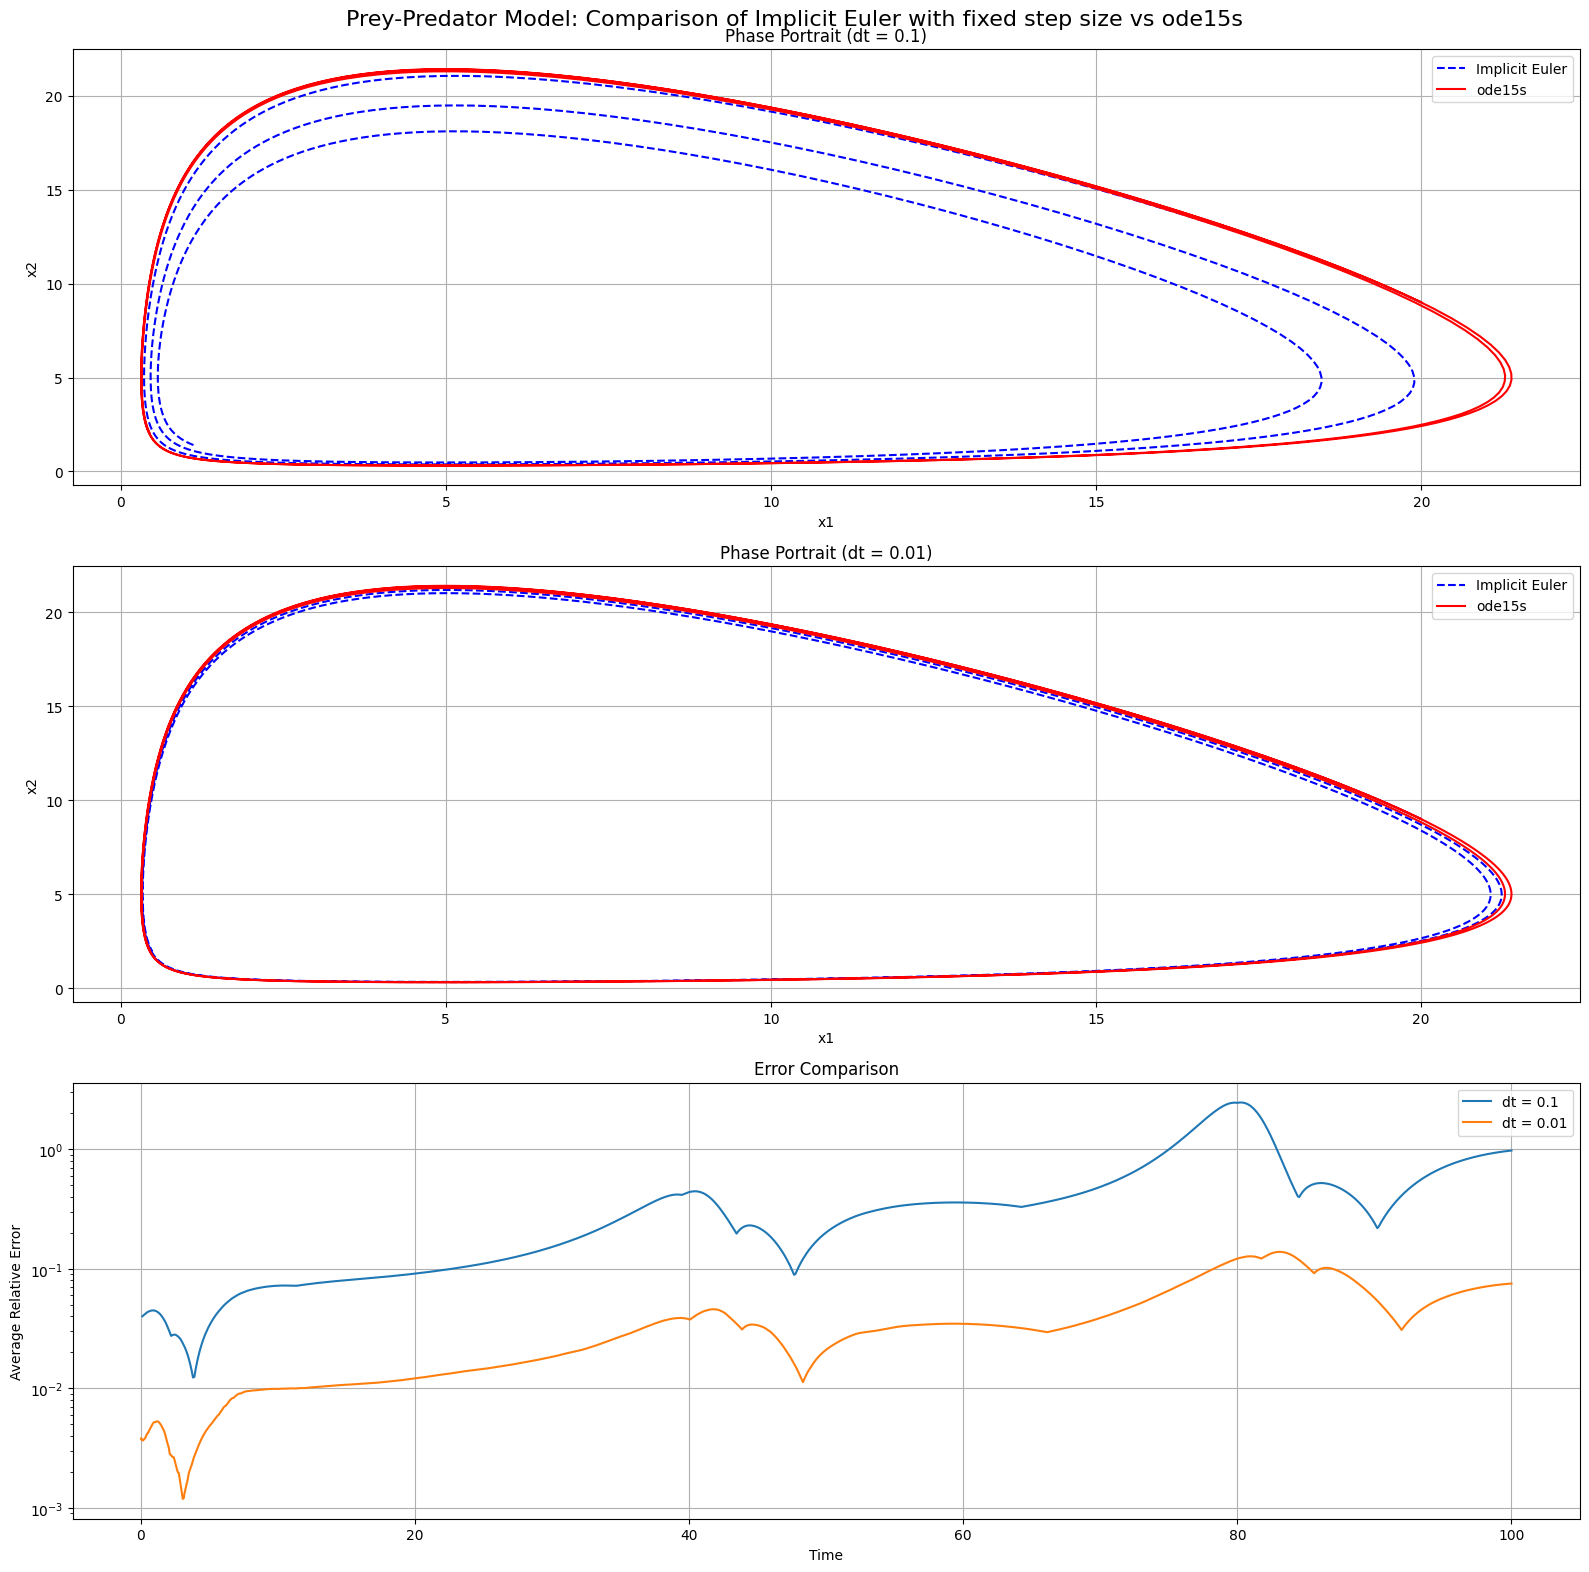

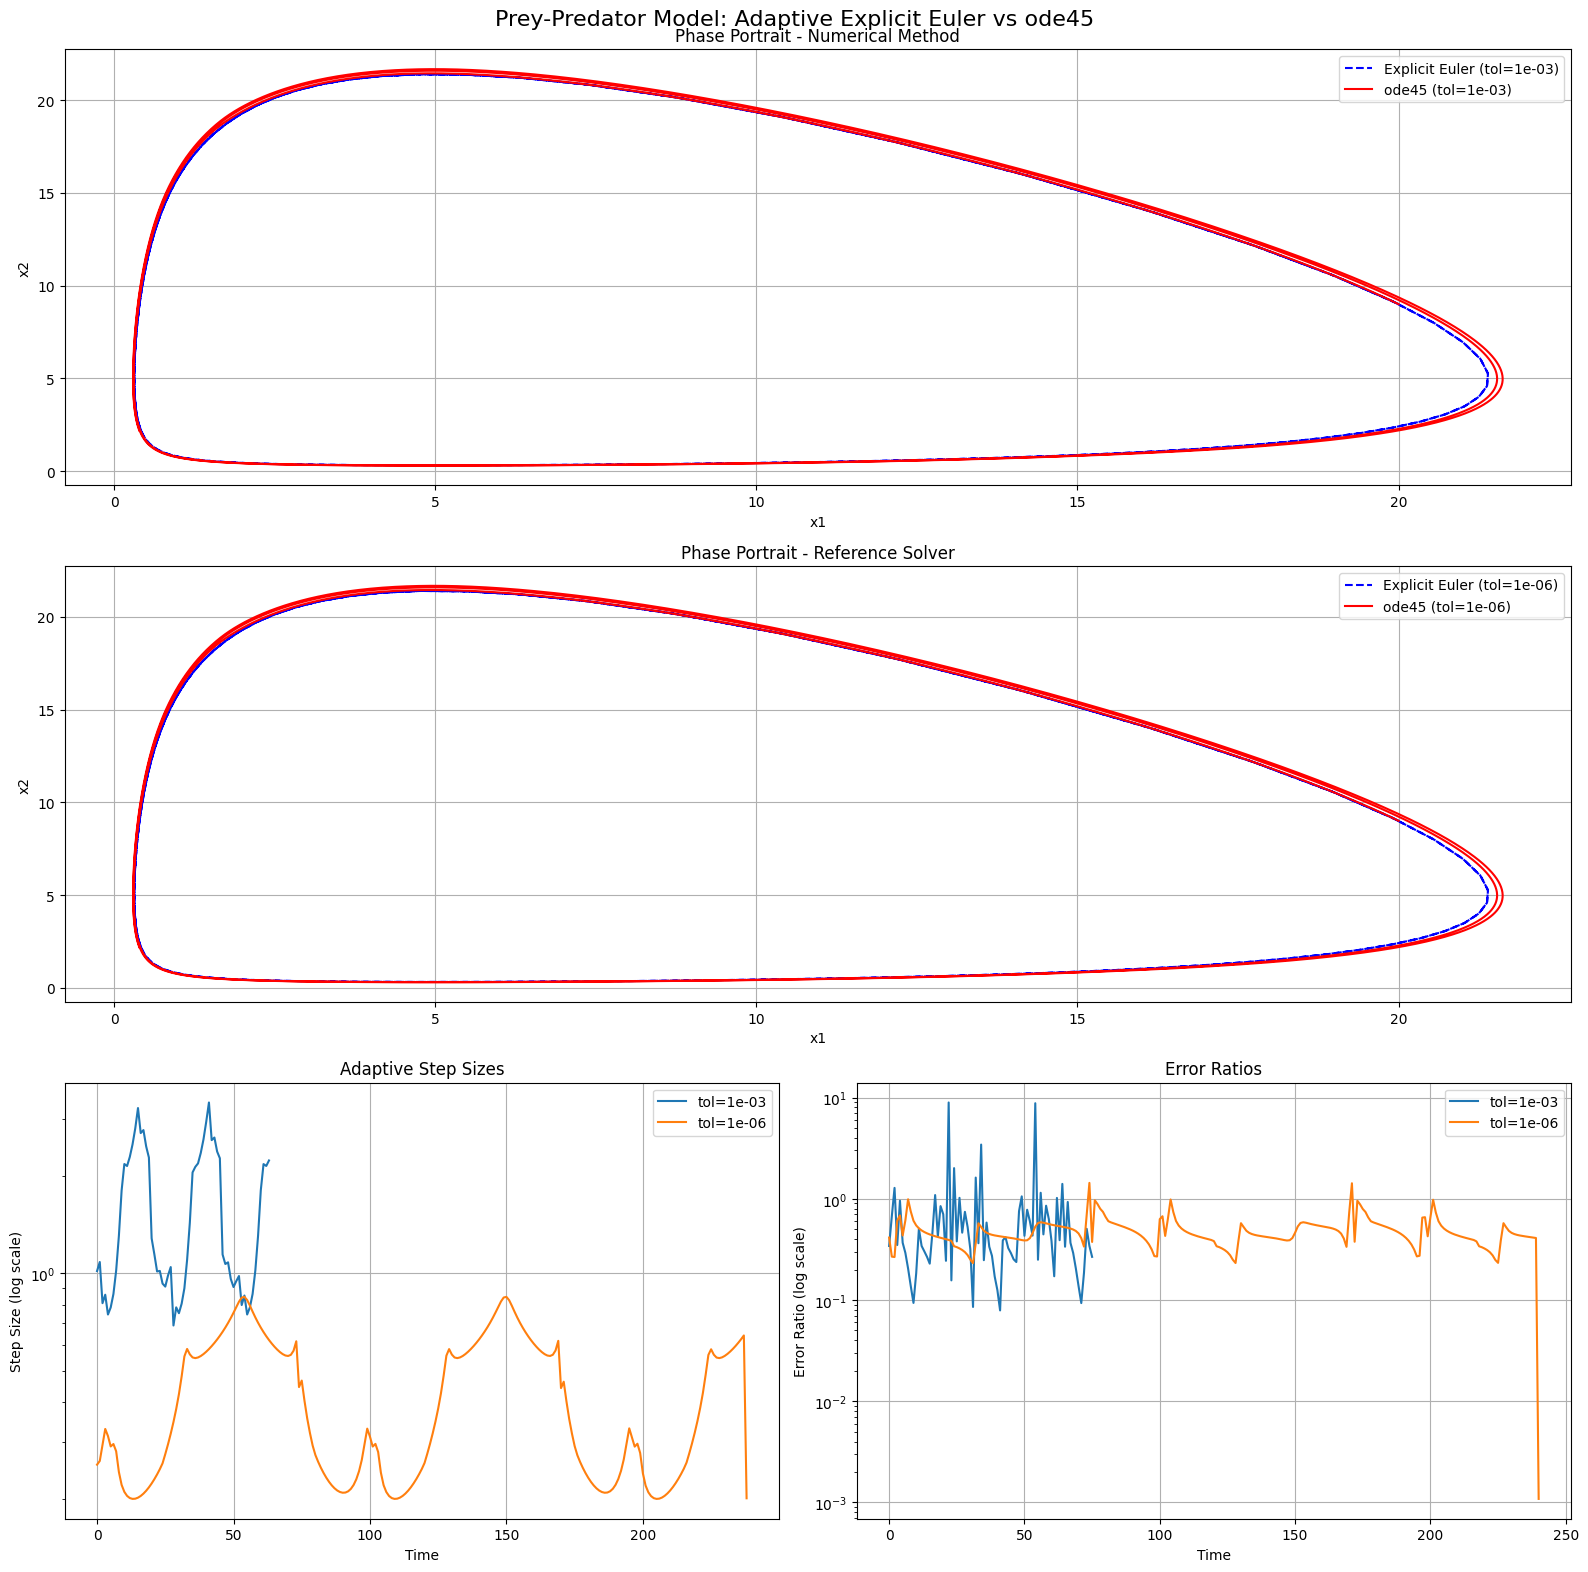

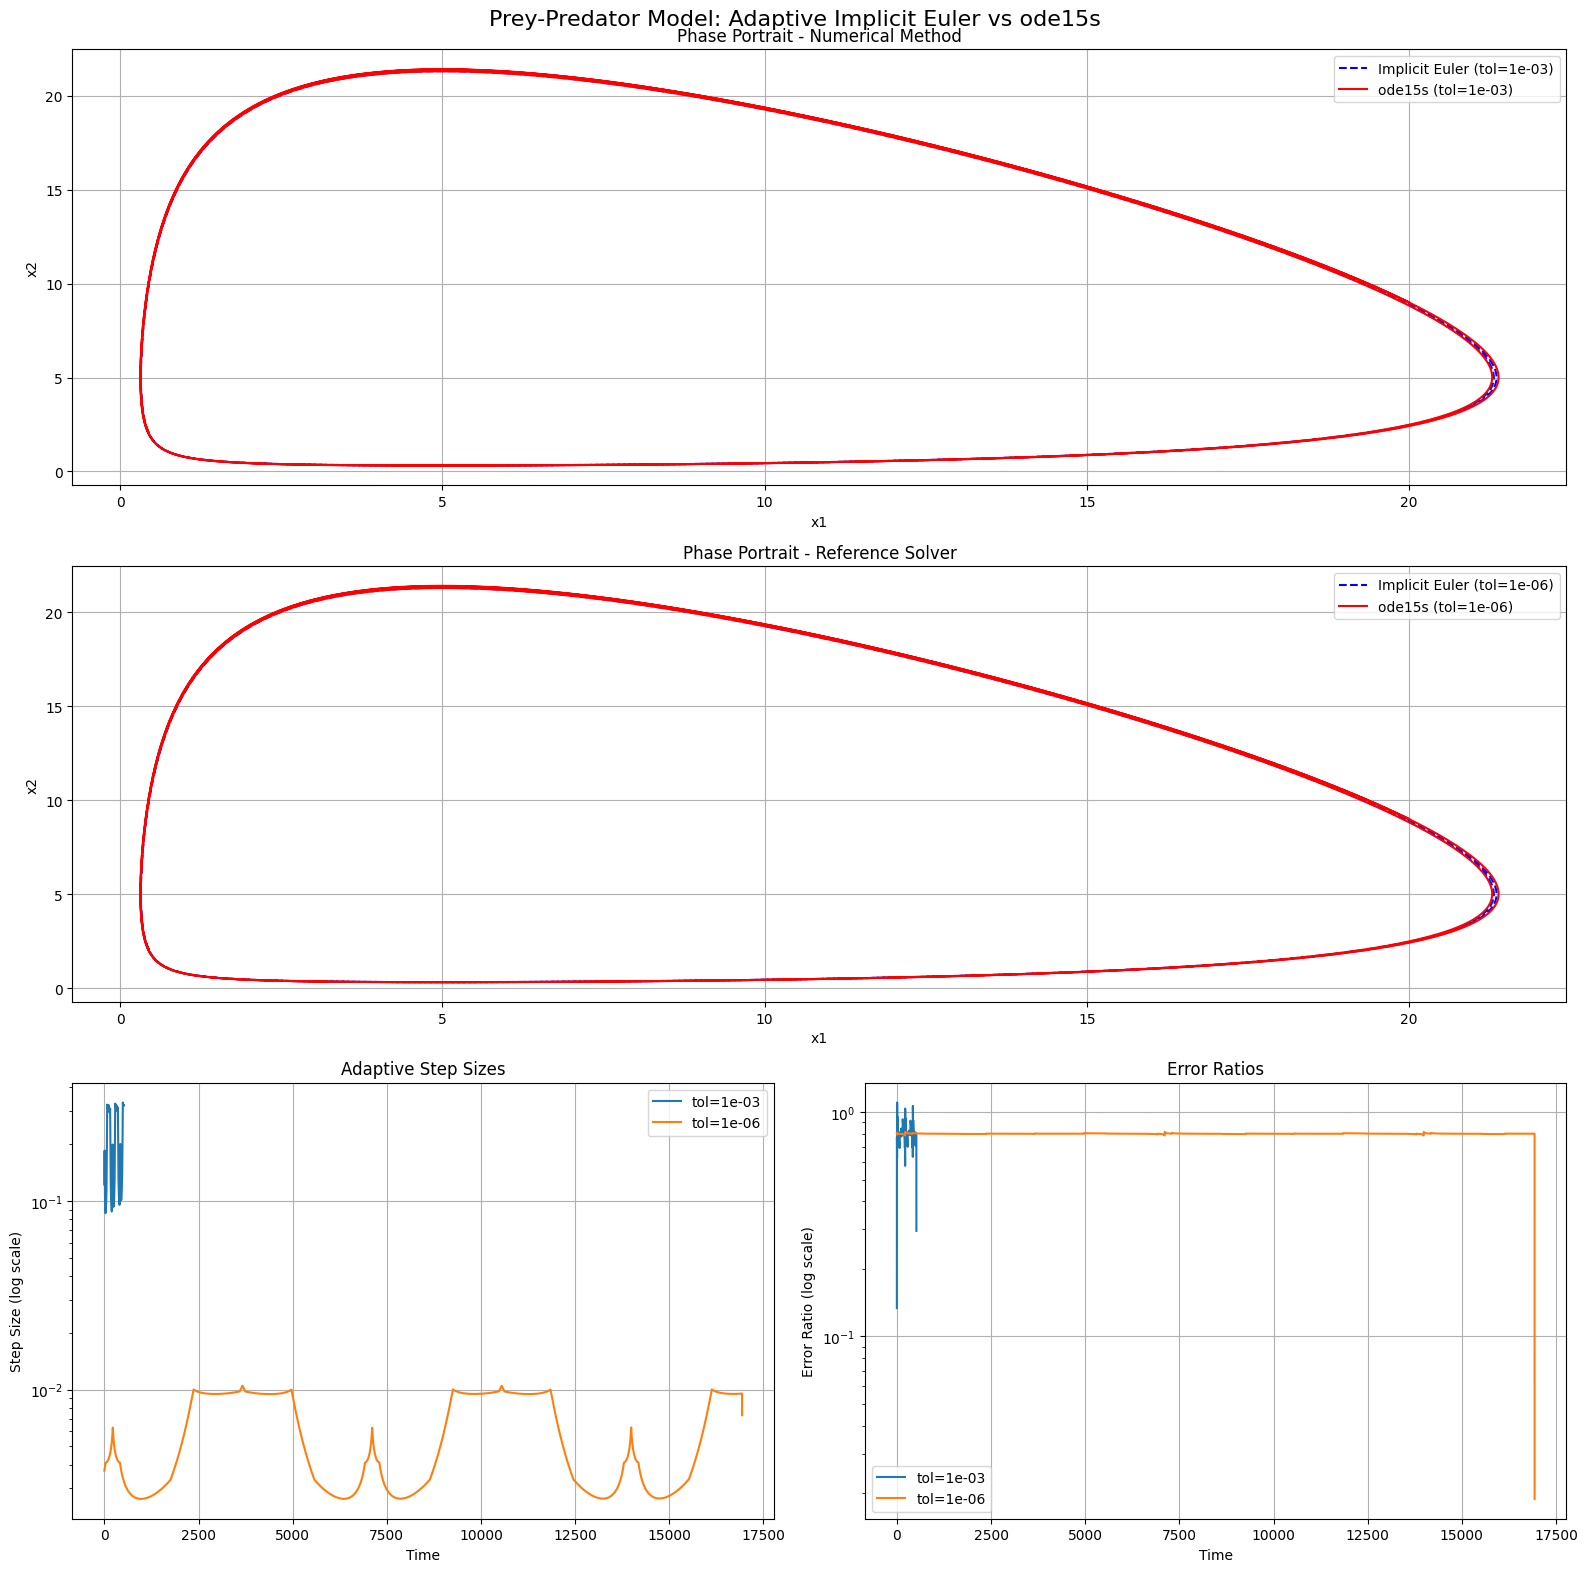

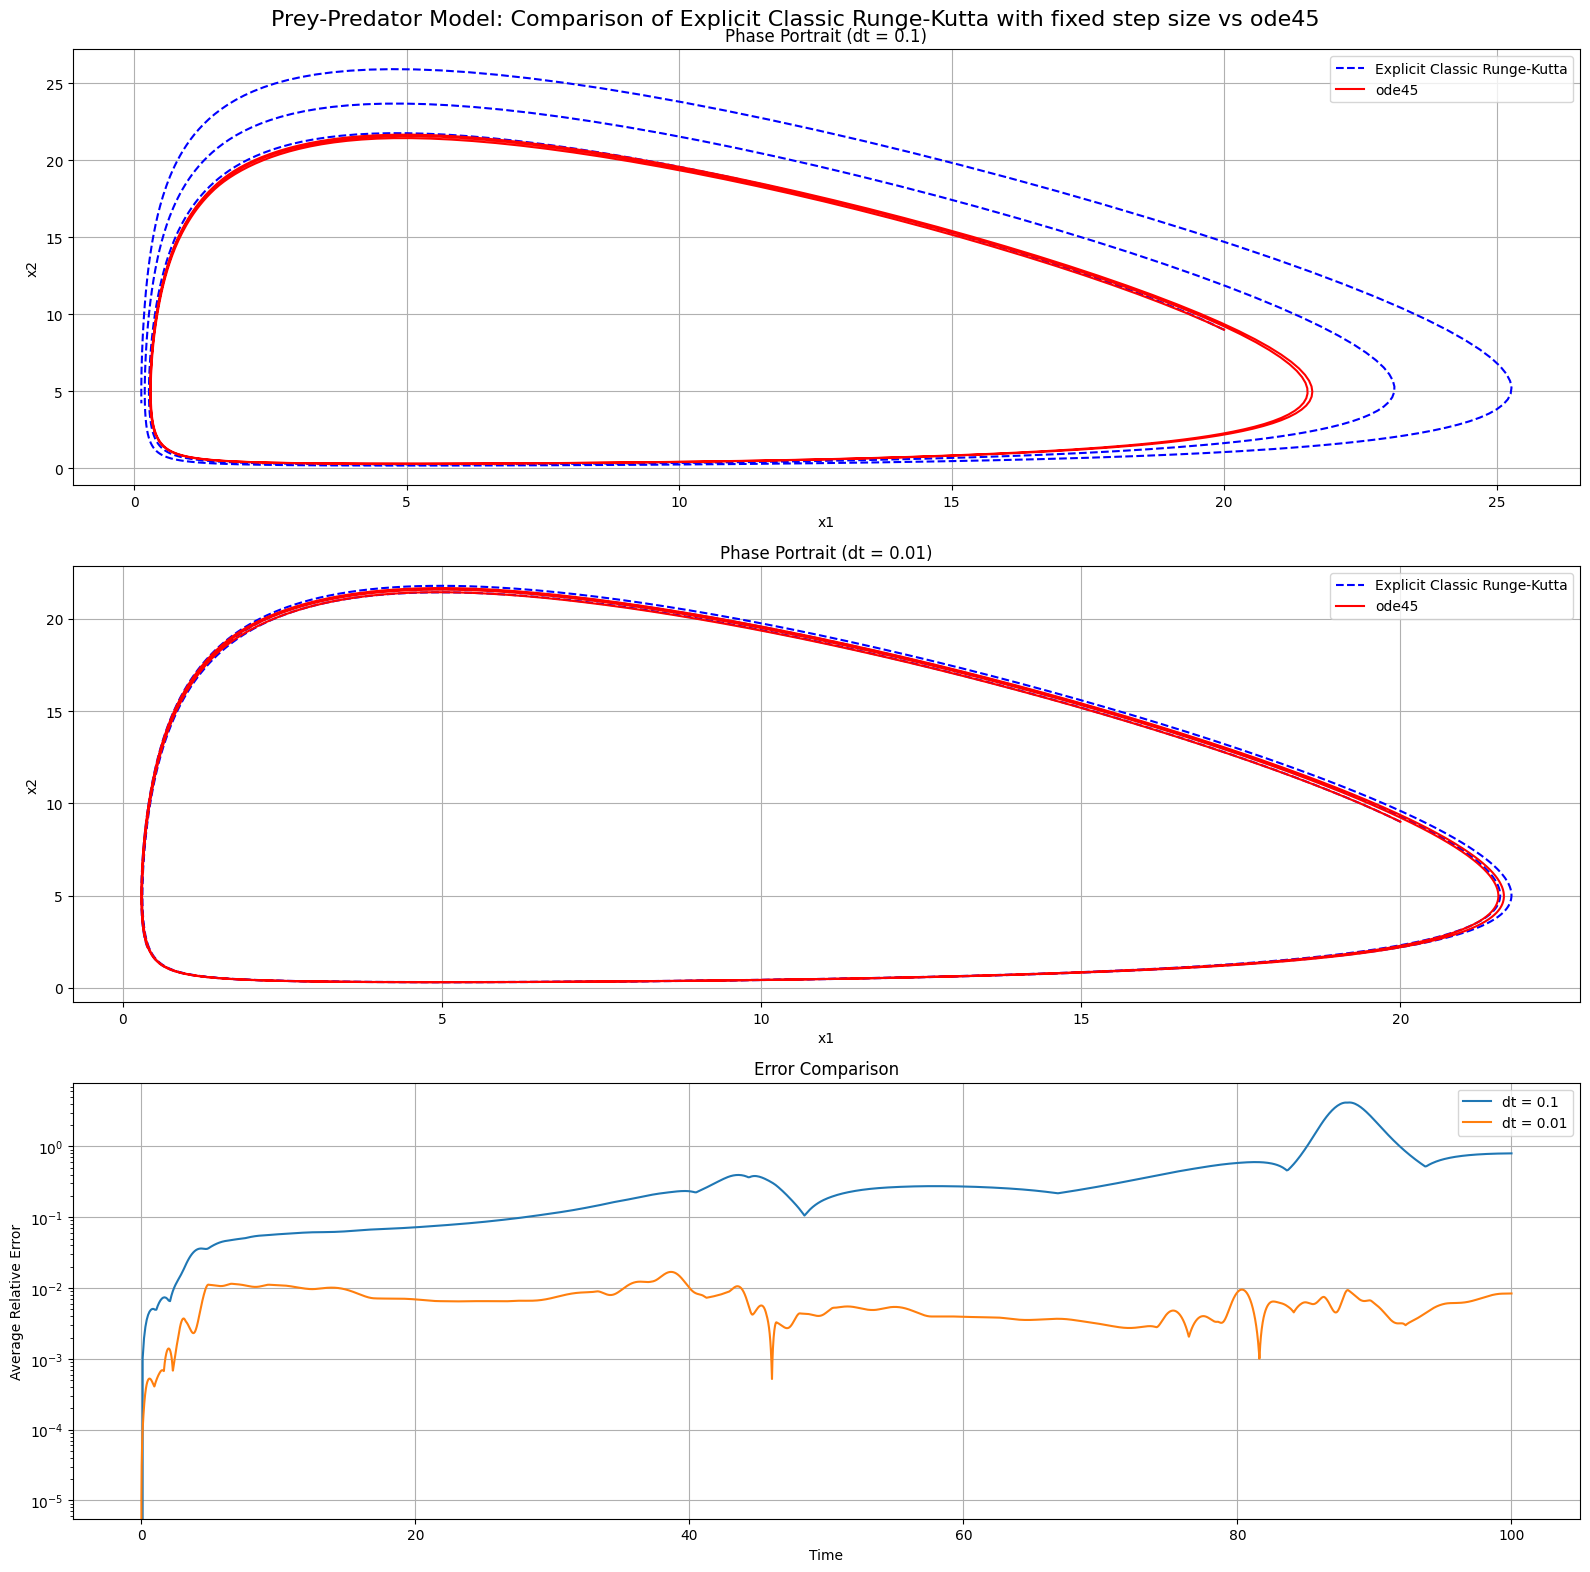

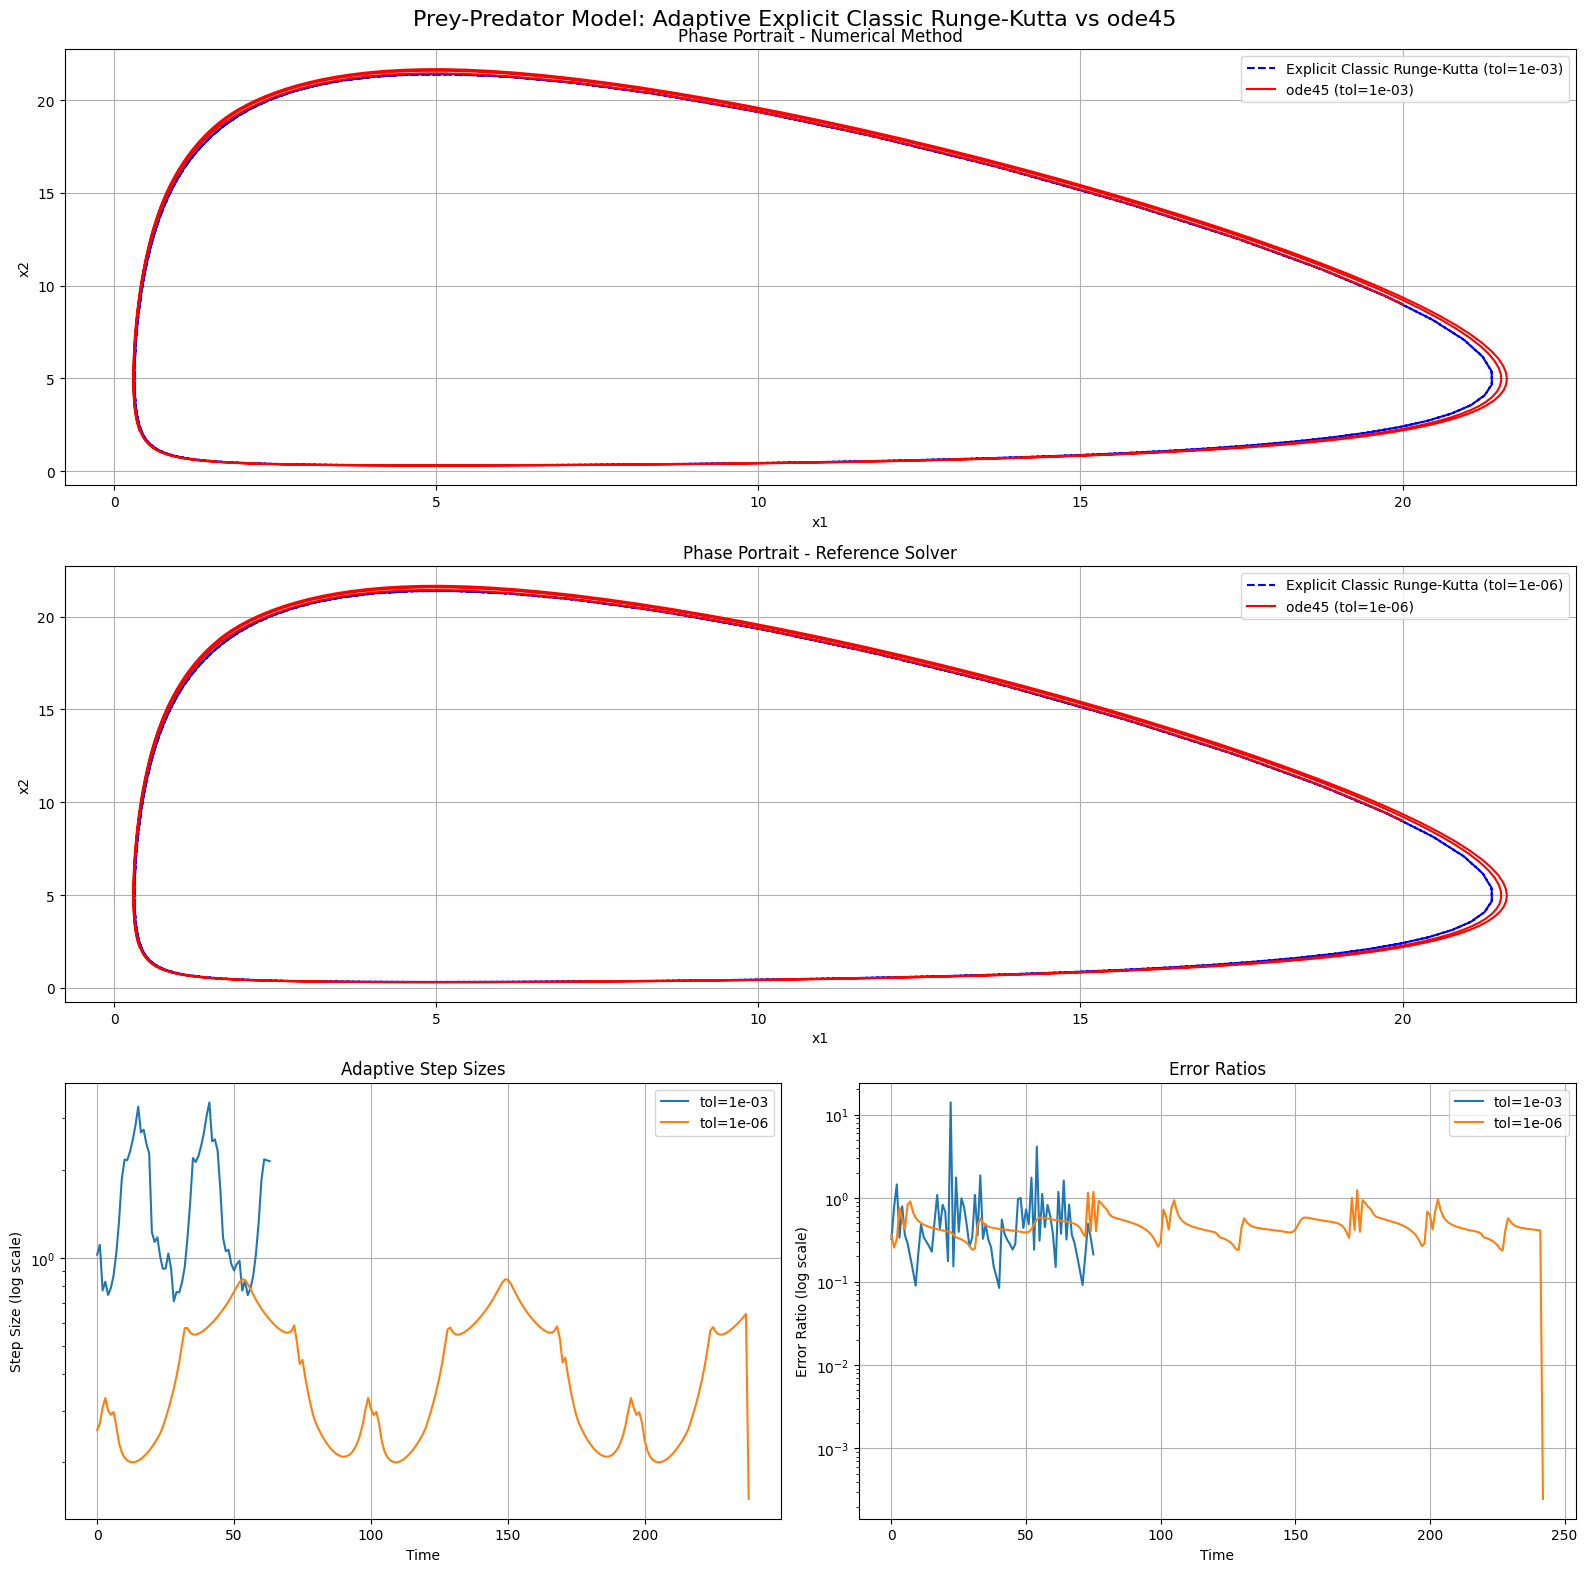

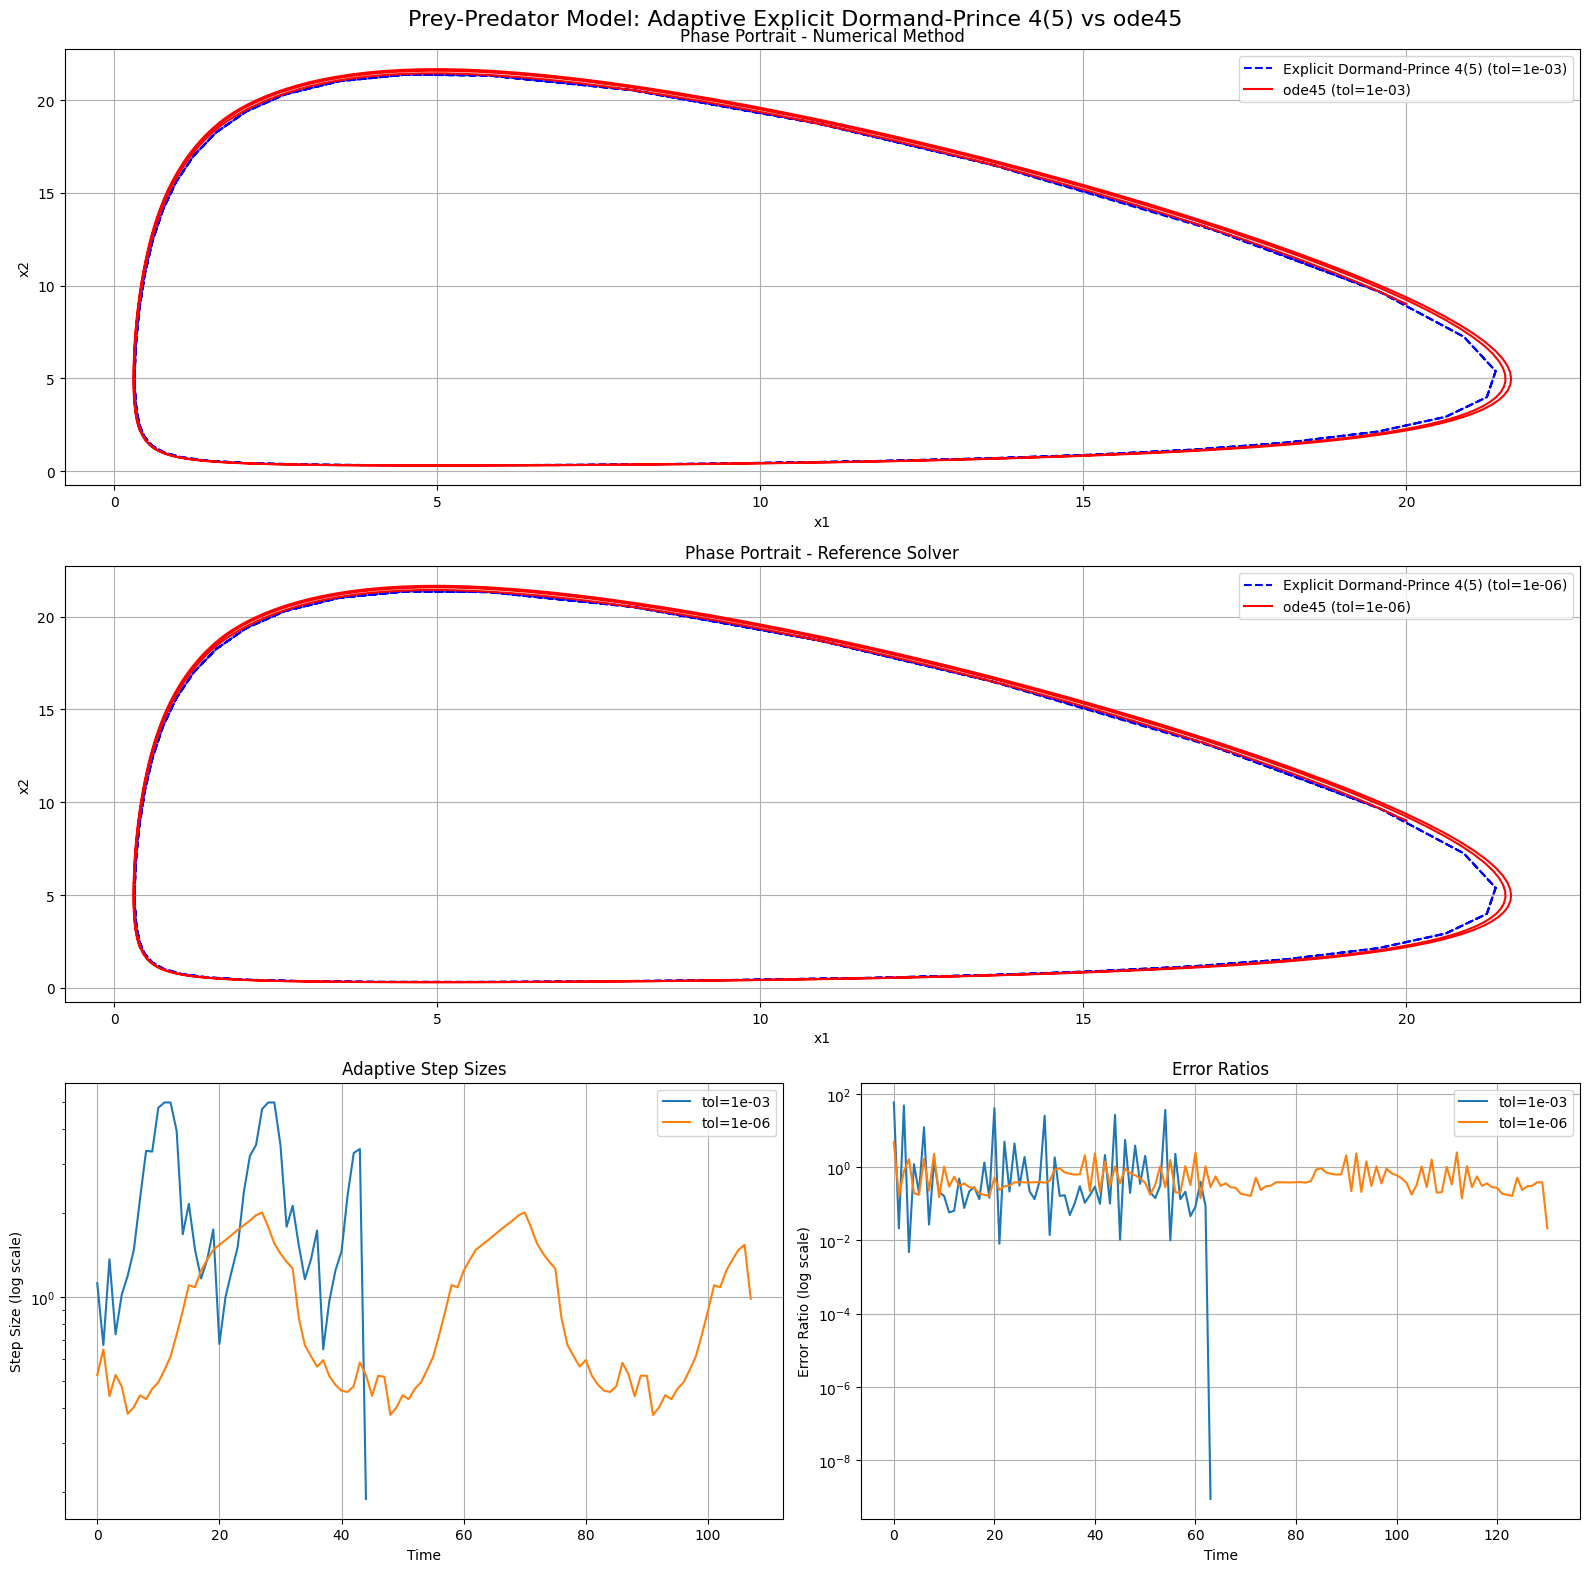

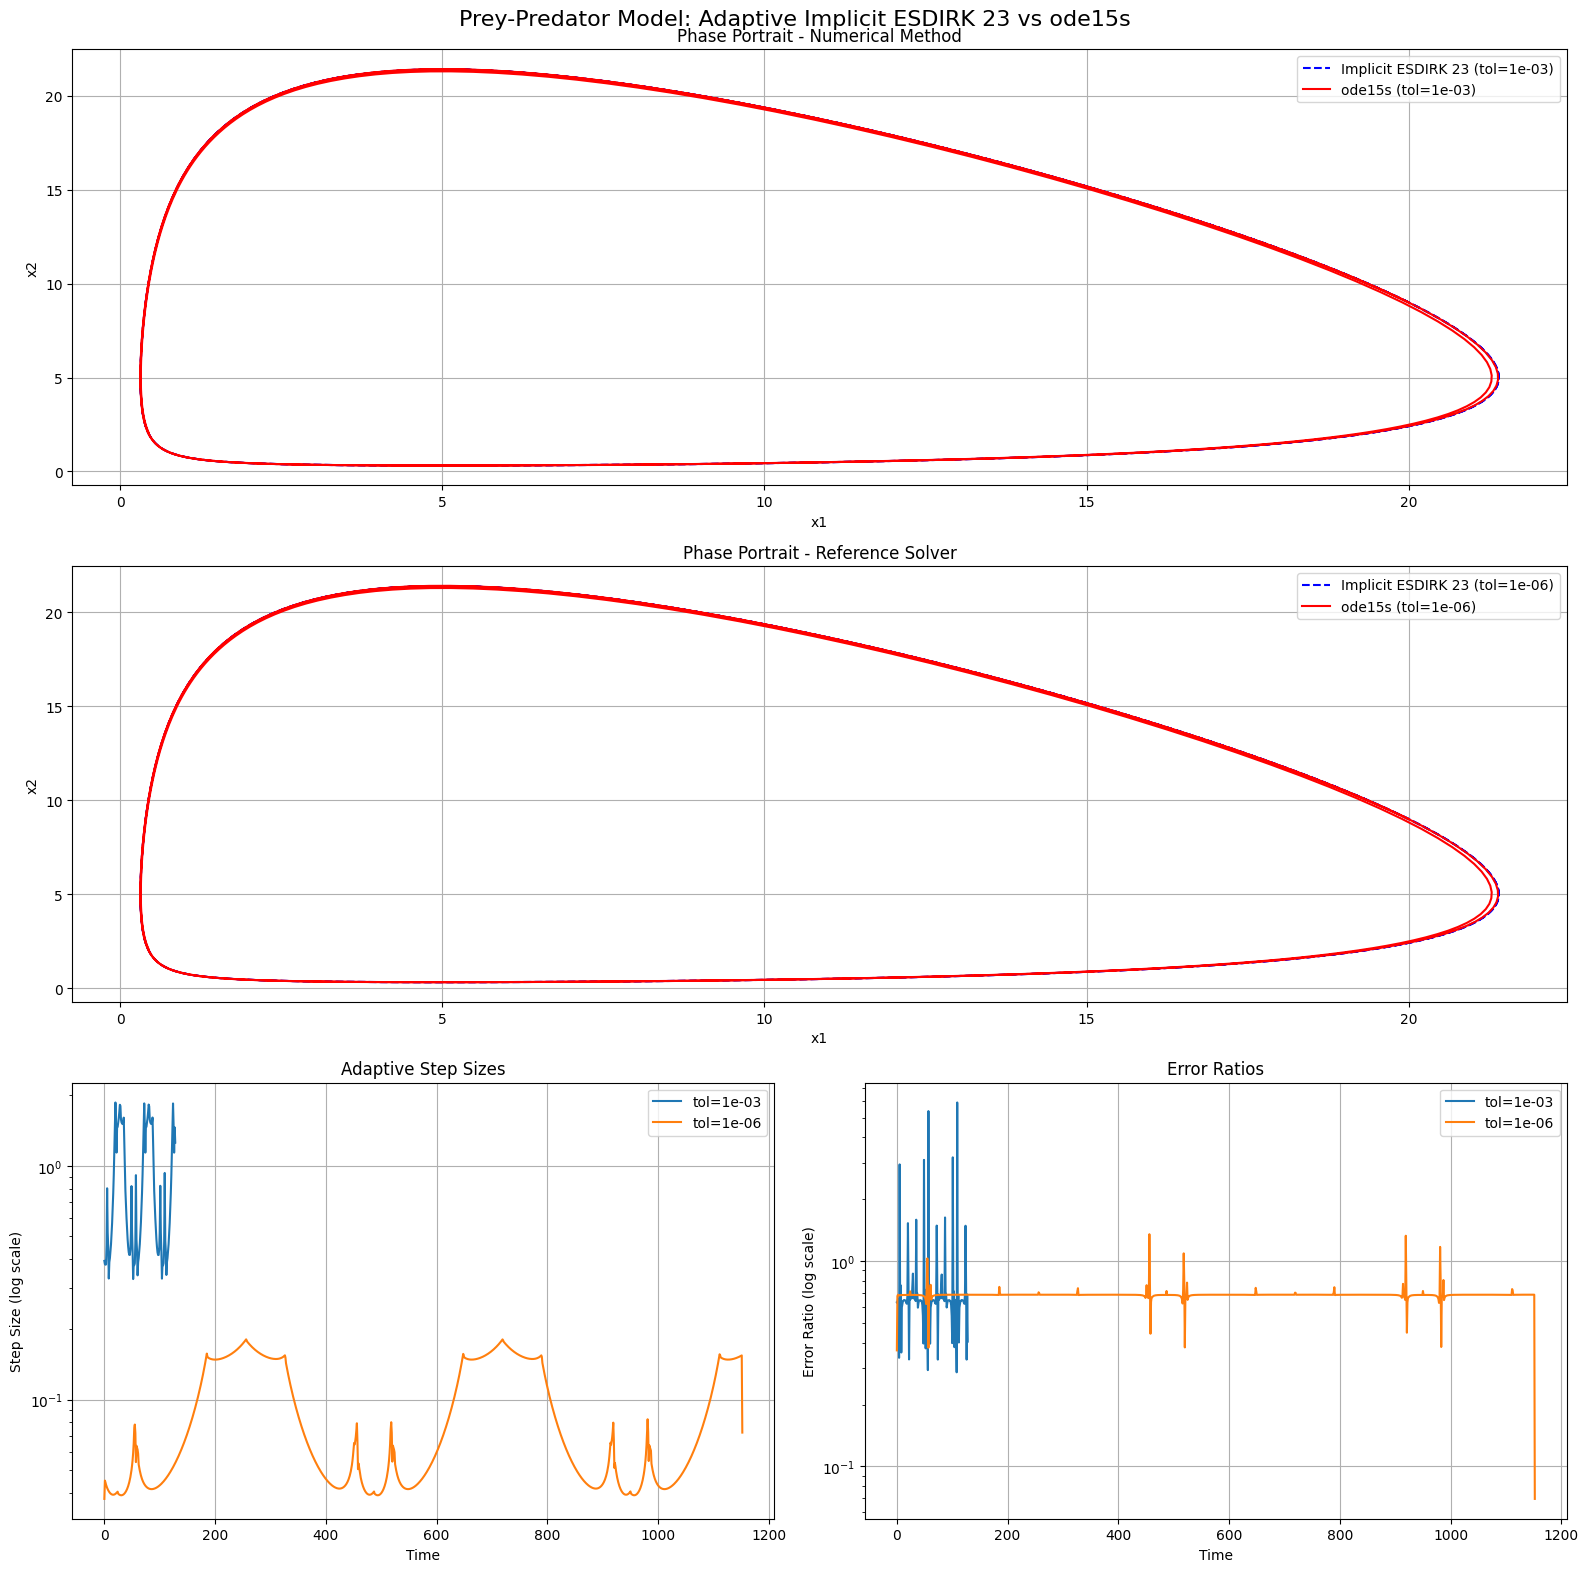

In [31]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate
pp_exp_fixed = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode45", fixed_steps = True, explicit = True, euler = True)
pp_imp_fixed = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode15s", fixed_steps = True, implicit=True, reference_solver='BDF', euler = True)
pp_exp_adaptive = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, explicit = True, euler = True)
pp_imp_adaptive = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode15s", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, implicit=True, reference_solver='BDF', euler = True)
pp_rk_fixed = compare_solvers(prey_predator_model, t_span, x0, params=(a, b), model_name="Prey-Predator Model", reference_solver_name = "ode45", fixed_steps=True, explicit=True, rk45=True)
pp_rk_adaptive = compare_solvers(prey_predator_model, t_span, x0, params=(a, b), model_name="Prey-Predator Model", reference_solver_name = "ode45", adaptive_steps= True, explicit=True, rk45=True, steptype = "adaptive")
pp_dpori_adaptive = compare_solvers(prey_predator_model, t_span, x0, params=(a, b), model_name="Prey-Predator Model", reference_solver_name = "ode45", adaptive_steps= True, explicit=True, dopri=True, steptype = "adaptive")
ed_imp_adaptive = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode15s", steptype = "adaptive", adaptive_steps = True, h0 = 0.1, implicit=True, reference_solver='BDF', esdirk = True)

In [10]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

N = 1000
f, J = prey_predator_model(a, b)

# Solve using ode45 (method='RK45')
ode45_pp_01 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
euler_fixed_t_pp01, solution_fixed_x_pp01 = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

N = 10000
ode45_pp_001 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
euler_fixed_t_pp001, solution_fixed_x_pp001 = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

pp01_error = abs_error(solution_fixed_x_pp01[:, 1:], solution_ode45_pp_01.y)
pp001_error = abs_error(solution_fixed_x_pp001[:, 1:], solution_ode45_pp_001.y)

#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(16,12))
plt.suptitle("Prey-Predator Model: Explicit Euler vs ode45", fontsize=16)
# Plot time series for non-stiff
plt.subplot(3, 1, 1)
plt.plot(solution_fixed_x_pp01[0,:], solution_fixed_x_pp01[1, :], label = 'Explicit Euler', color='blue')
plt.plot(solution_ode45_pp_01.y[0, :], solution_ode45_pp_01.y[1, :], label='ode45', color='red')
plt.legend()
plt.title("Comparison of Explicit Euler and ode45 for Prey-Predator Model (dt = 0.1)")
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")

plt.subplot(3, 1, 2)
plt.plot(solution_fixed_x_pp001[0,:], solution_fixed_x_pp001[1, :], label = 'Explicit Euler', color='blue')
plt.plot(solution_ode45_pp_001.y[0, :], solution_ode45_pp_001.y[1, :], label='ode45', color='red')
plt.legend()
plt.title("Comparison of Explicit Euler and ode45 for Prey-Predator Model (dt = 0.01)")
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
# Plot error comparison

plt.subplot(3, 1, 3)
plt.plot(solution_fixed_t_pp01[1:], (pp01_error[0, :] + pp01_error[1, :])/2, label='dt = 0.1')
plt.plot(solution_fixed_t_pp001[1:], (pp001_error[0, :] + pp001_error[1, :])/2, label='dt = 0.01')
plt.legend()

plt.yscale('log')
plt.title("Prey-Predator Model: Error Comparison")
plt.xlabel("Time")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'solution_ode45_pp_01' is not defined

#### Explicit Euler fixed step size = 0.01

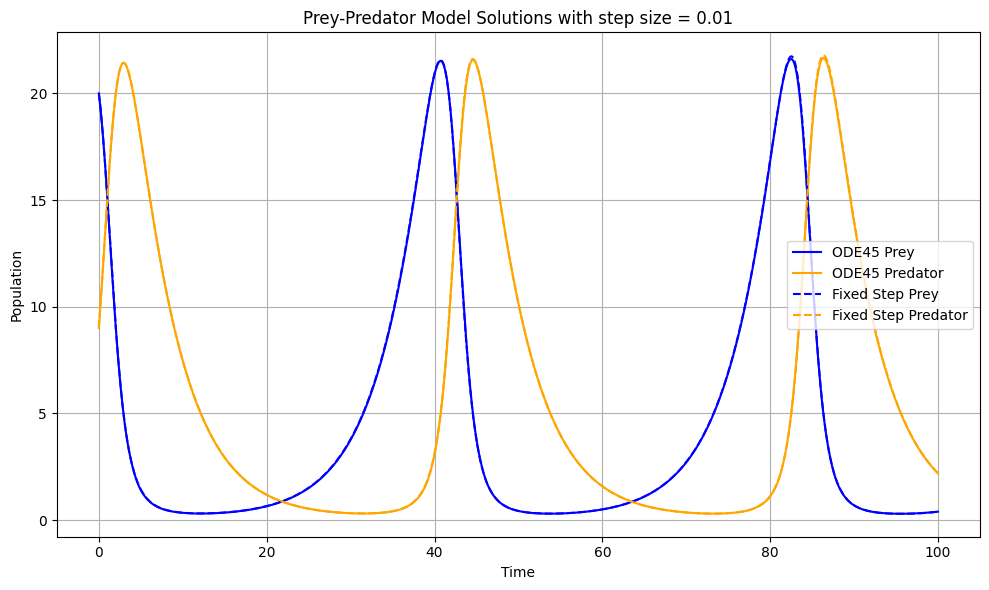

In [ ]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)

# Solve using ode45 (method='RK45')
solution_ode45 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 500))

# Solve using Explicit Euler with fixed step size
N = 10000
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='Fixed Step Prey', linestyle='--', color='blue')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='Fixed Step Predator', linestyle='--', color='orange')
plt.title('Prey-Predator Model Solutions with step size = 0.01')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha * x - beta * x * y
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dydt = beta * x * y - alpha * y
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  dydt = beta * x * y - alpha * y


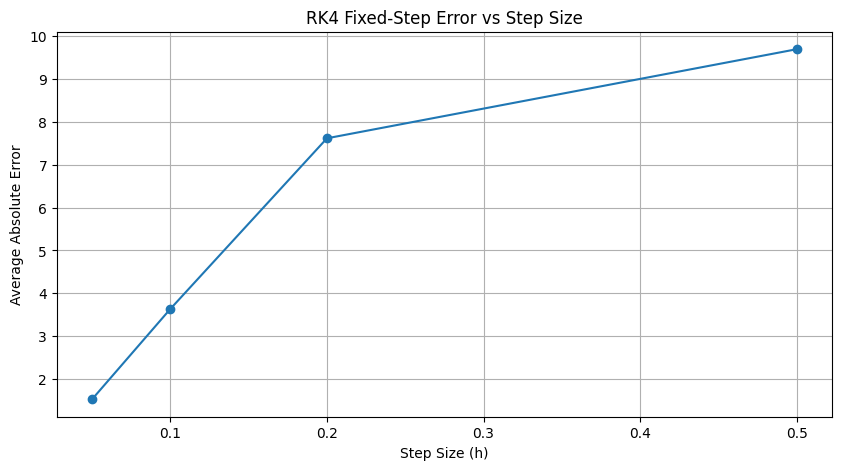

In [ ]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Prey, Predator

# Define the model
f, _ = prey_predator_model(0.2,0.04)

# Test different fixed step sizes
N_values = np.array([50, 100, 200, 500, 1000, 2000])
h_values = (t_span[1] - t_span[0]) / N_values
errors = []

for idx, N in enumerate(N_values):
    # Solve with your fixed-step RK4
    t_fixed, x_fixed = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

    # Solve with scipy's RK45 (reference solution)
    solution_ode45 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
    # Interpolate prey and predator separately
    prey_interp = np.interp(solution_ode45.t, t_fixed, x_fixed[0, :])  # Prey
    predator_interp = np.interp(solution_ode45.t, t_fixed, x_fixed[1, :])  # Predator
    
    # Compute error (L1 norm)
    error = np.mean(np.abs(prey_interp - solution_ode45.y[0]) + 
                   np.abs(predator_interp - solution_ode45.y[1]))
    errors.append(error)

# Plot error vs step size
plt.figure(figsize=(10, 5))
plt.plot(h_values, errors, 'o-')
plt.xlabel('Step Size (h)')
plt.ylabel('Average Absolute Error')
plt.title('RK4 Fixed-Step Error vs Step Size')
plt.grid(True, which="both", ls="-")
plt.show()

#### Explicit Euler with adaptive step size code

In [ ]:
# Explicit Euler with adaptive step size
def ExplicitEulerAdaptiveStep(f, tspan, x0, h0, abstol, reltol, *args):
    # Initialize variables
    t0 = tspan[0]
    tf = tspan[1]
    # Initial conditions
    t = t0
    x = x0
    h = h0

    hmin = 0.1
    hmax = 5
    epstol = 0.8

    # Initialize output arrays
    T = [t0]
    X = [x0]
    H = [h0]

    # Main loop
    while t < tf:
        # Adjust step size
        if t + h > tf:
            h = tf - t

        fun = np.array(f(t, x))

        AcceptStep = False
        while not AcceptStep:
            # Compute the next step
            xnew = x + h * fun

            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * fun
            xnewm = xm + hm * f(tm, xm)

            # Compute the error
            err = np.abs(xnewm - xnew)
            max1 = np.maximum(abstol, np.abs(xnewm) * reltol)
            r = np.max(err / max1)
            AcceptStep = (r <= 1)

            # Check if error is within tolerance
            if AcceptStep:
                # Update time and state
                t = t + h
                x = xnewm
                # Store values
                T.append(t)
                X.append(x)

            # Update step size
            h = np.max([hmin, np.min([hmax, np.sqrt(epstol / r)])]) * h
            H.append(h)

    return np.array(T), np.array(X), np.array(H)

#### Explicit Euler with adaptive step size with tolerance 10^-6

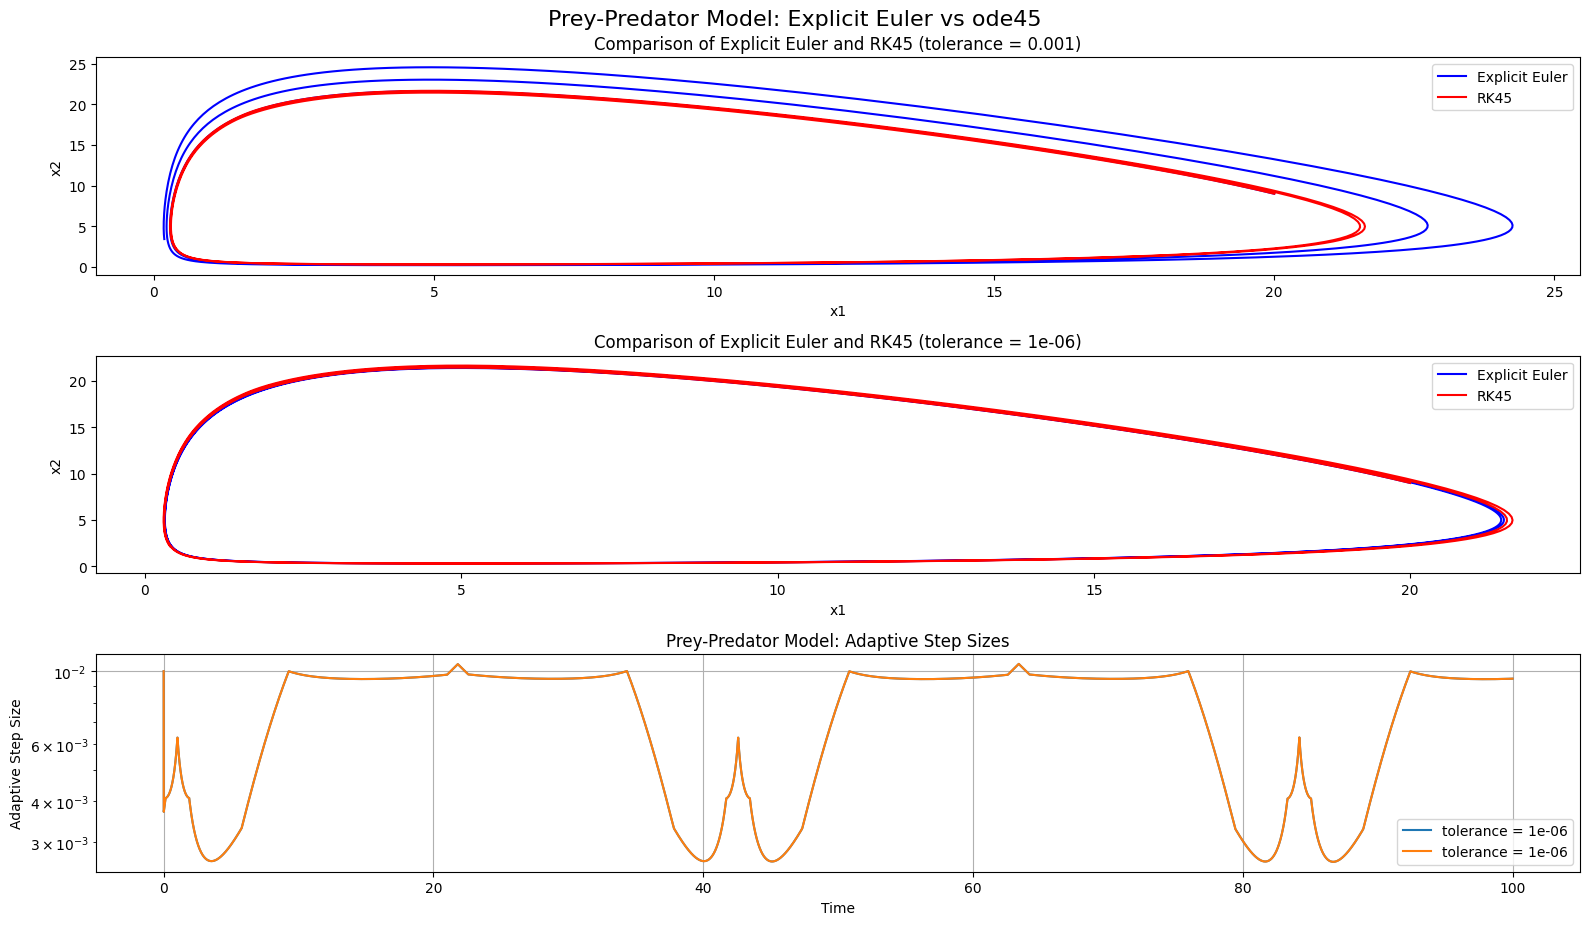

In [ ]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

results = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True, h0 = 0.01)

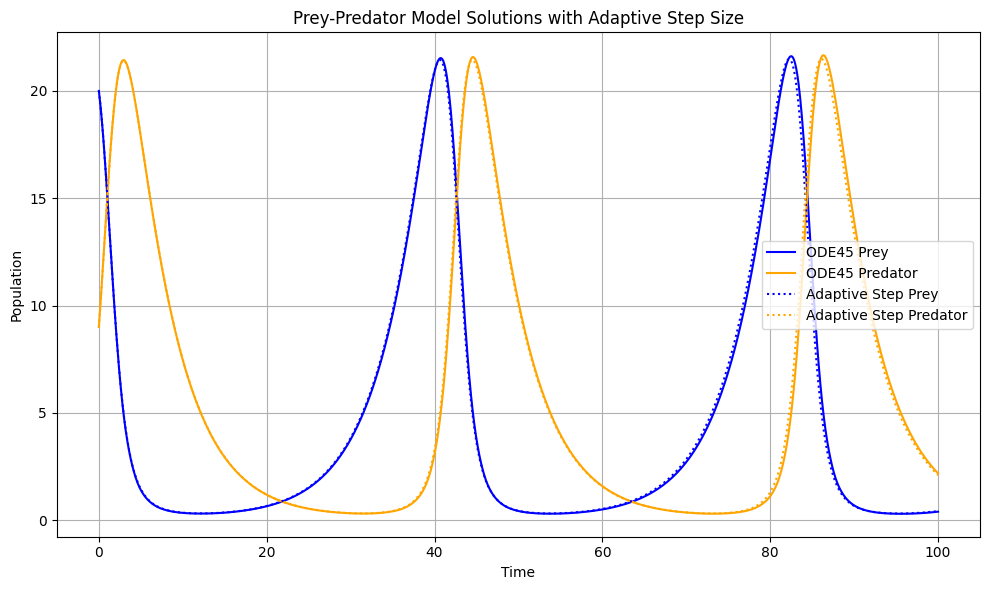

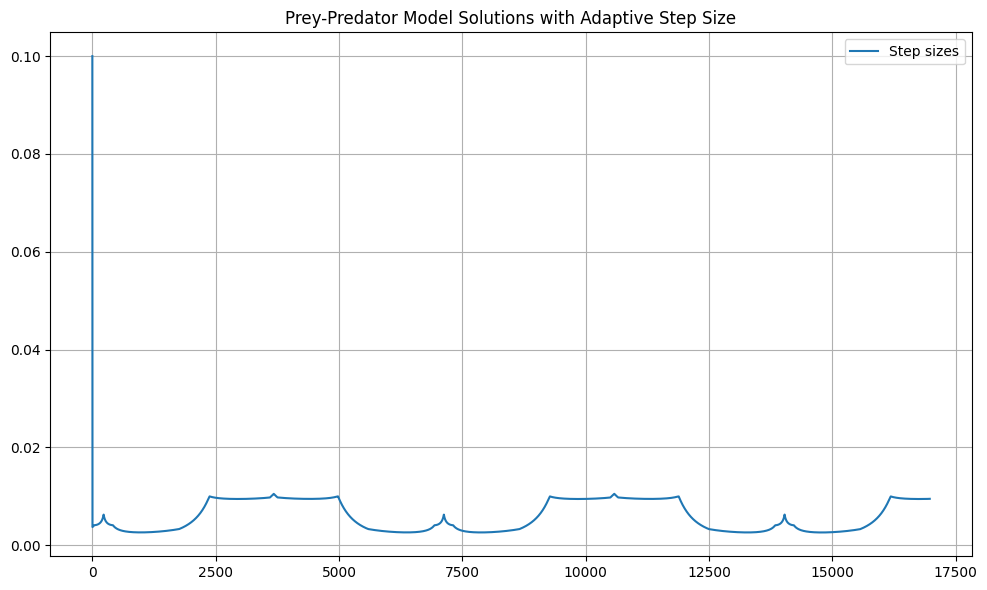

In [ ]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)
# Solve using Explicit Euler with adaptive step size
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ode45_pp_01.t, solution_ode45_pp_01.y[0], label='ODE45 Prey', color='blue')
plt.plot(ode45_pp_01.t, ode45_pp_01.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 0], label='Adaptive Step Prey', linestyle=':', color='blue')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 1], label='Adaptive Step Predator', linestyle=':', color='orange')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



#### Explicit Euler with adaptive step size with tolerance 10^-3

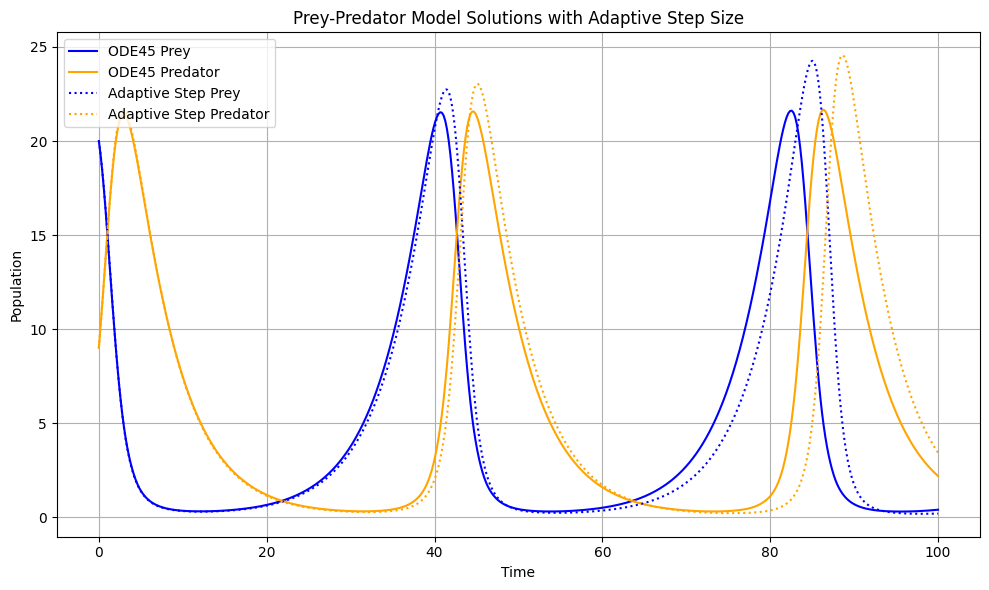

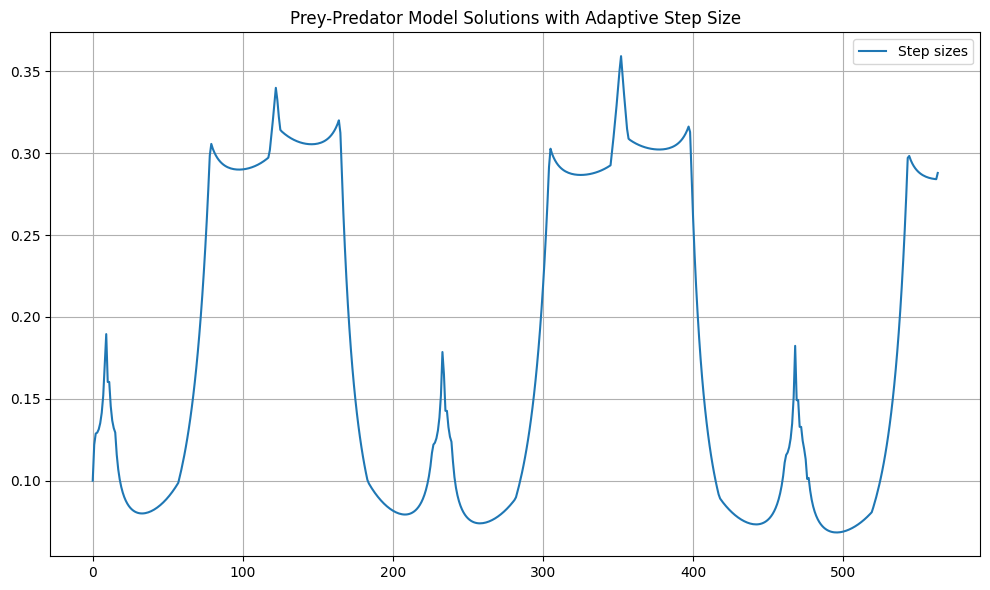

In [ ]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)
# Solve using Explicit Euler with adaptive step size
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 0], label='Adaptive Step Prey', linestyle=':', color='blue')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 1], label='Adaptive Step Predator', linestyle=':', color='orange')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Van der Pol problem

#### Explicit Euler with fixed step size = 0.1

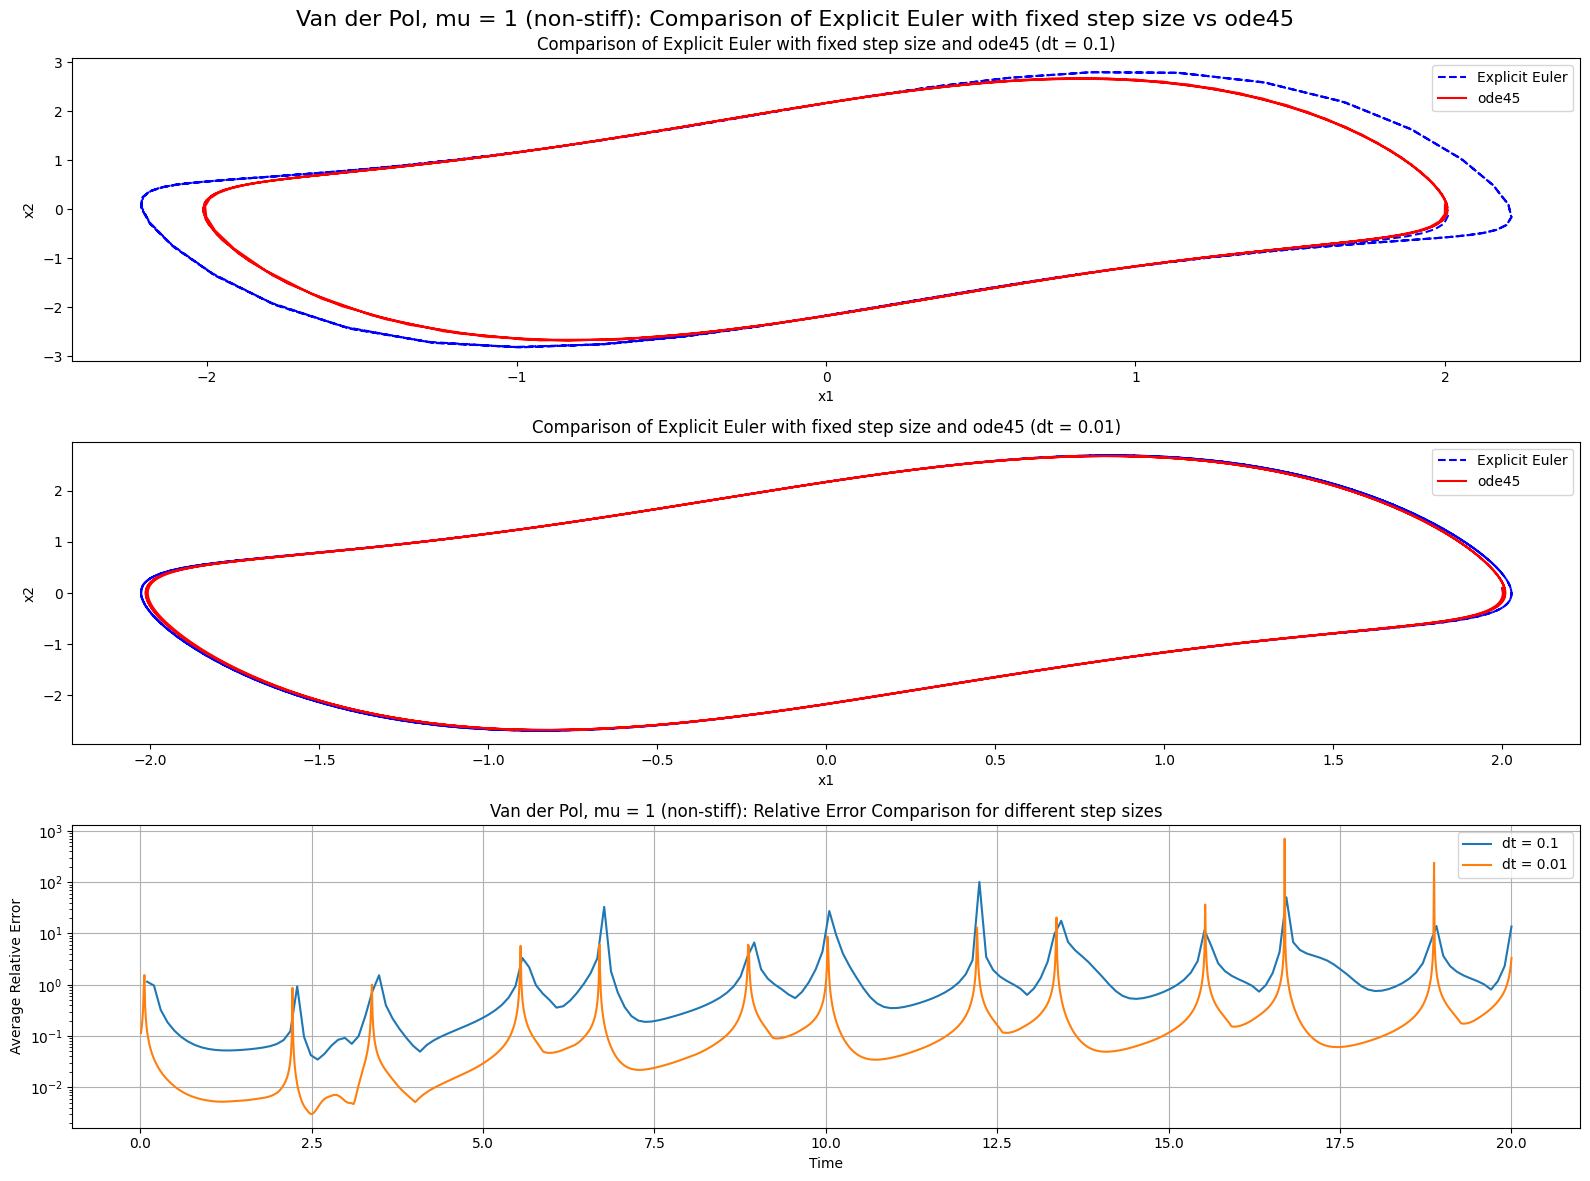

/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:35: RuntimeWarning: overflow encountered in scalar multiply
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:35: RuntimeWarning: overflow encountered in scalar power
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/Solvers.py:44: RuntimeWarning: invalid value encountered in add
  X[:,k] = X[:,k-1] + dt*fun(T[k-1], X[:,k-1], *args)


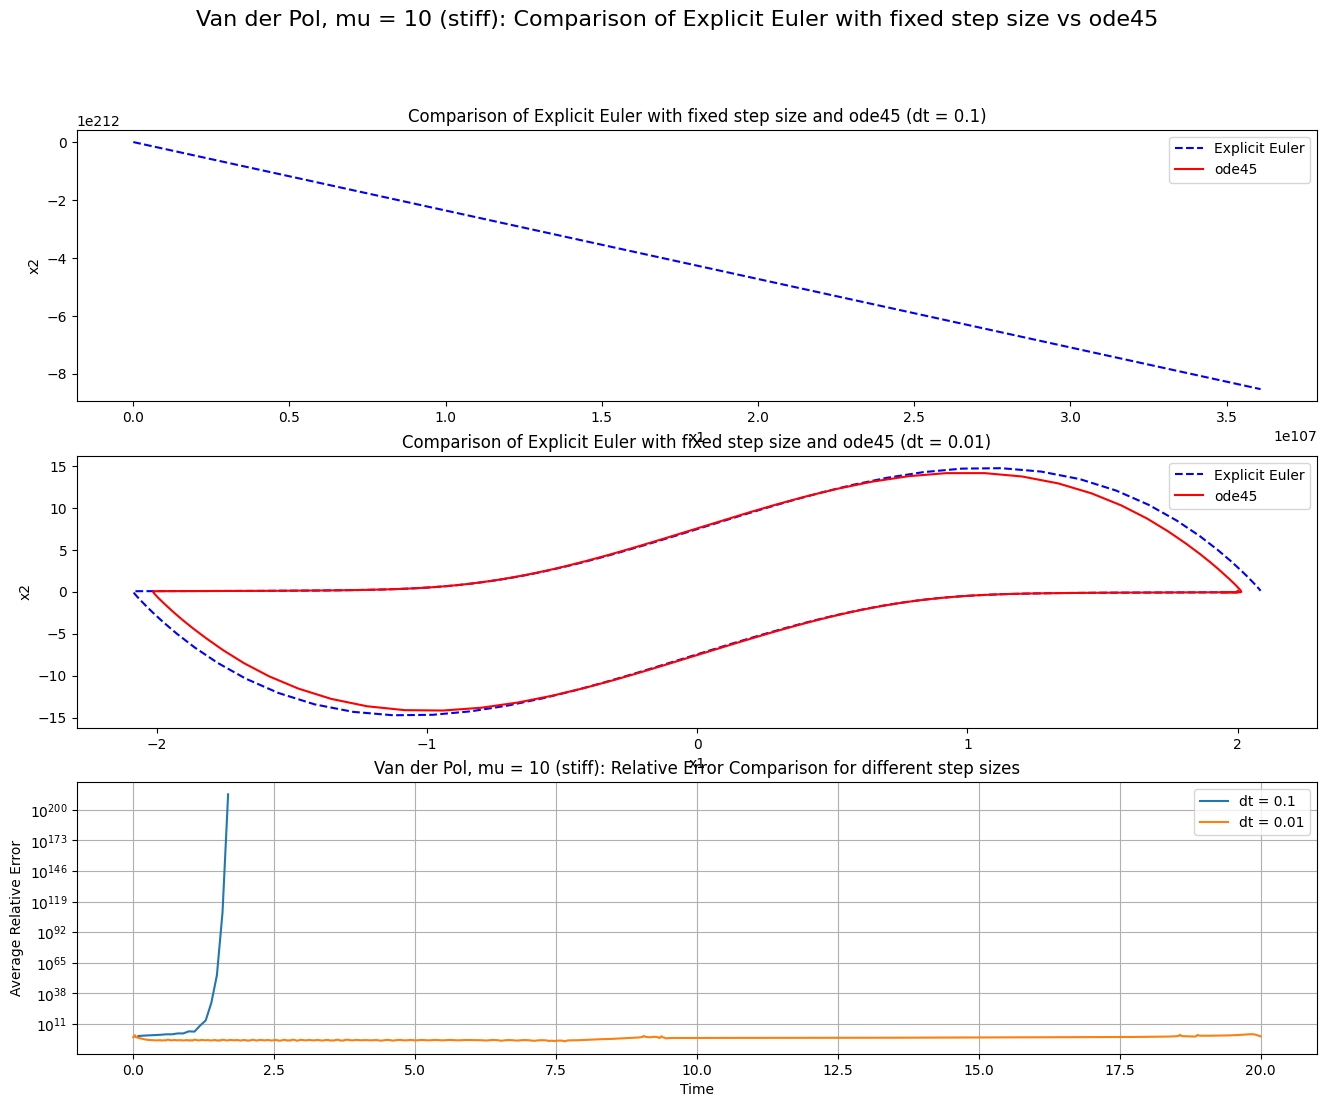

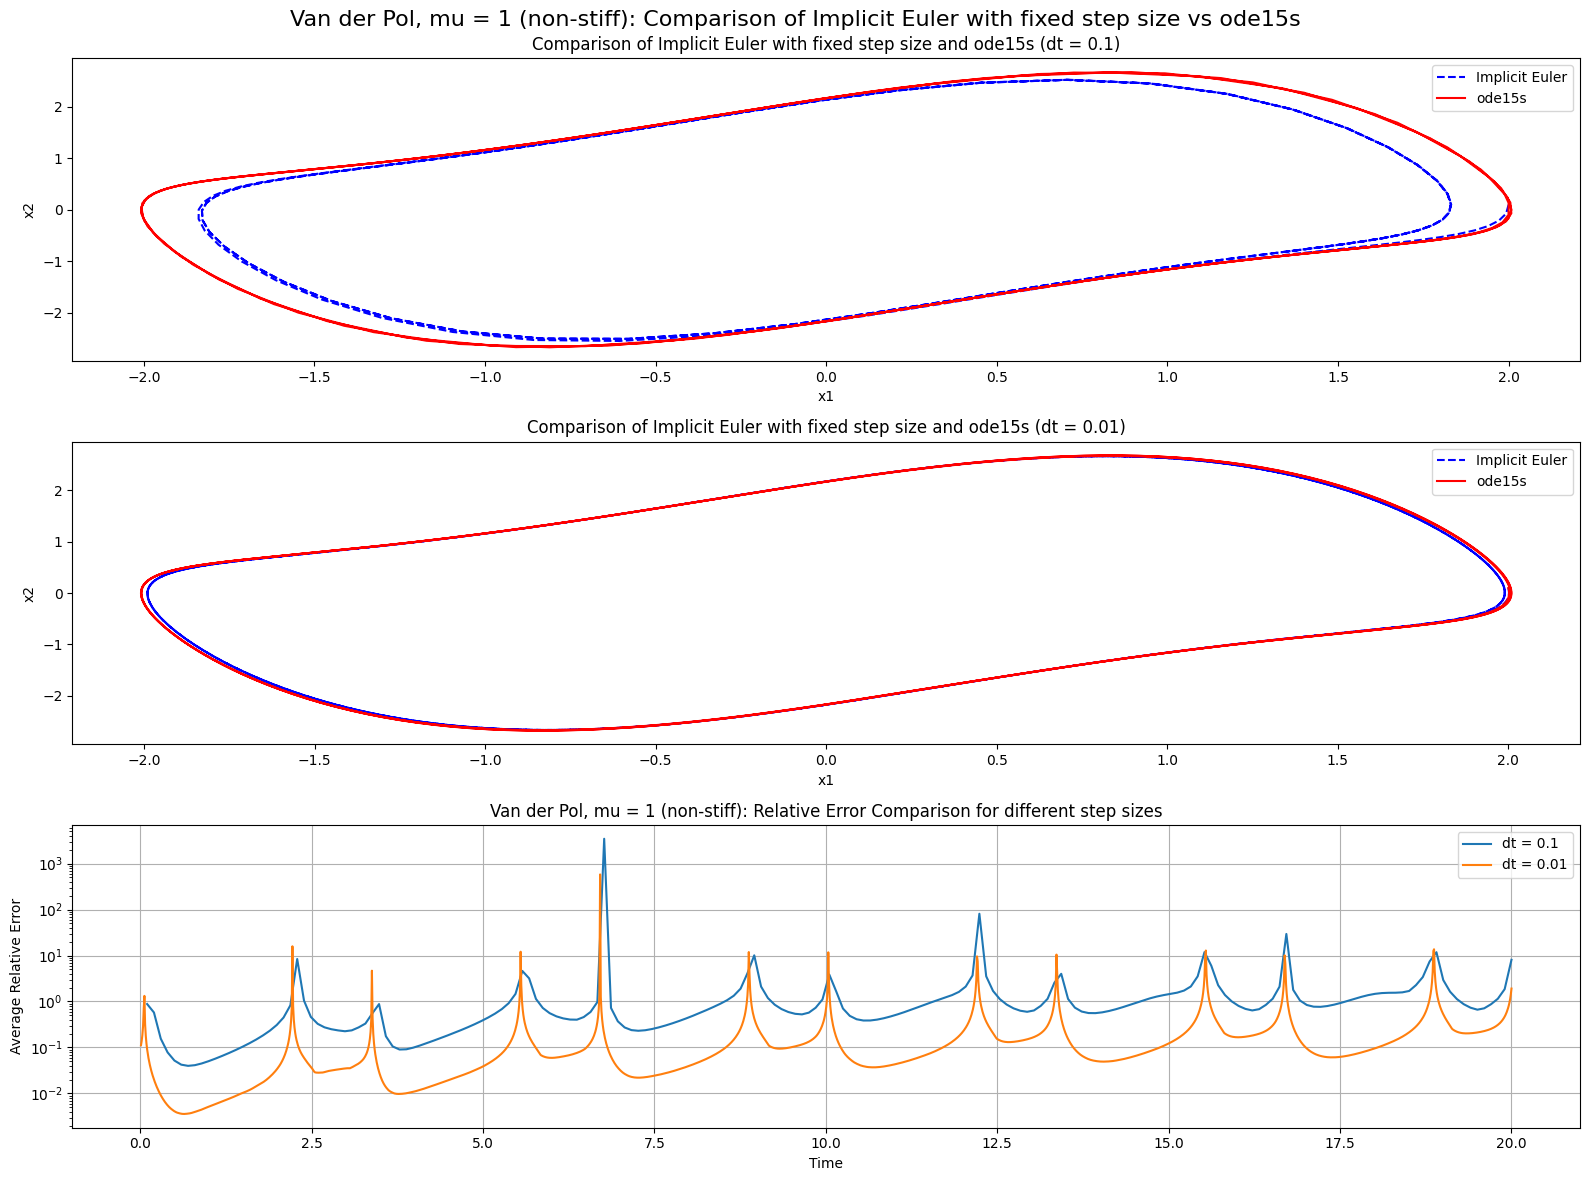

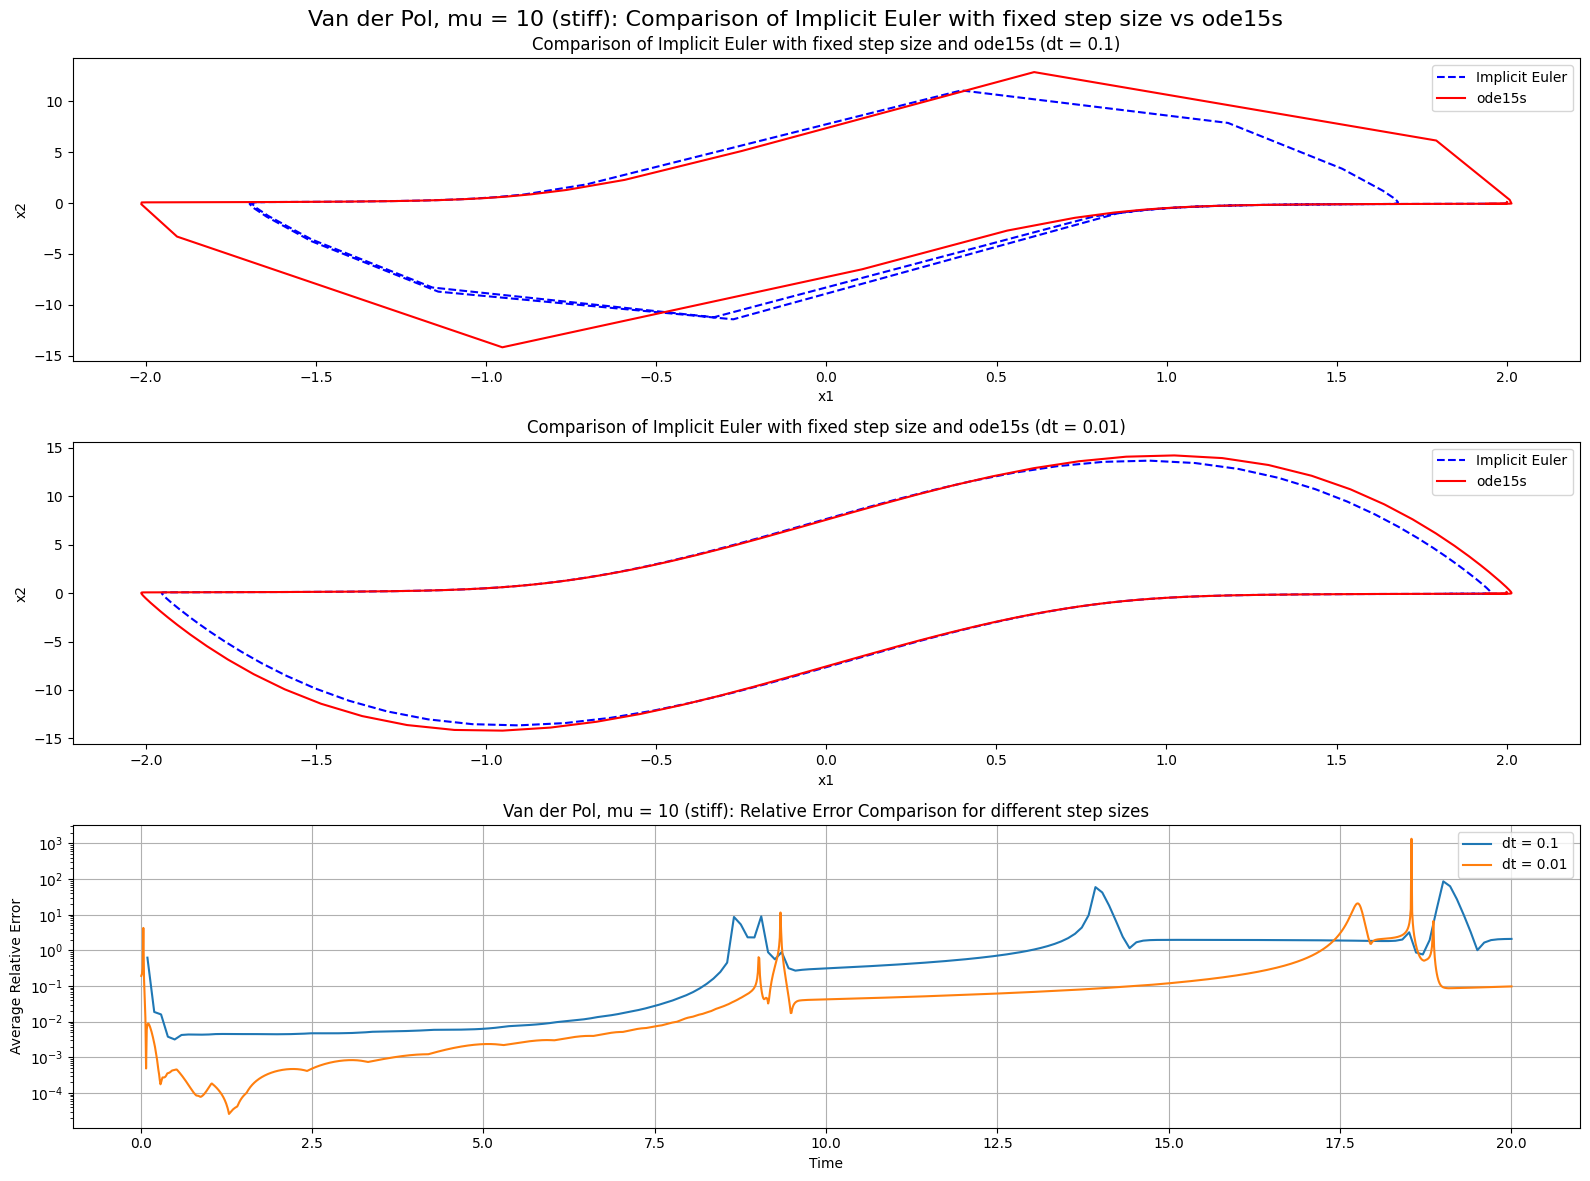

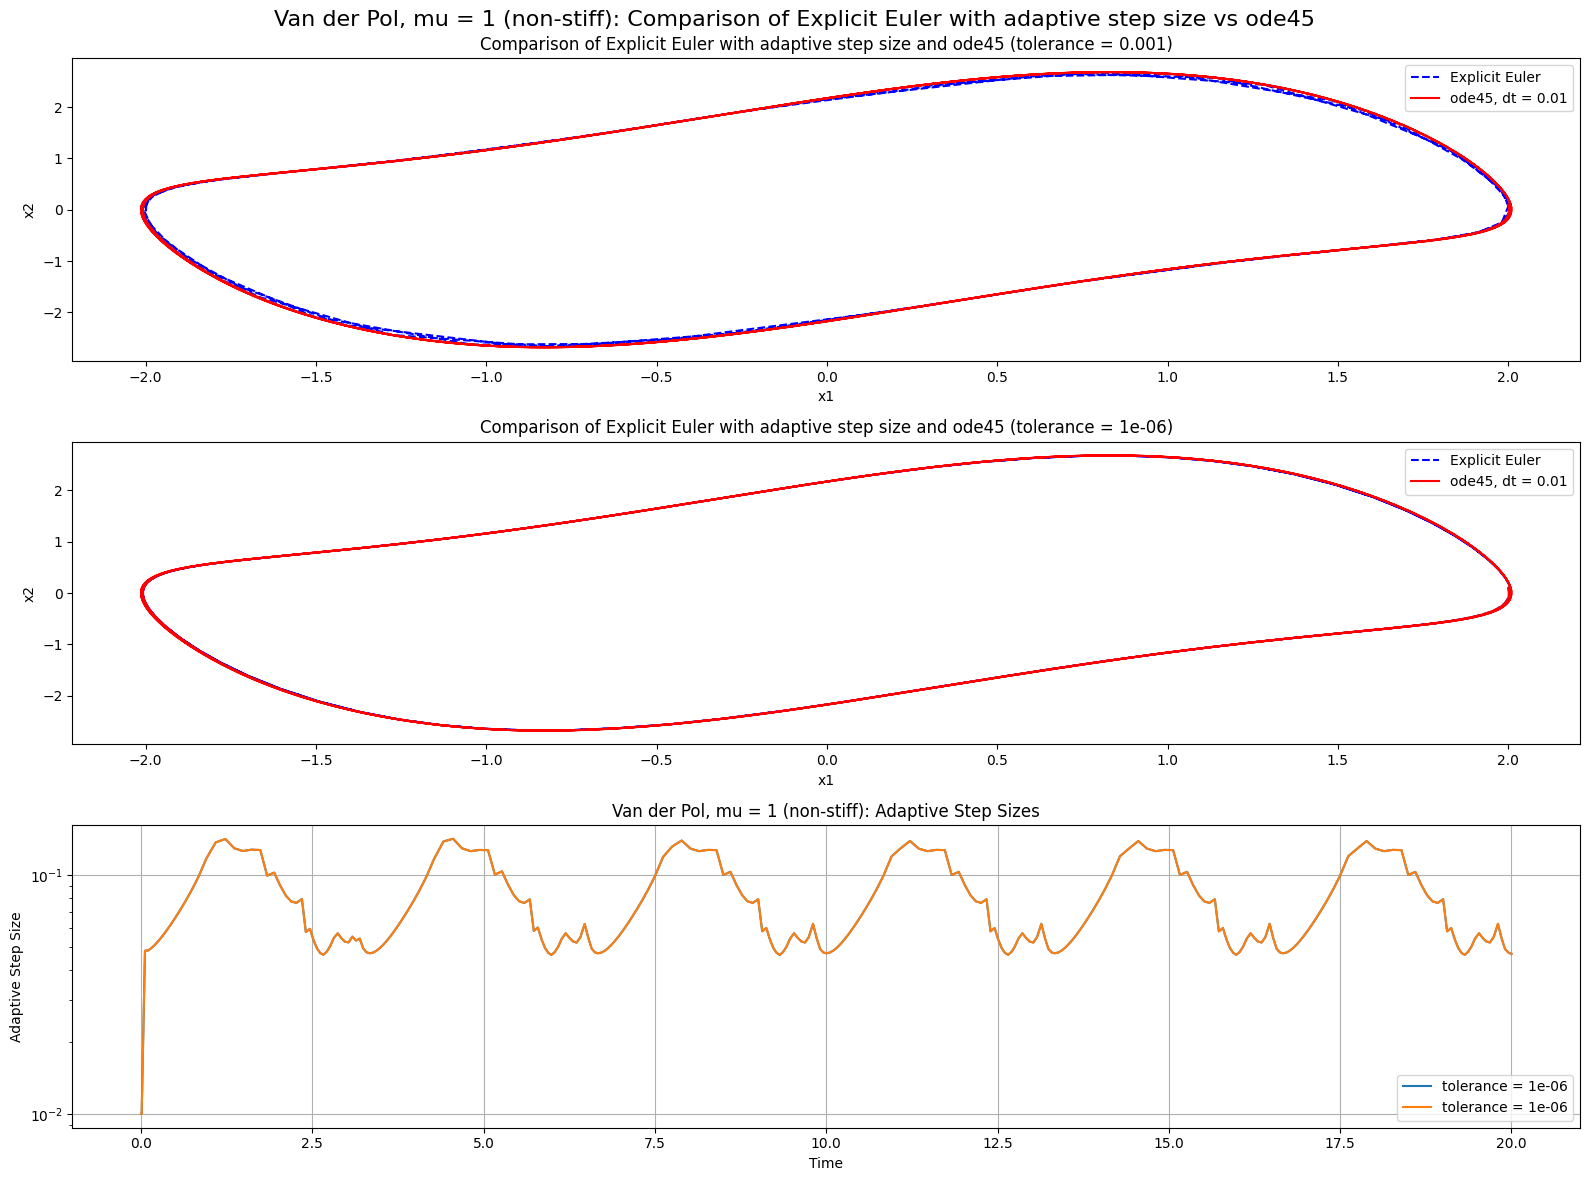

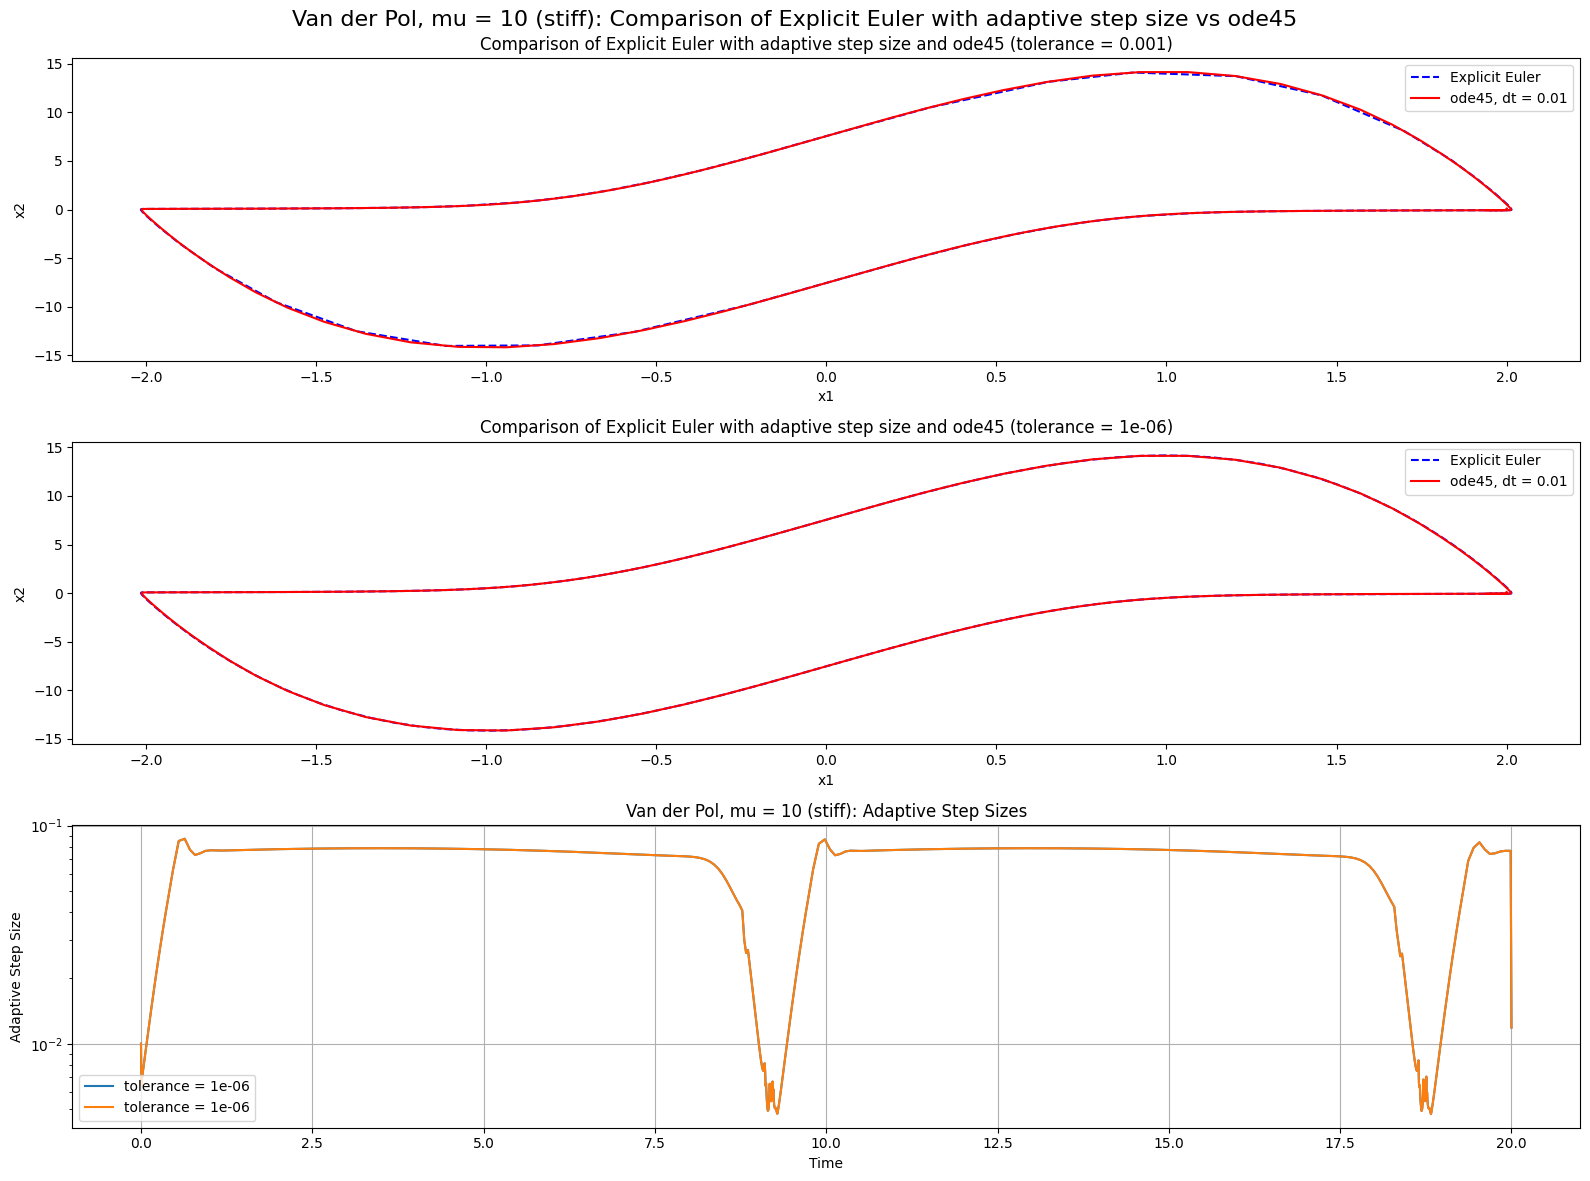

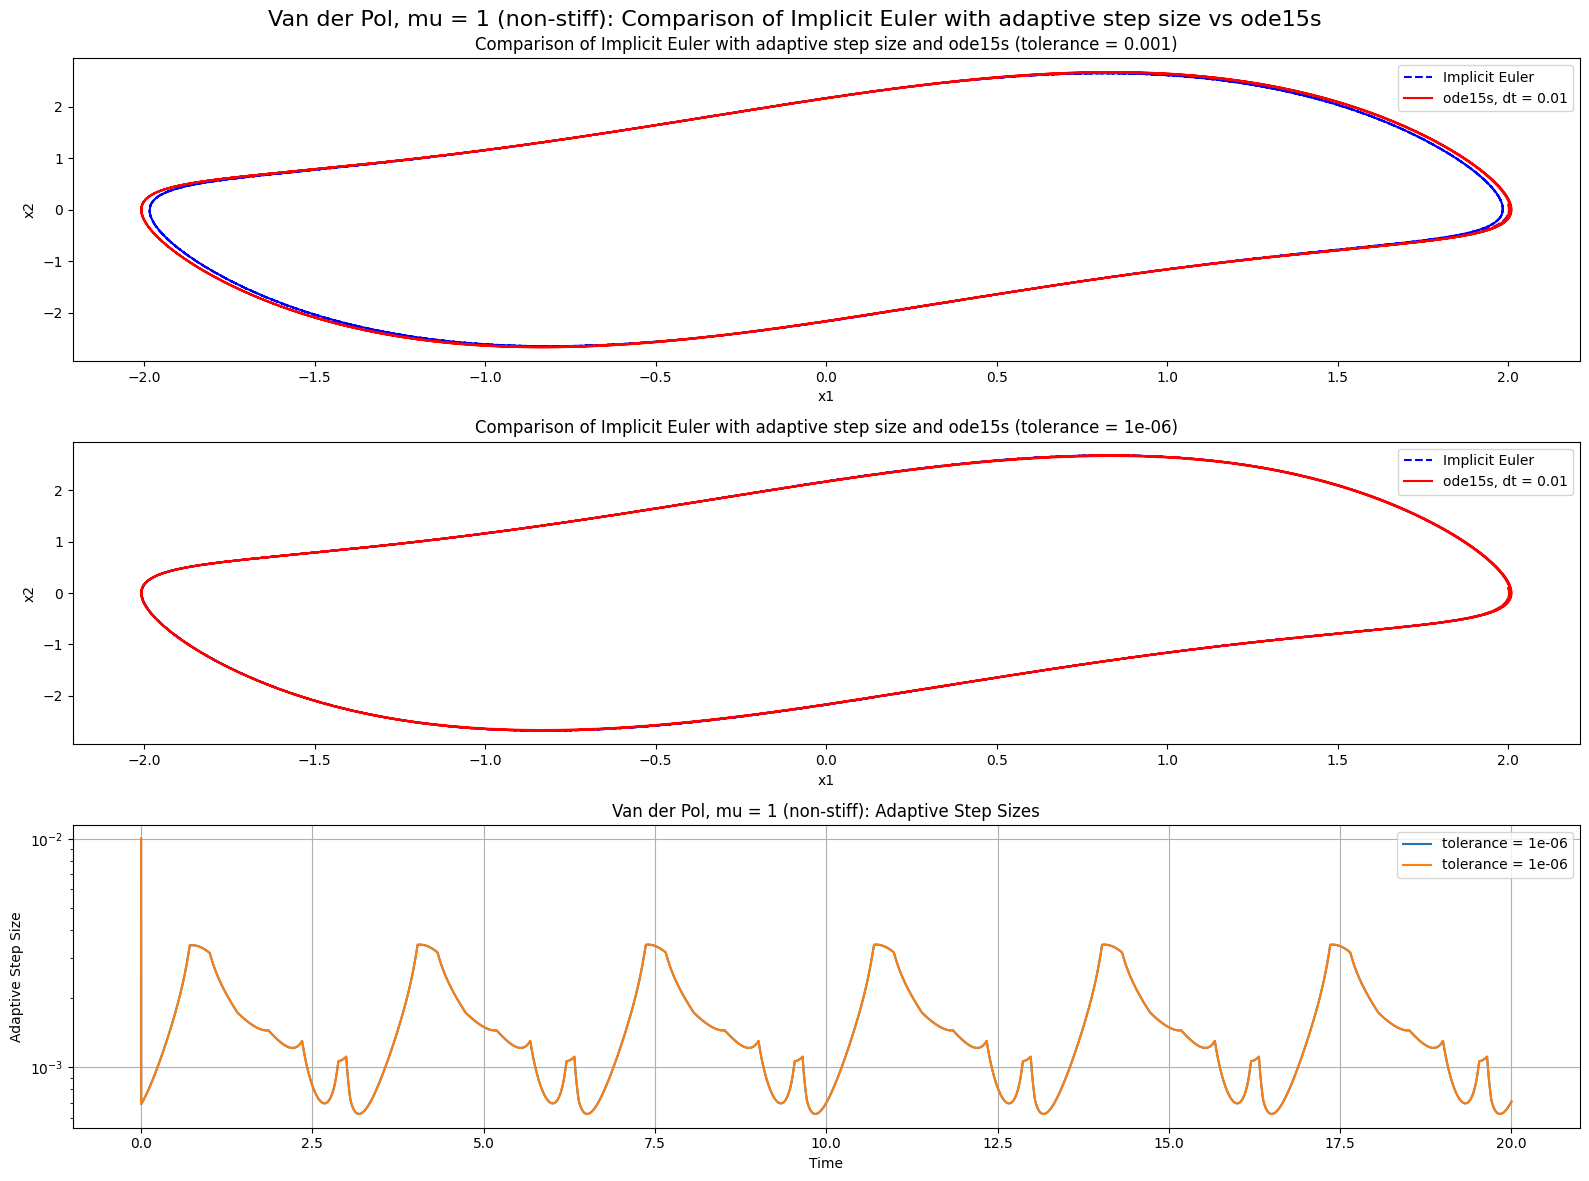

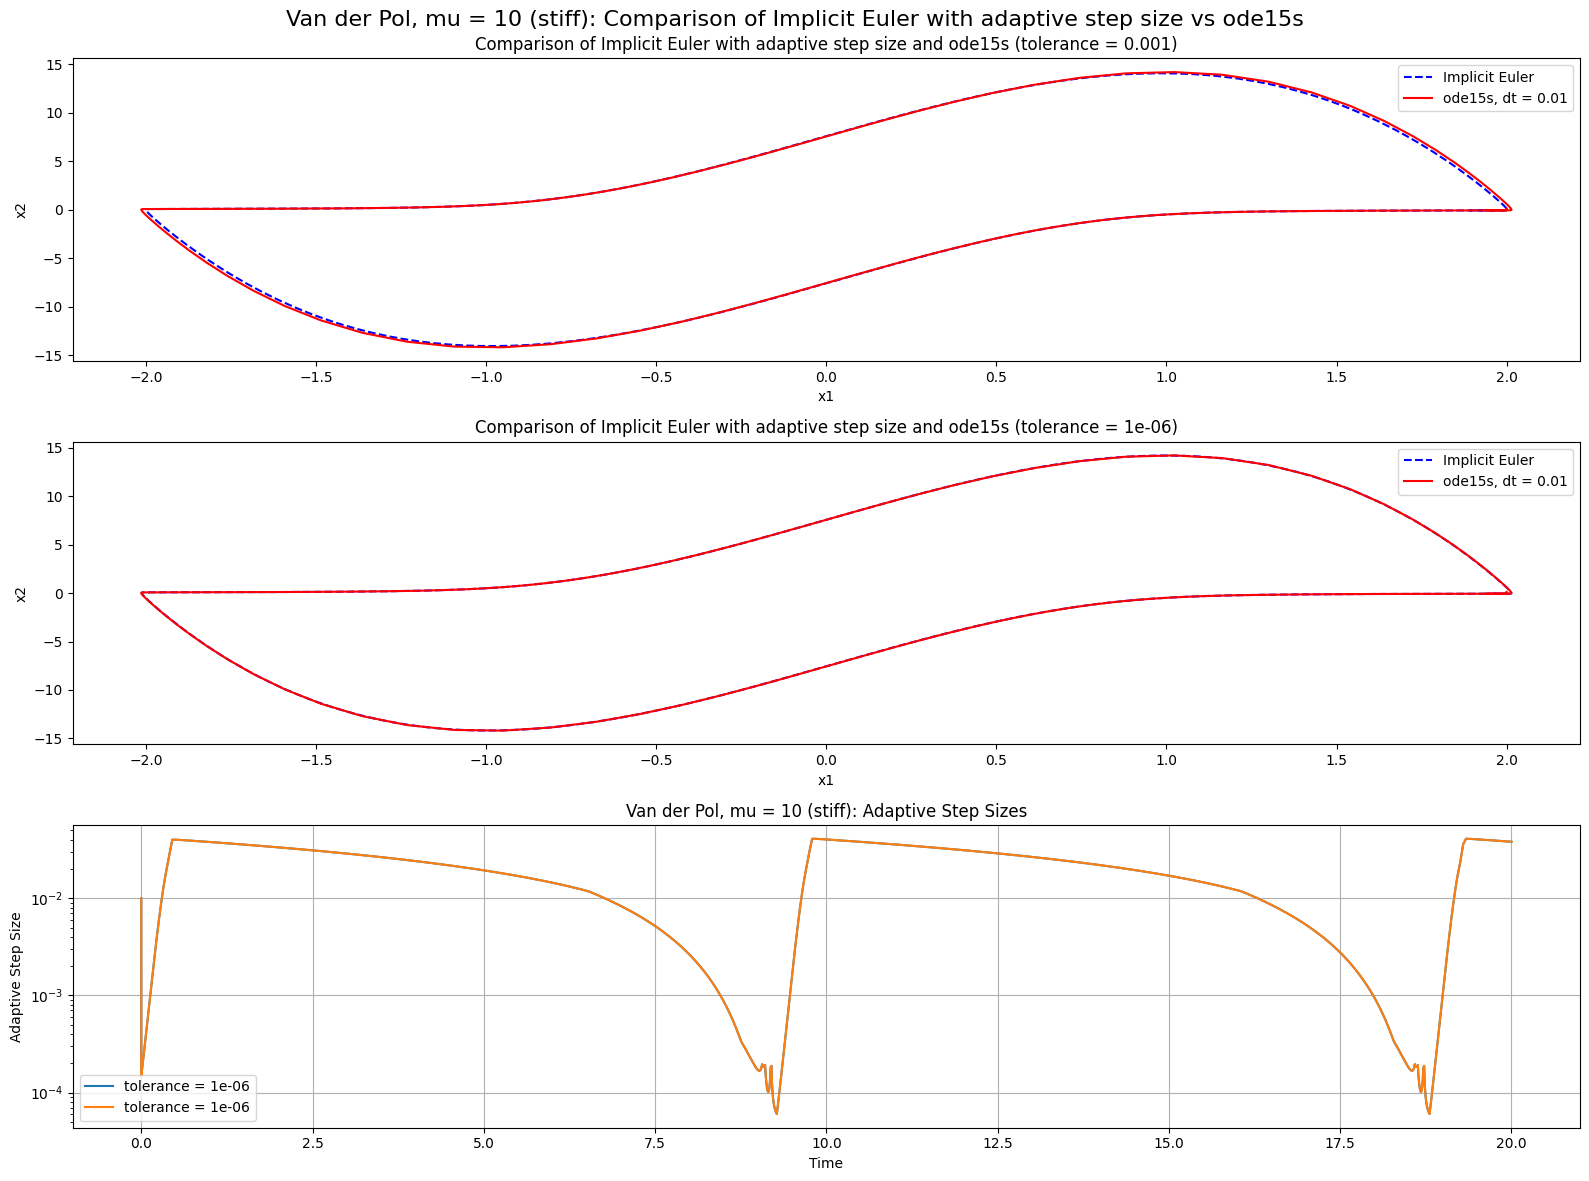

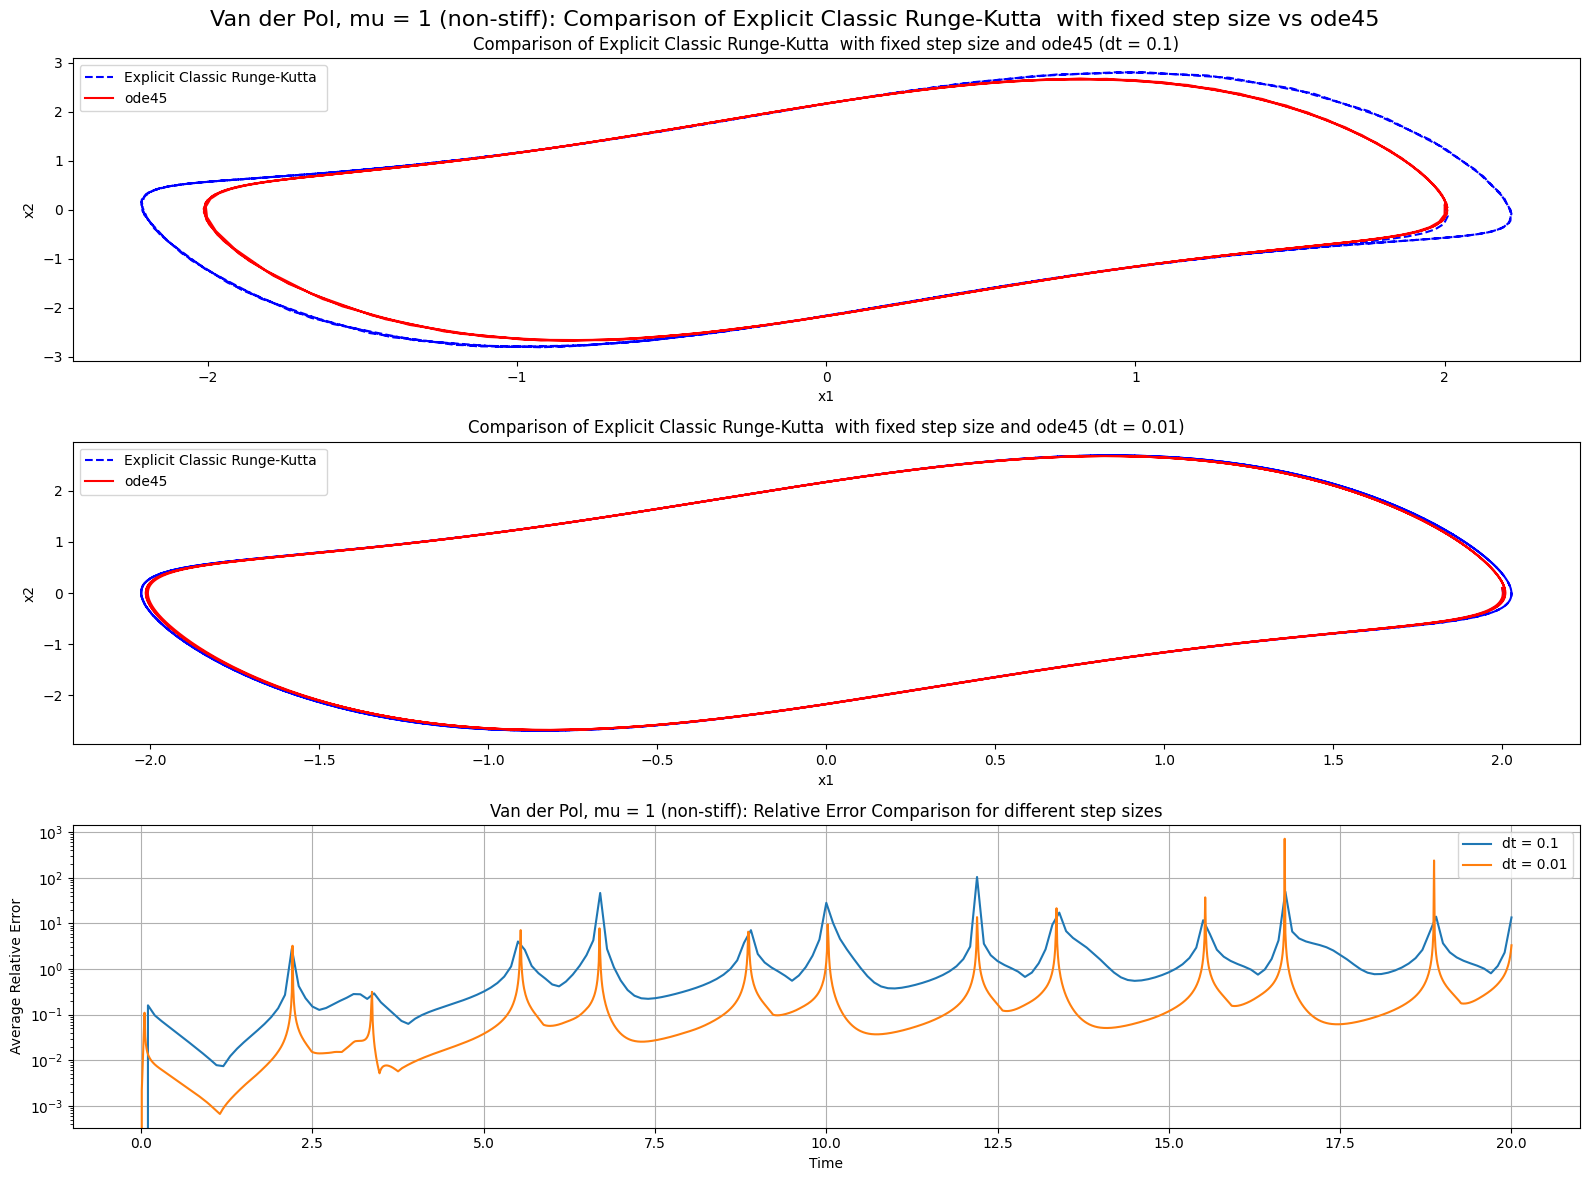

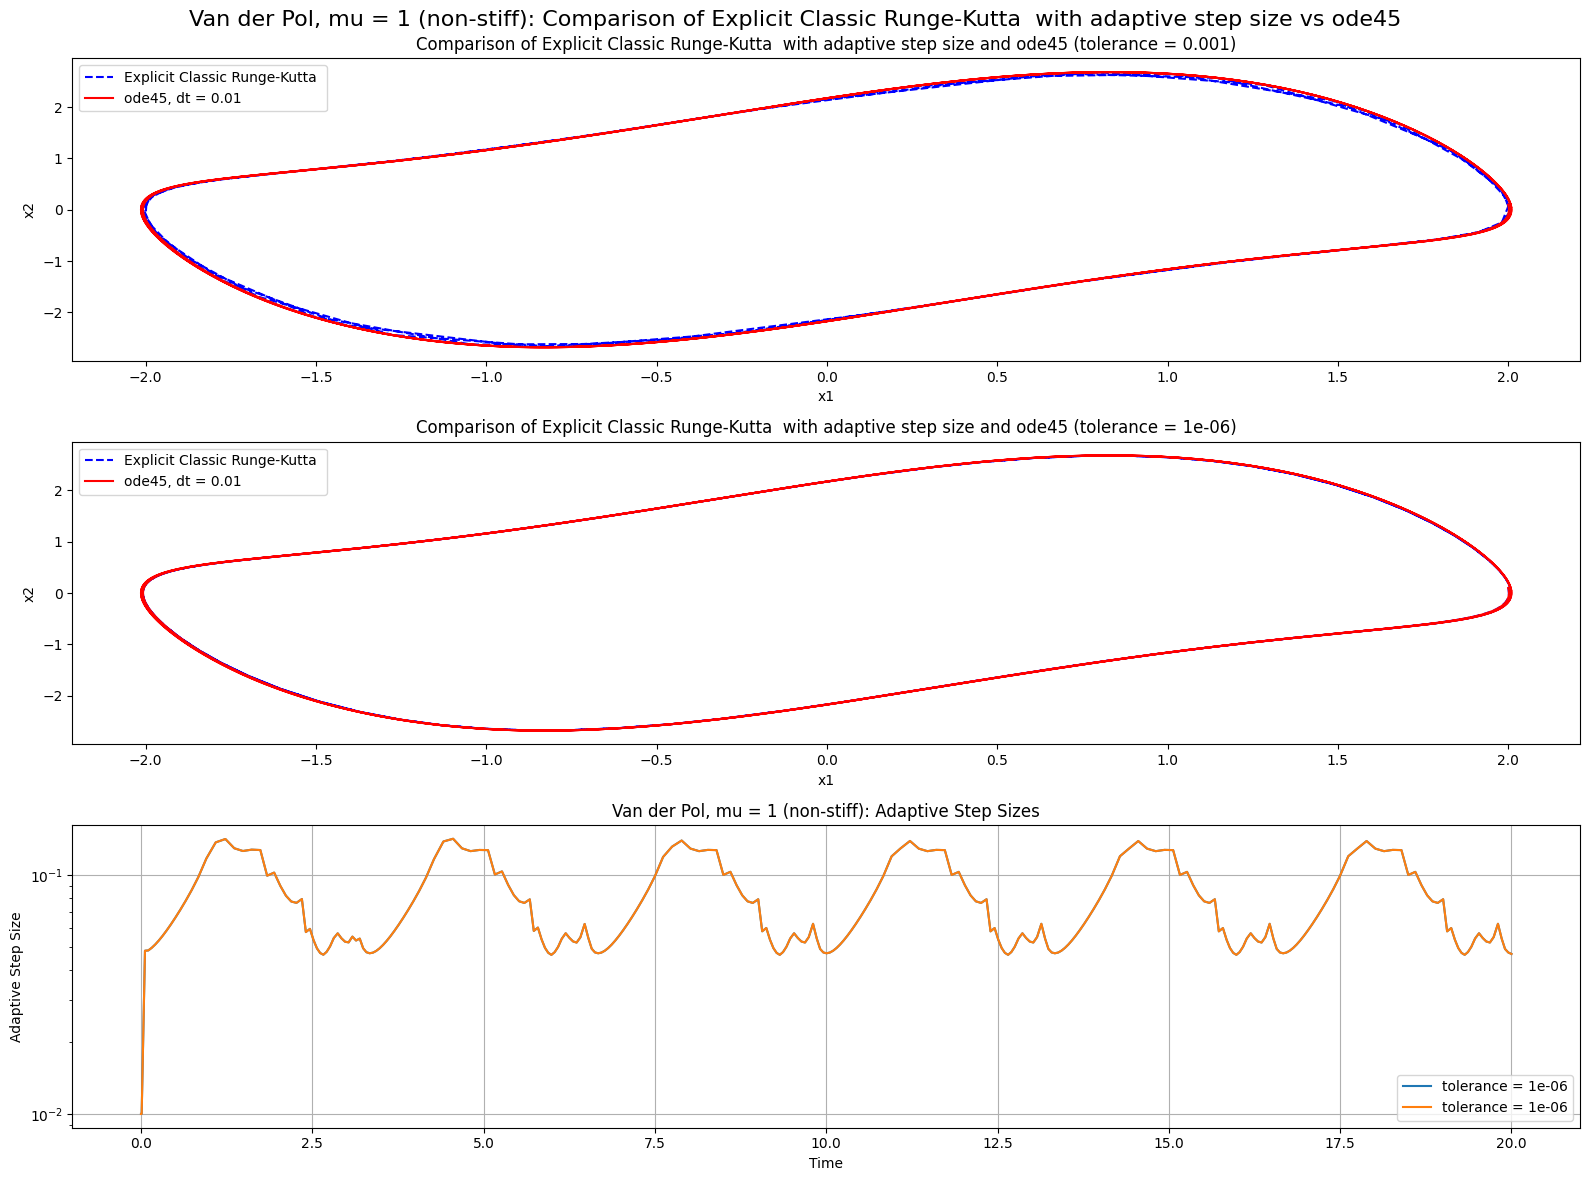

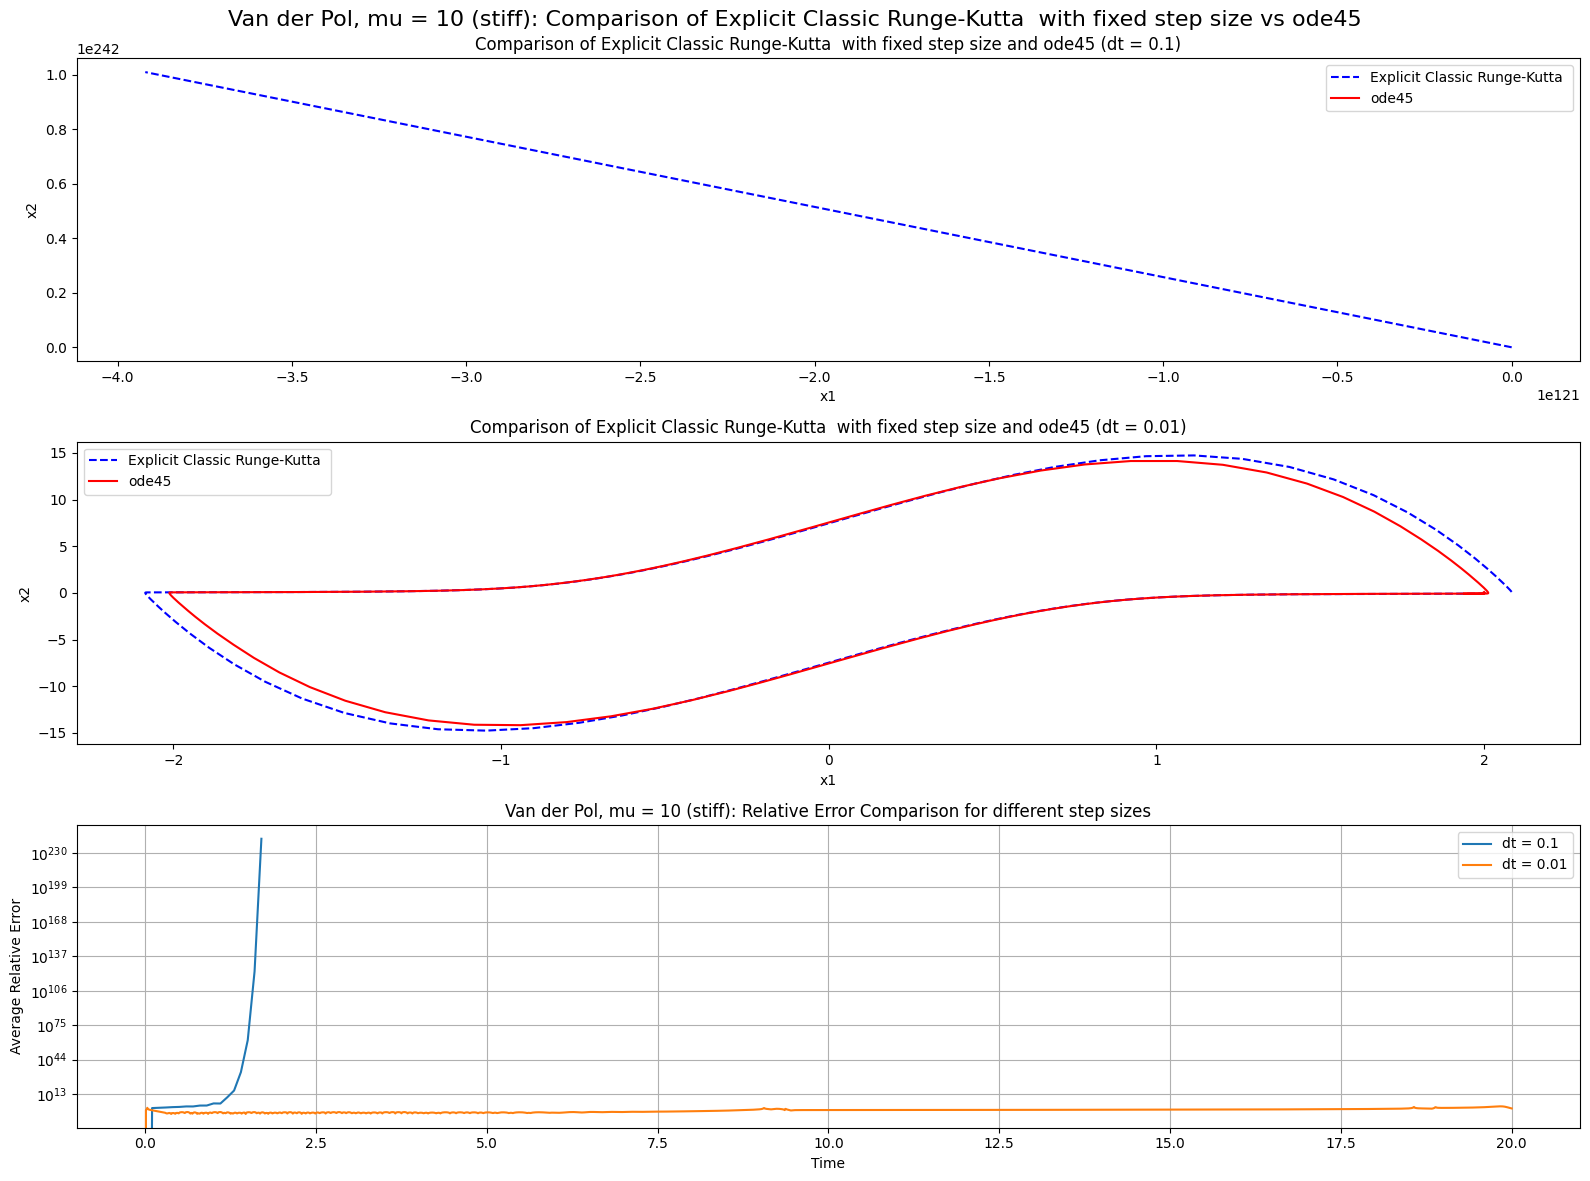

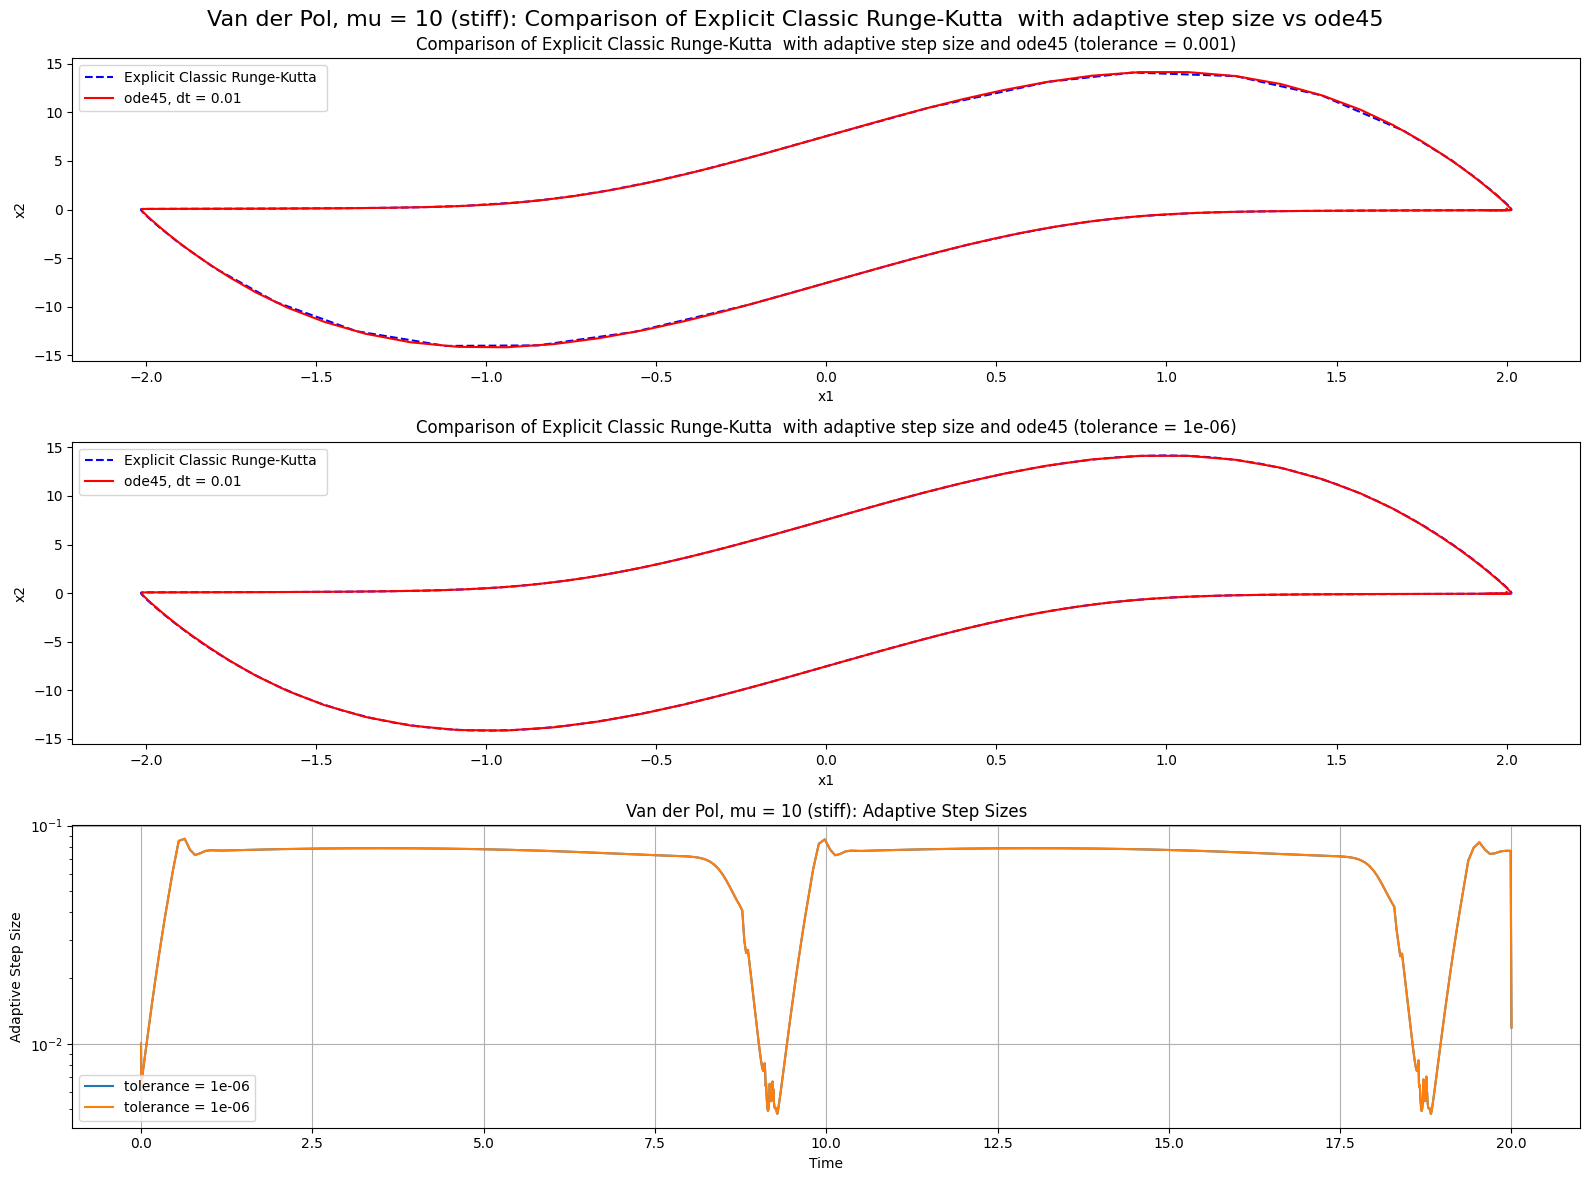

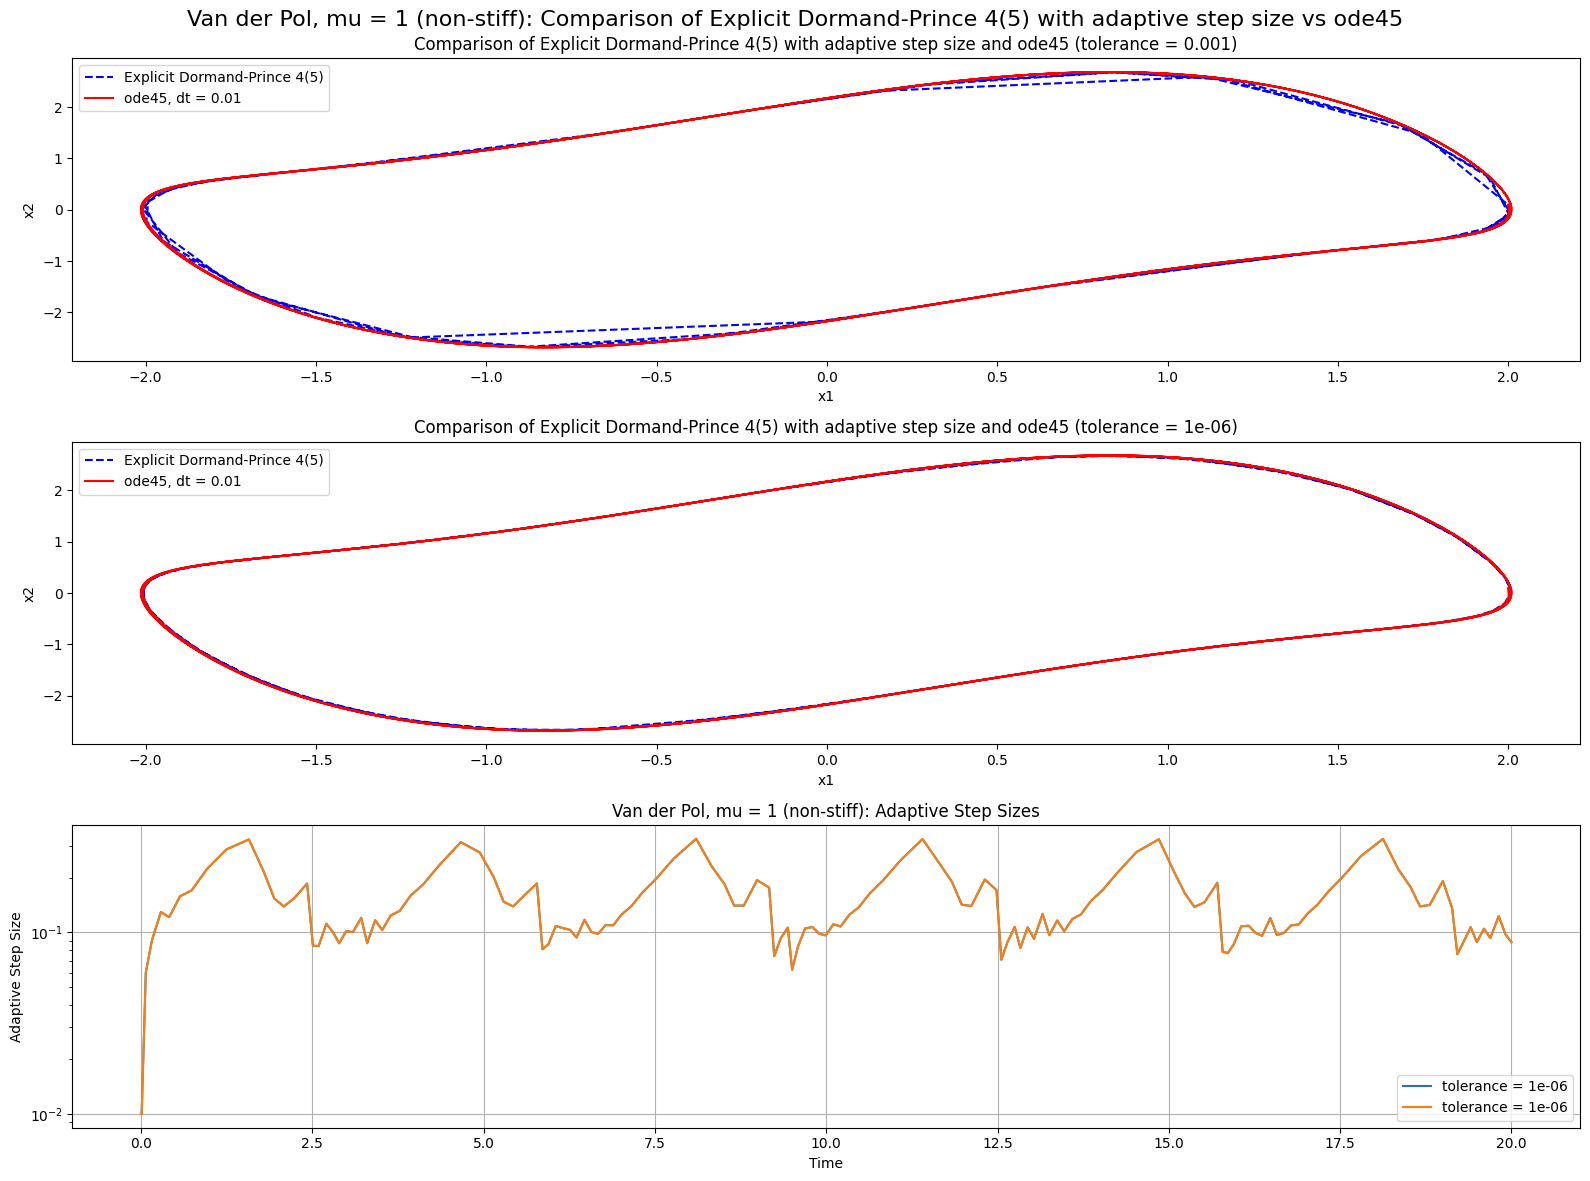

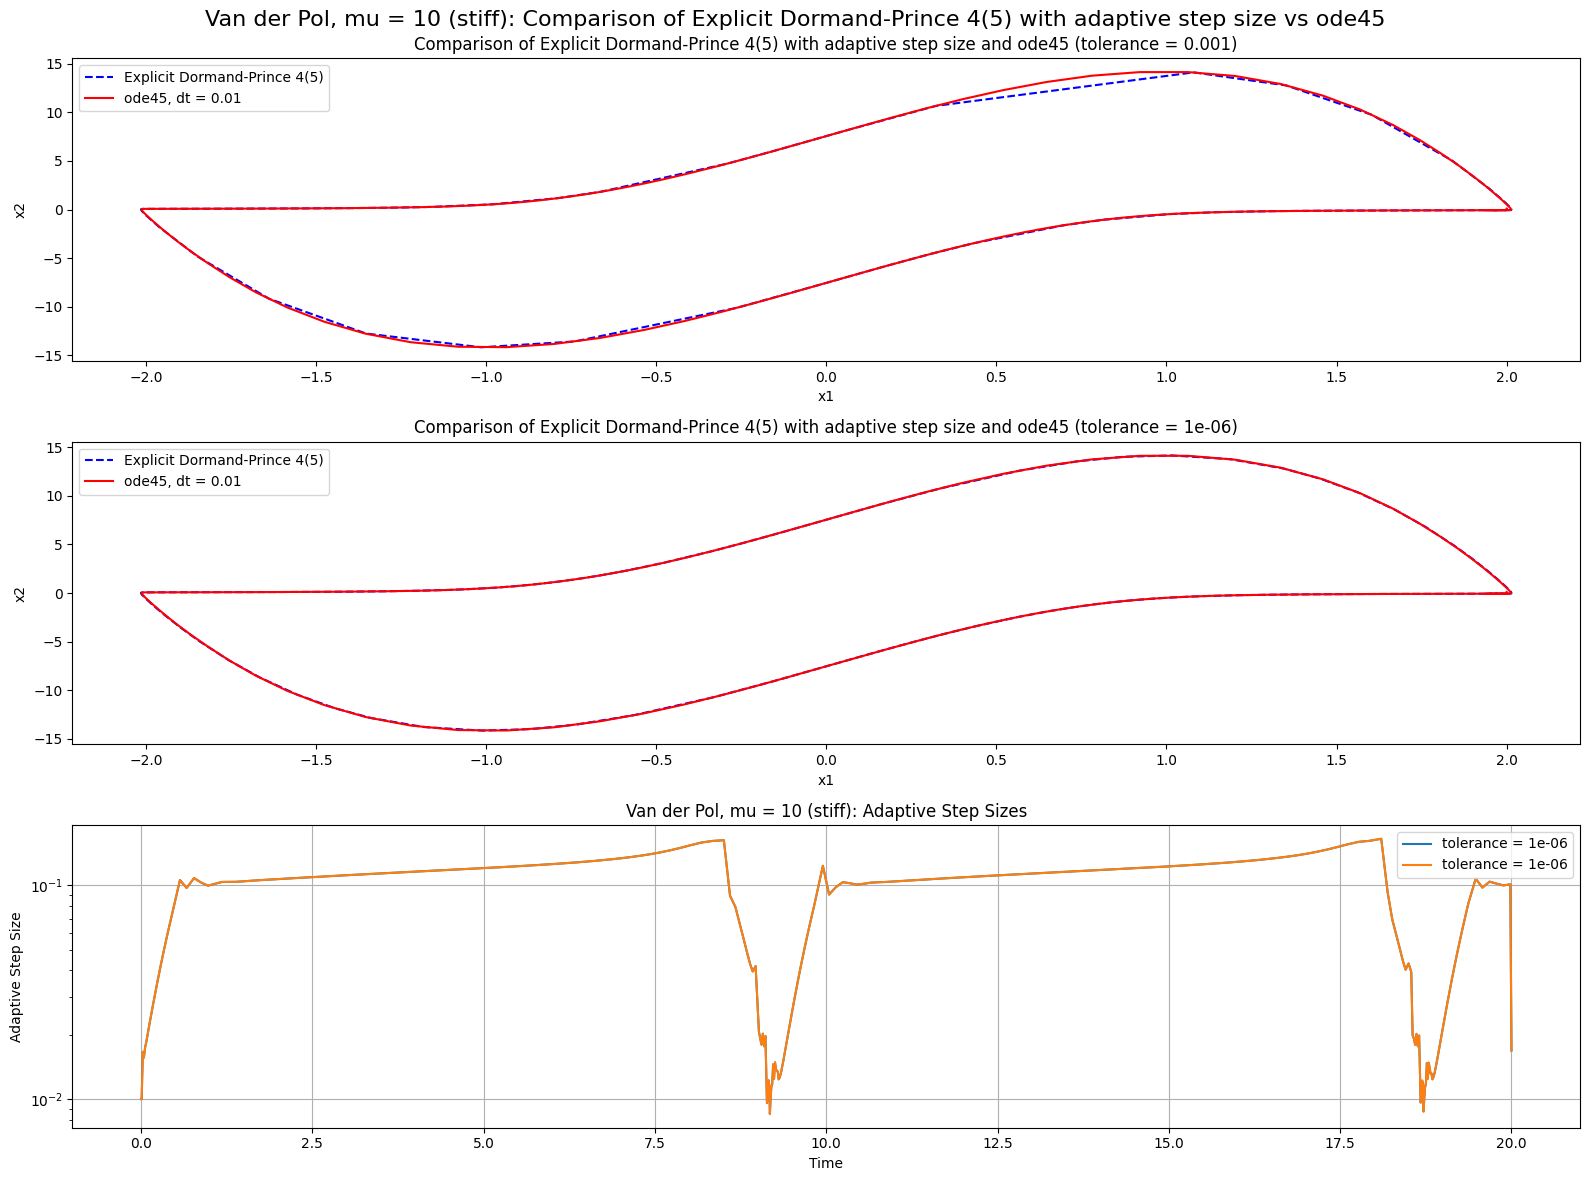

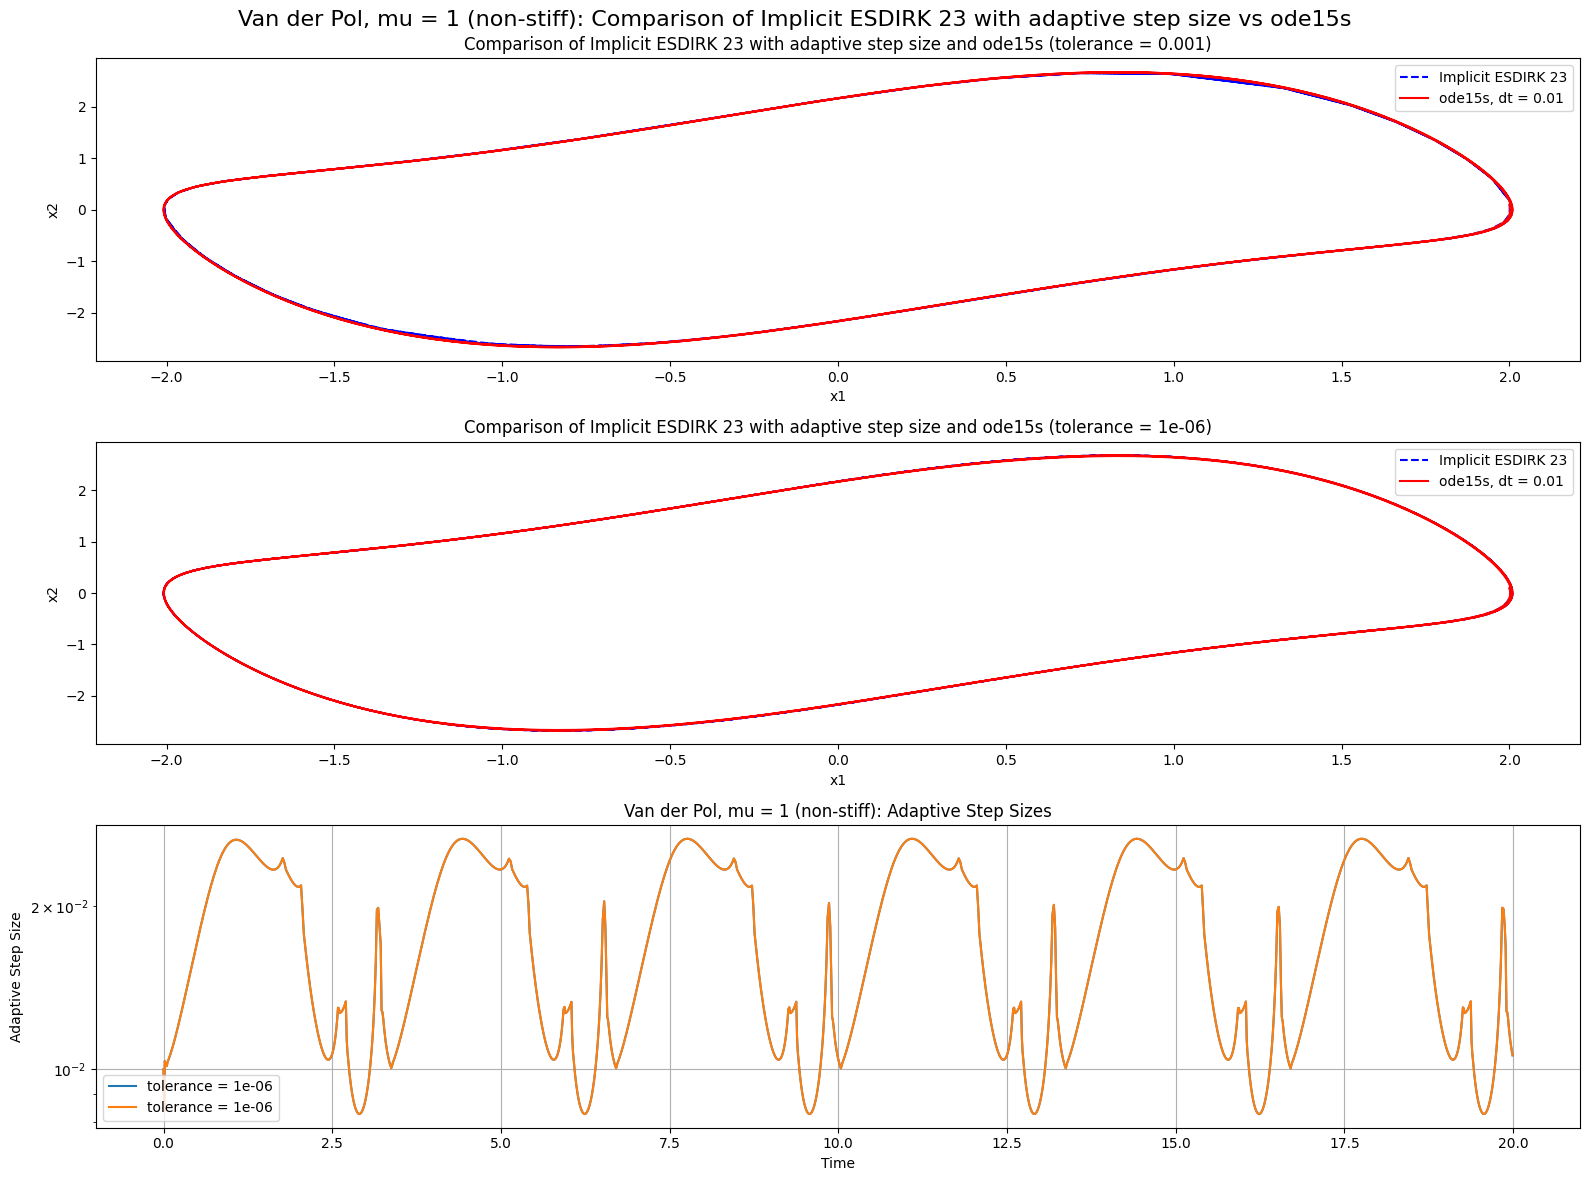

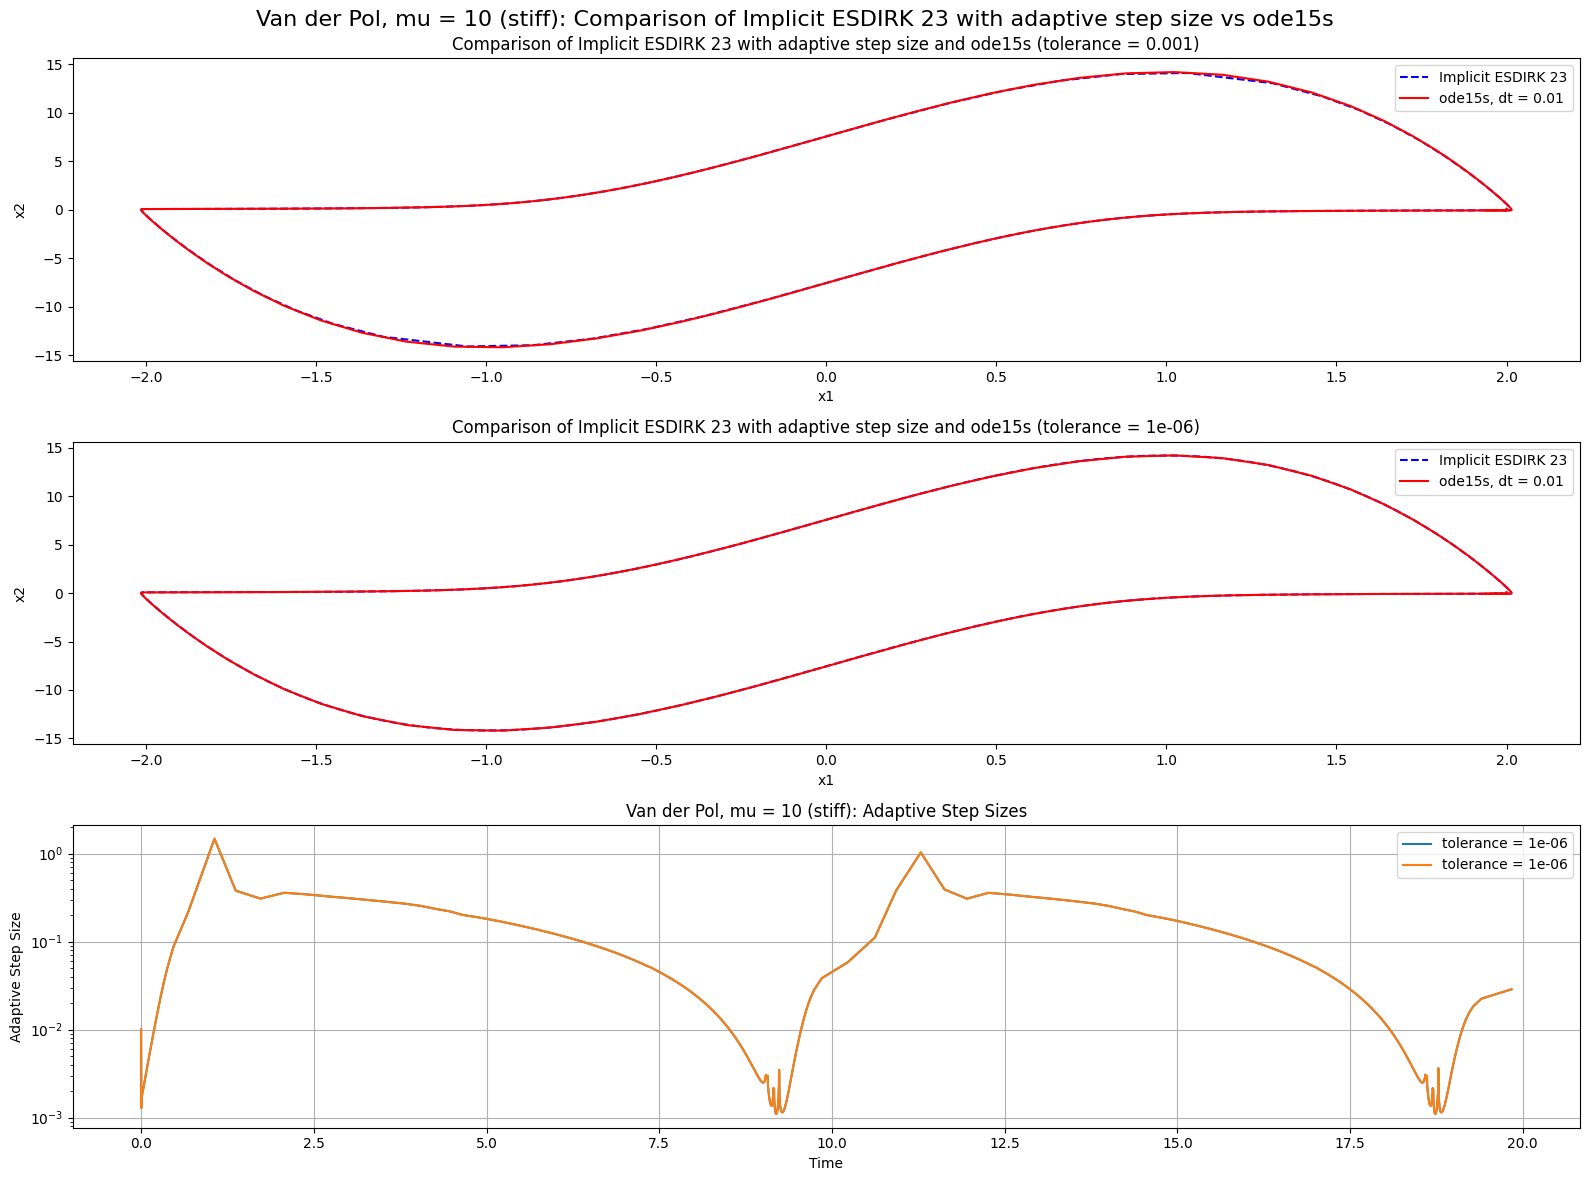

In [ ]:
# Define time span and initial conditions
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 10  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0.1])  # Initial condition


vp_exp_fixed_nonstifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode45", fixed_steps = True, explicit = True, euler = True)
vp_exp_fixed_stifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode45", fixed_steps = True, explicit = True, tight_layout=False, euler = True)
vp_imp_fixed_nonstifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode15s", fixed_steps = True, implicit=True, reference_solver='BDF', euler = True)
vp_imp_fixed_stifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode15s", fixed_steps = True, implicit=True, reference_solver='BDF', euler = True)
vp_exp_adaptive_nonstifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, explicit = True, euler = True)
vp_exp_adaptive_stifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, explicit = True, euler = True)
vp_imp_adaptive_nonstifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode15s", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, implicit=True, reference_solver='BDF', euler = True)
vp_imp_adaptive_stifff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode15s", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, implicit=True, reference_solver='BDF',euler = True)

vp_rk_fixed_nonstiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode45", fixed_steps = True, explicit = True, rk45 = True)
vp_rk_adaptive_nonstiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode45", adaptive_steps = True, steptype = "adaptive", explicit = True, rk45 = True, h0 = 0.01)
vp_rk_fixed_stiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode45", fixed_steps = True, explicit = True, rk45 = True)
vp_rk_adaptive_stiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode45", adaptive_steps = True,steptype = "adaptive", explicit = True, rk45 = True, h0 = 0.01)

vp_dopri_adaptive_nonstiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode45", adaptive_steps = True, steptype = "adaptive", explicit = True, dopri = True, h0 = 0.01)
vp_dopri_adaptive_stiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode45", adaptive_steps = True, steptype = "adaptive", explicit = True, dopri = True, h0 = 0.01)

vp_ed_adaptive_nonstiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = f"Van der Pol, mu = {mu_nonstiff} (non-stiff)", reference_solver_name="ode15s", adaptive_steps = True, steptype = "adaptive", implicit=True, reference_solver='BDF', esdirk = True, h0 = 0.01)
vp_ed_adaptive_stiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = f"Van der Pol, mu = {mu_stiff} (stiff)", reference_solver_name="ode15s", adaptive_steps = True, steptype = "adaptive", implicit=True, reference_solver='BDF', esdirk = True, h0 = 0.01)

In [ ]:
compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = "Van der Pol, mu = 100 (stiff)", reference_solver_name="ode45", tight_layout=False)

/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:35: RuntimeWarning: overflow encountered in scalar multiply
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:35: RuntimeWarning: overflow encountered in scalar power
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/Solvers.py:44: RuntimeWarning: invalid value encountered in add
  X[:,k] = X[:,k-1] + dt*fun(T[k-1], X[:,k-1], *args)
/var/folders/v_/bb7dt9w12158g8xjfpl9dzfc0000gn/T/ipykernel_25438/2495684626.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.abs(y - y_exact)/np.abs(y_exact)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/ticker.py:2468: RuntimeW

OverflowError: cannot convert float infinity to integer

<Figure size 1600x1200 with 3 Axes>

{0.1: {'ref_sol':   message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-01 ...  1.990e+01  2.000e+01]
          y: [[ 2.000e+00  1.999e+00 ...  1.859e+00  1.858e+00]
              [ 0.000e+00 -6.674e-03 ... -7.565e-03 -7.573e-03]]
        sol: None
   t_events: None
   y_events: None
       nfev: 11246
       njev: 0
        nlu: 0,
  'euler_t': array([ 0.        ,  0.09950249,  0.19900498,  0.29850746,  0.39800995,
          0.49751244,  0.59701493,  0.69651741,  0.7960199 ,  0.89552239,
          0.99502488,  1.09452736,  1.19402985,  1.29353234,  1.39303483,
          1.49253731,  1.5920398 ,  1.69154229,  1.79104478,  1.89054726,
          1.99004975,  2.08955224,  2.18905473,  2.28855721,  2.3880597 ,
          2.48756219,  2.58706468,  2.68656716,  2.78606965,  2.88557214,
          2.98507463,  3.08457711,  3.1840796 ,  3.28358209,  3.38308458,
          3.48258706,  3.58208955,  3.681592

/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:28: RuntimeWarning: overflow encountered in scalar multiply
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:28: RuntimeWarning: overflow encountered in scalar power
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/Solvers.py:20: RuntimeWarning: invalid value encountered in add
  X[:,k] = X[:,k-1] + dt*fun(T[k-1], X[:,k-1], *args)


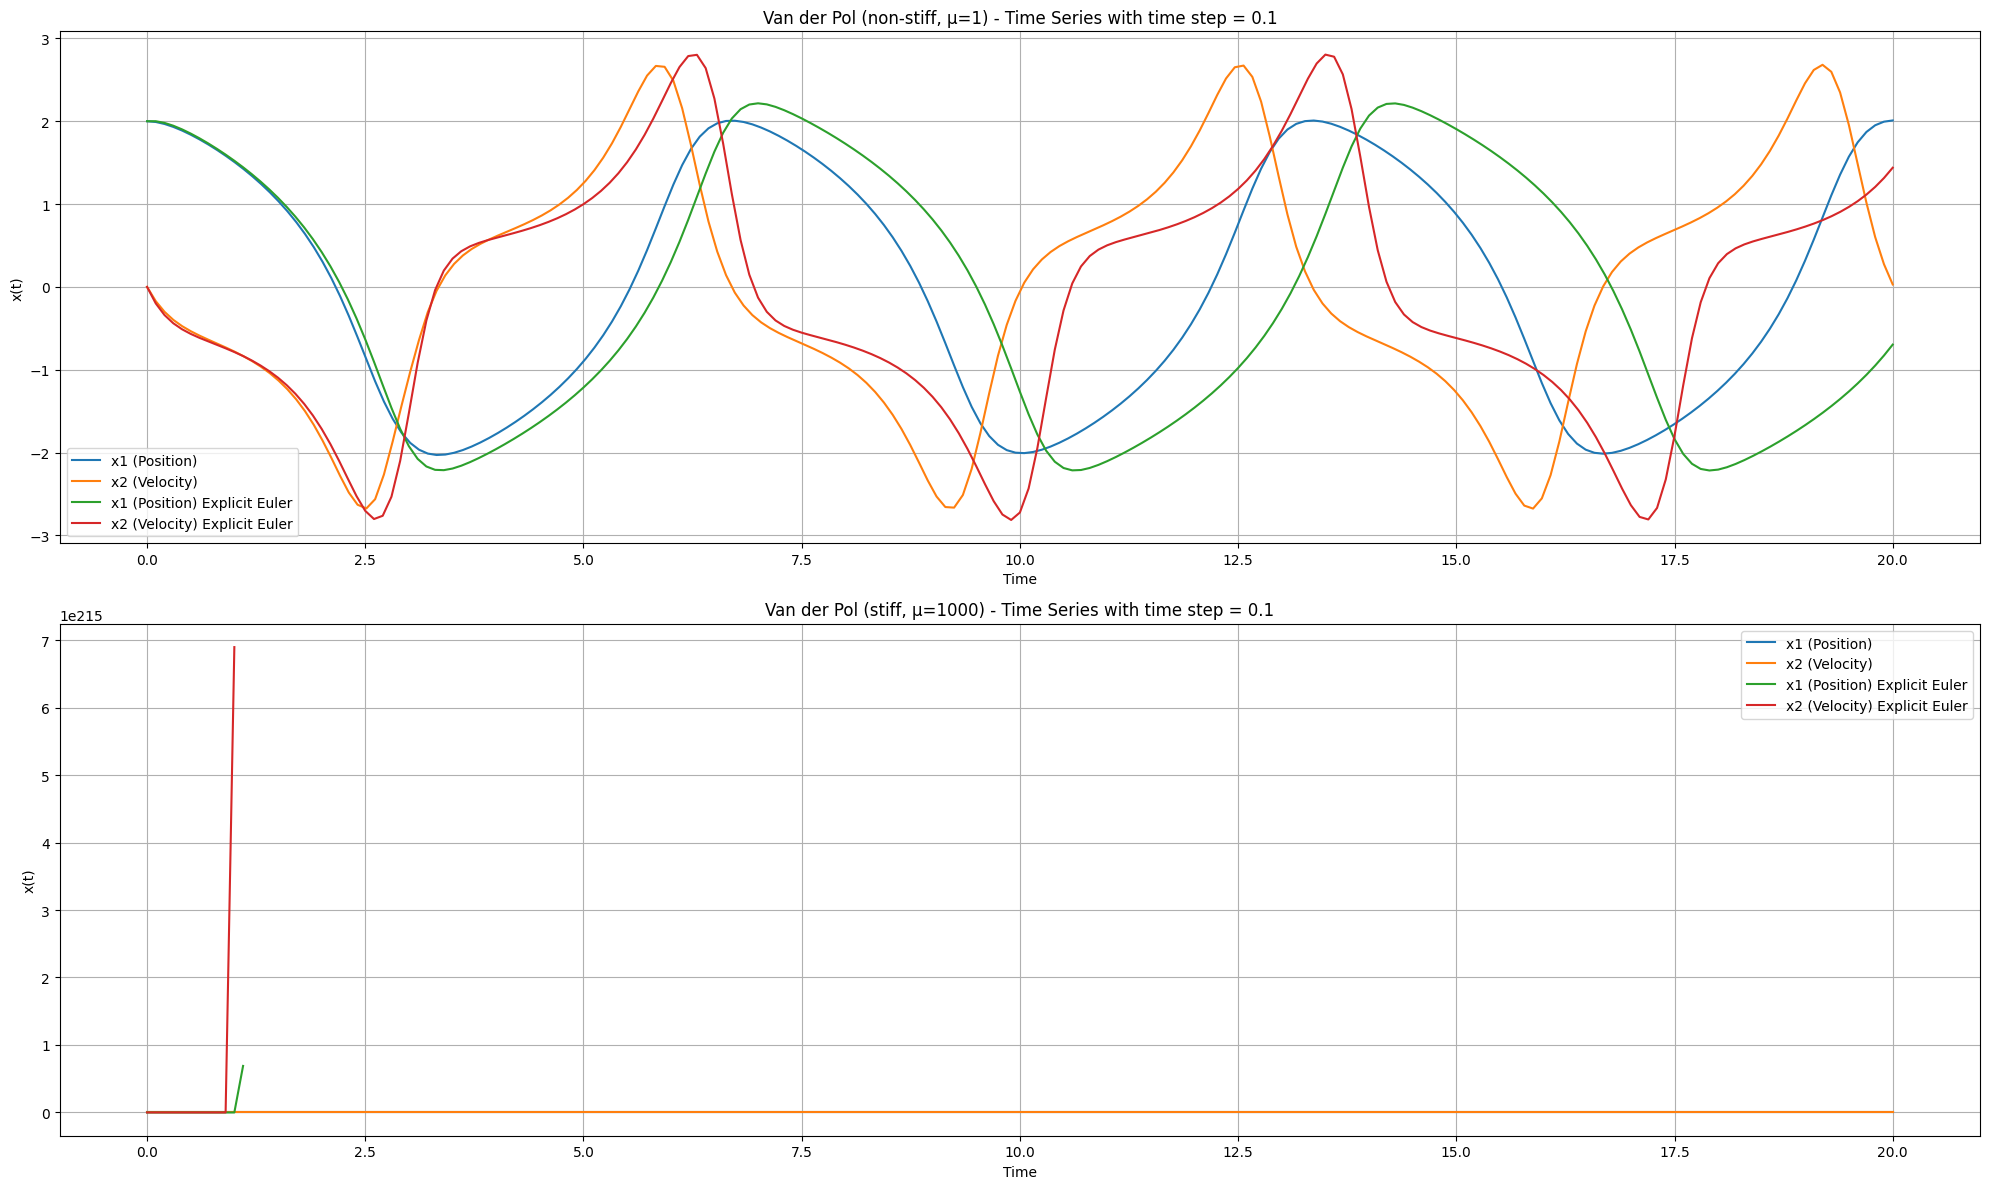

In [ ]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
N = 200


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_nonstiff_t, solution_fixed_nonstiff_x = ExplicitEulerFixedSteps(f_nonstiff, t_span[0], t_span[1], N, x0)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_stiff_t, solution_fixed_stiff_x = ExplicitEulerFixedSteps(f_stiff, t_span[0], t_span[1], N, x0)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with time step = 0.1')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with time step = 0.1')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#### Explicit Euler with fixed step size = 0.01

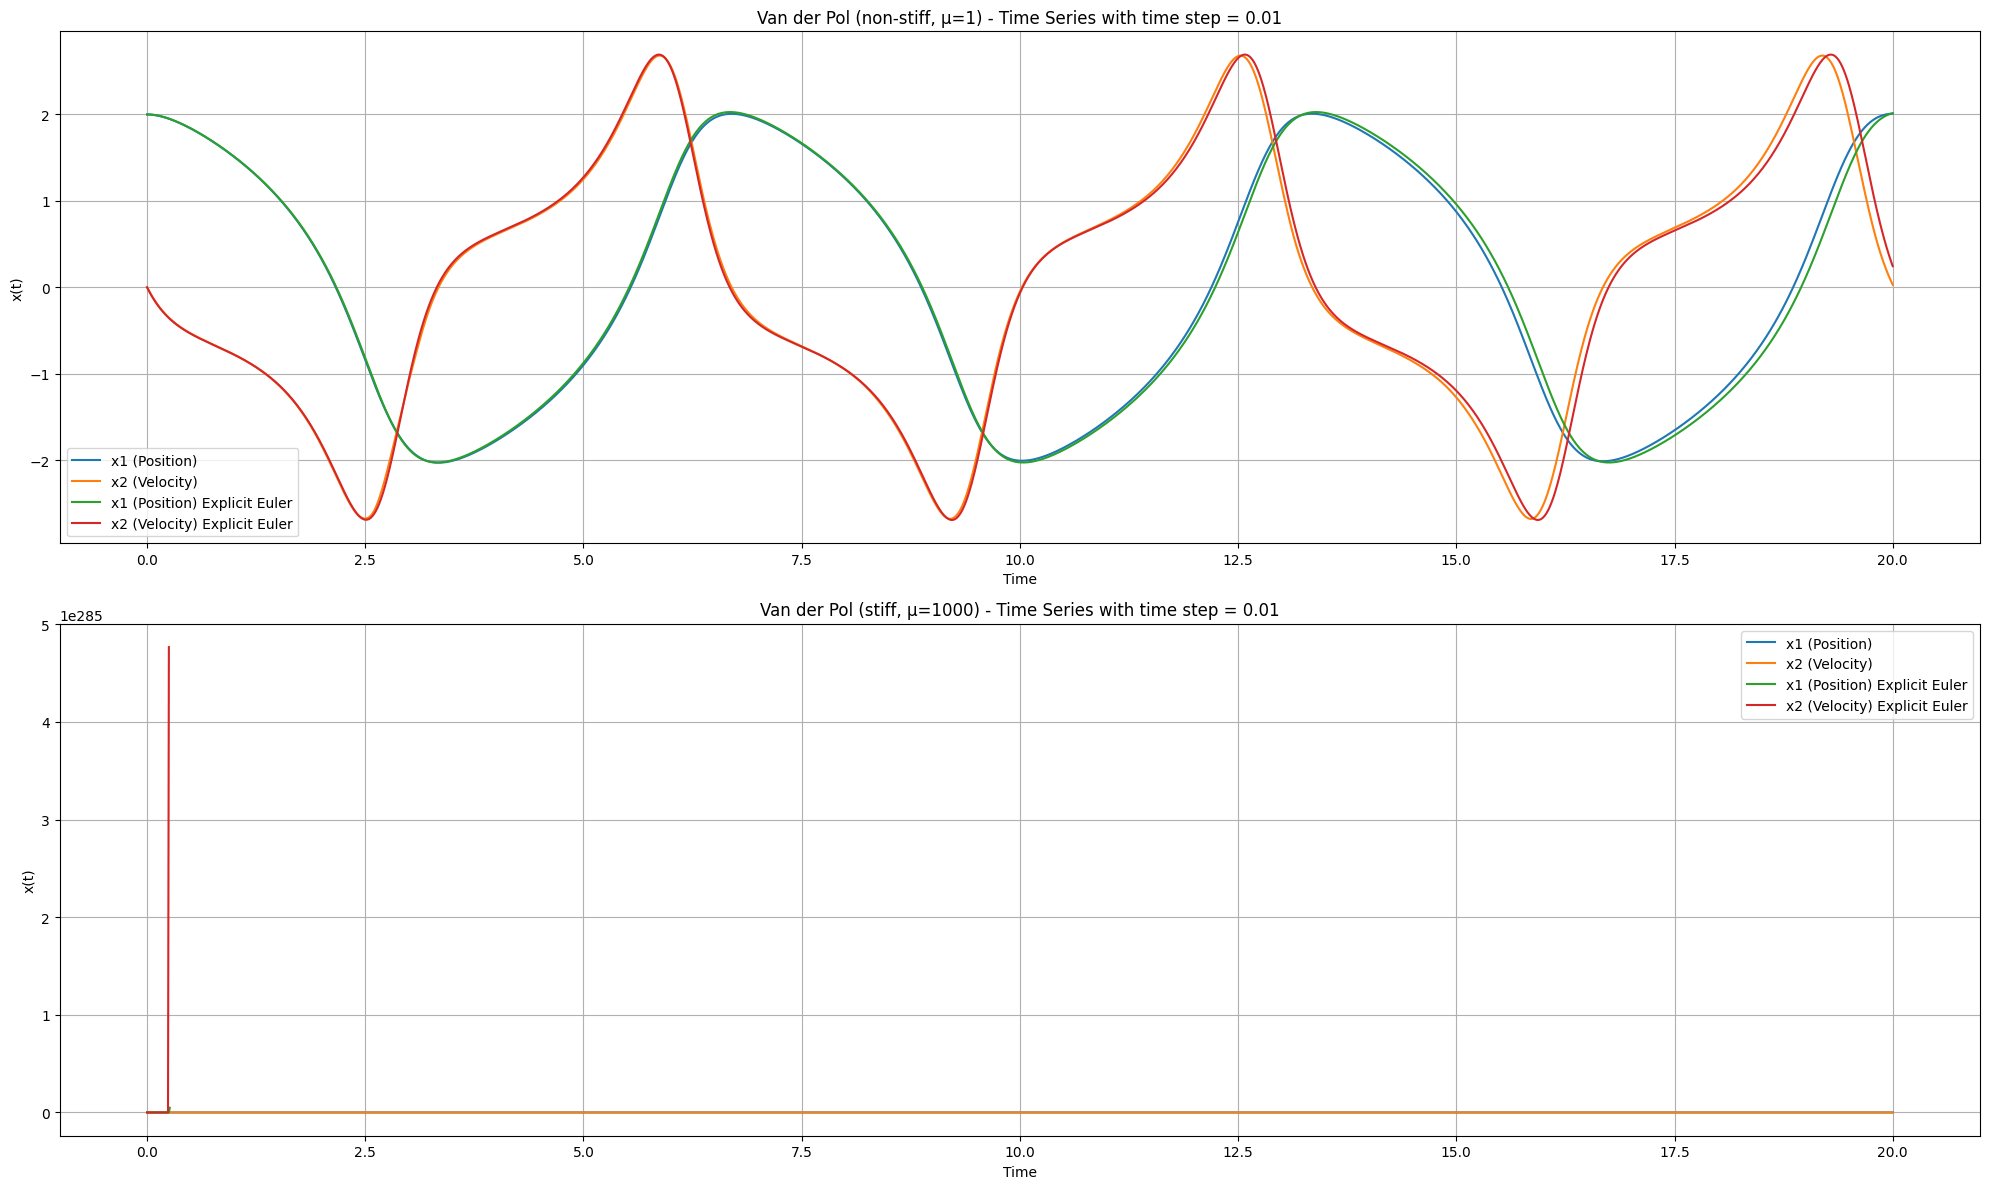

In [ ]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
N = 2000


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_nonstiff_t, solution_fixed_nonstiff_x = ExplicitEulerFixedSteps(f_nonstiff, t_span[0], t_span[1], N, x0)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_stiff_t, solution_fixed_stiff_x = ExplicitEulerFixedSteps(f_stiff, t_span[0], t_span[1], N, x0)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with time step = 0.01')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with time step = 0.01')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#### Explicit Euler with adaptive time step and tolerance 10^-6

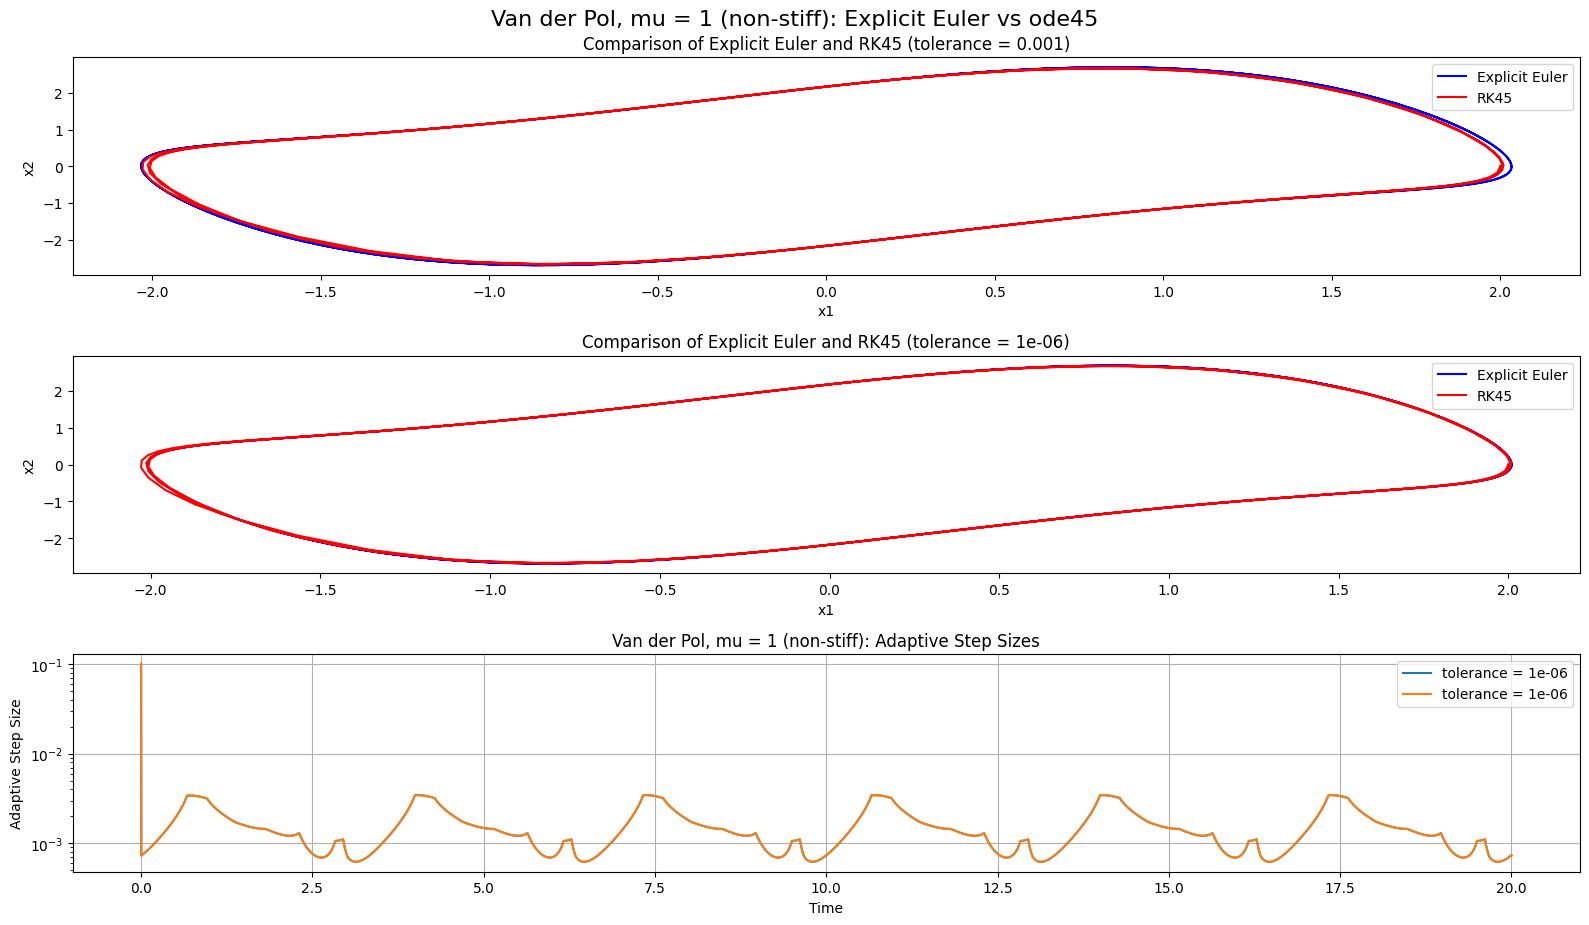

In [ ]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

results_nonstiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_nonstiff], model_name = "Van der Pol, mu = 1 (non-stiff)", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True)

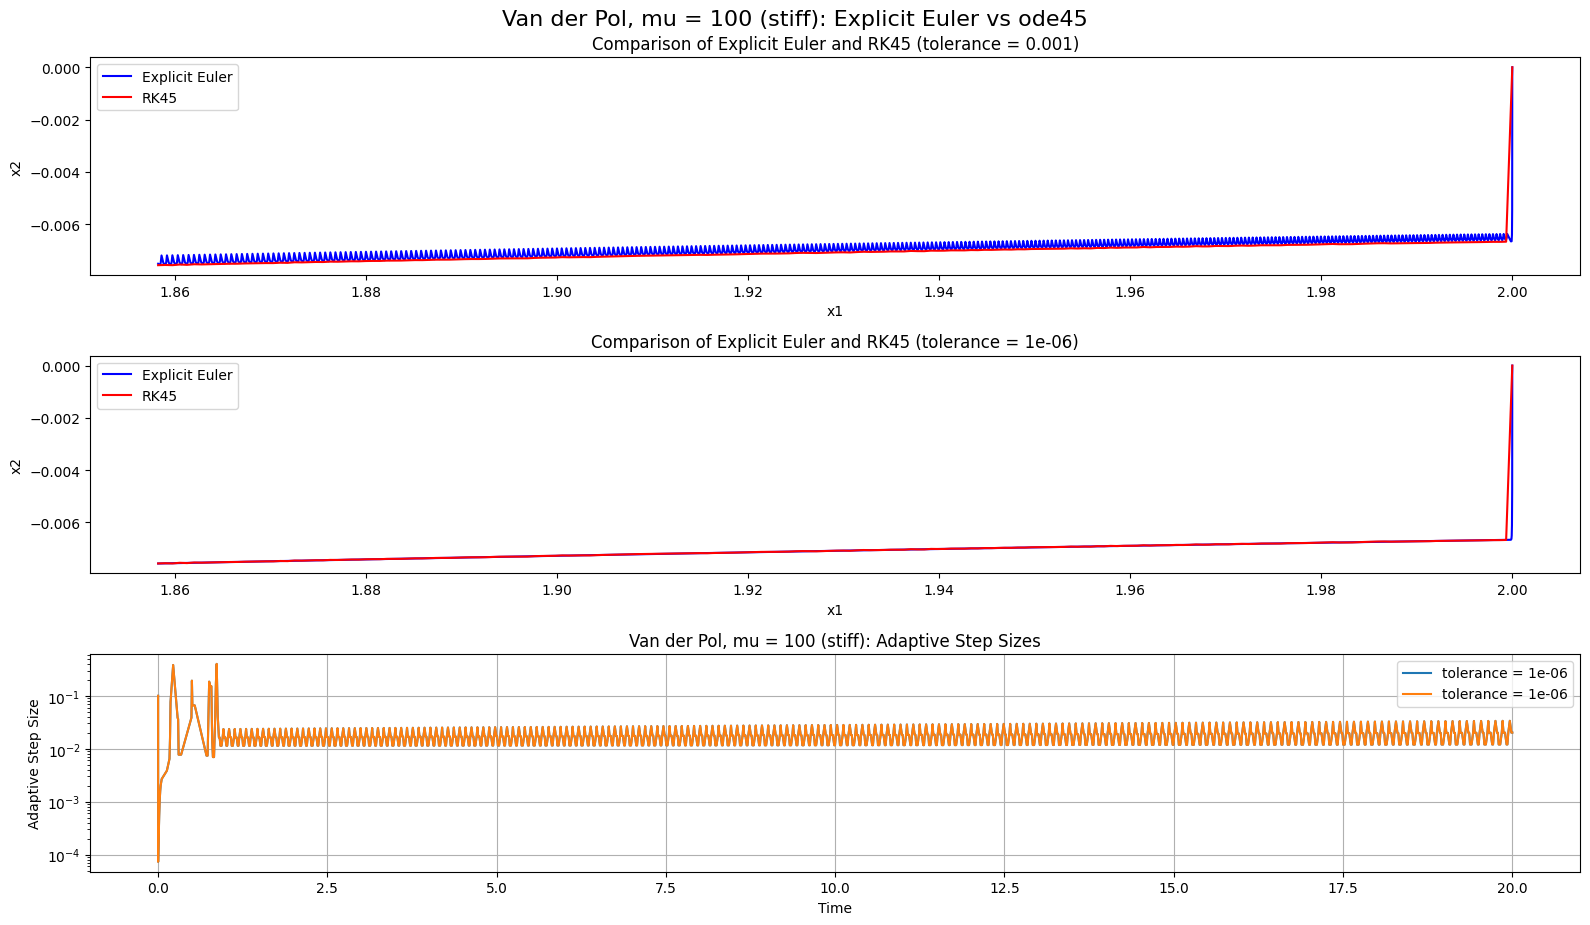

In [ ]:
results_stiff = compare_solvers(van_der_pol_model, t_span, x0, params = [mu_stiff], model_name = "Van der Pol, mu = 100 (stiff)", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True)

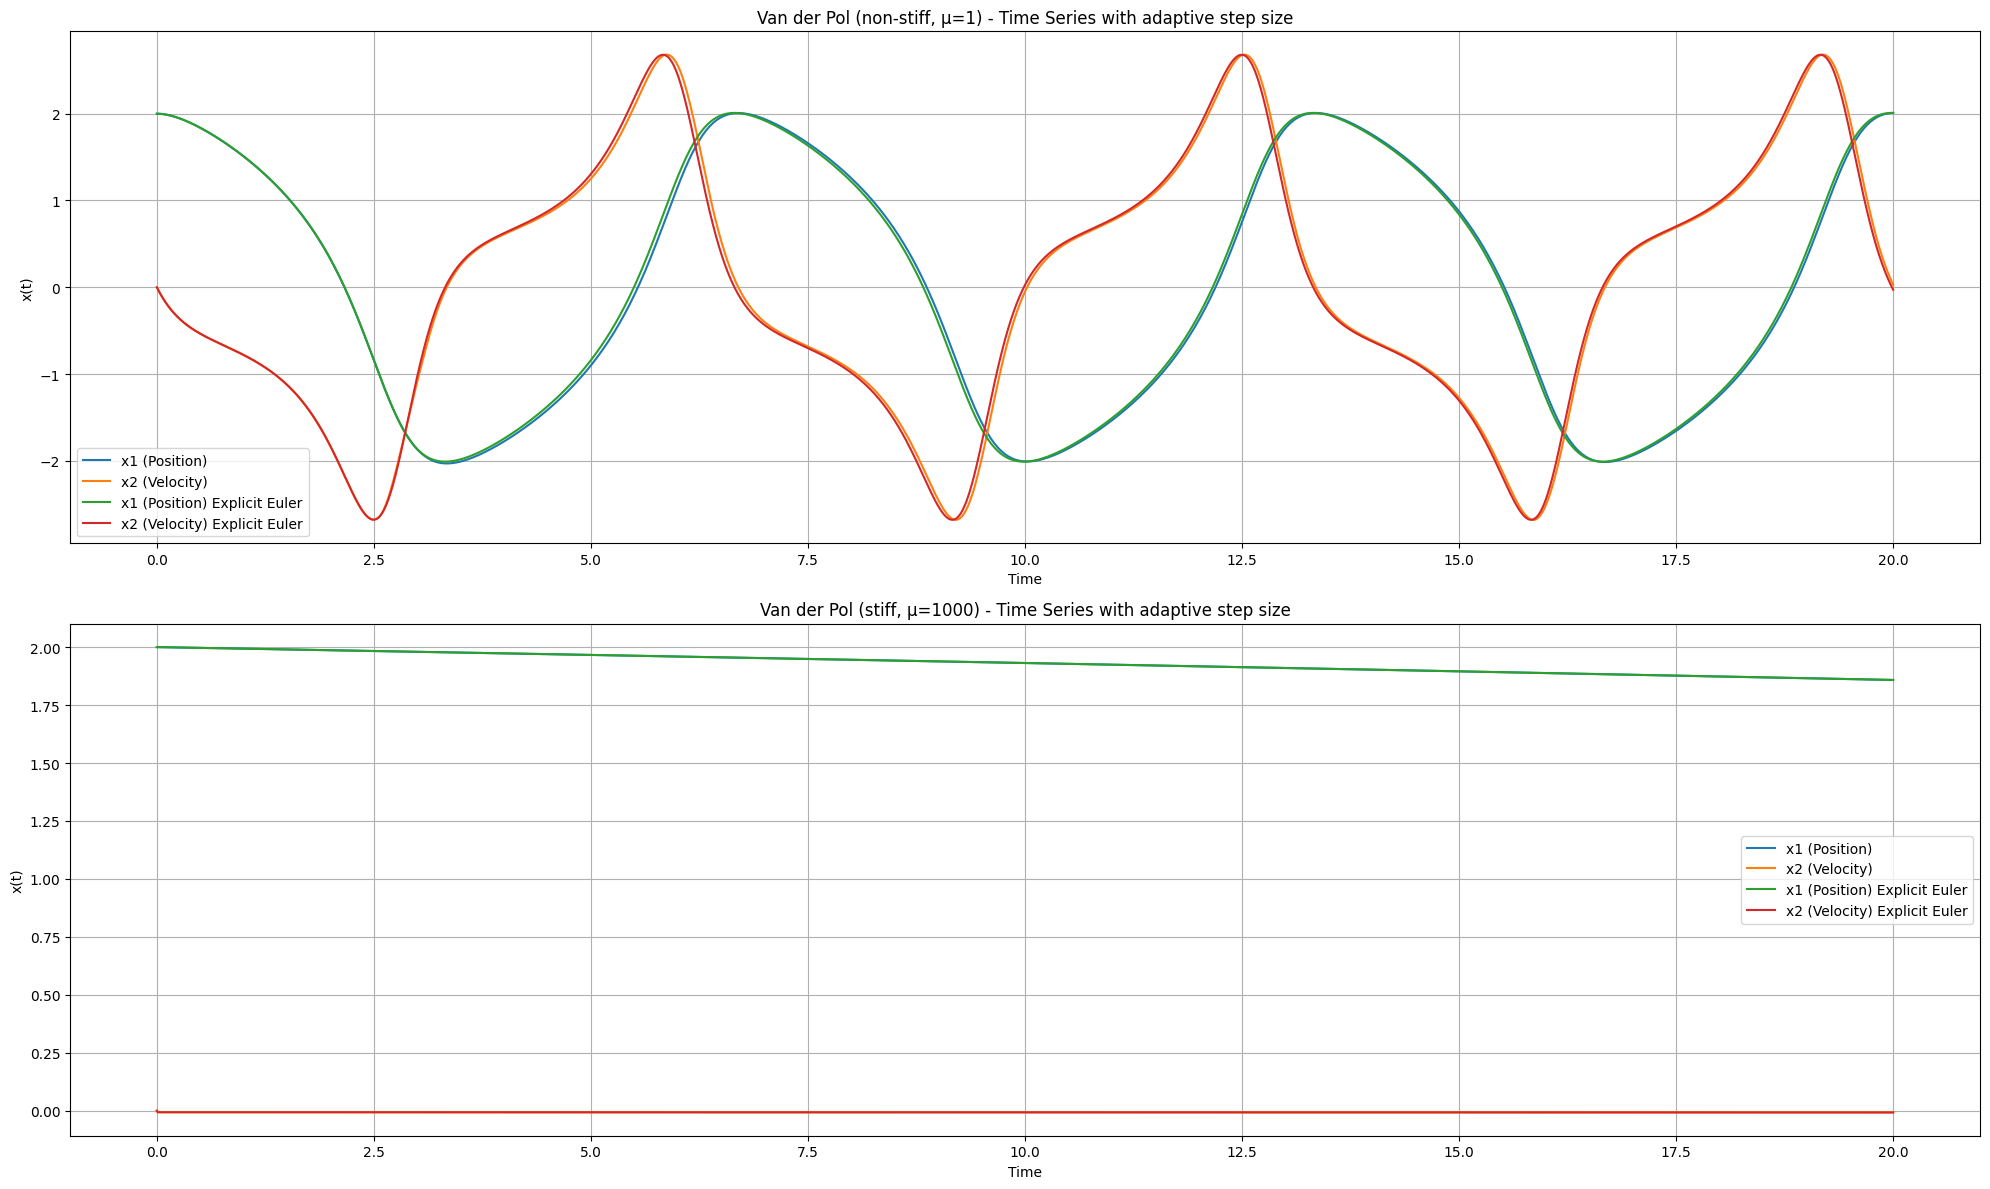

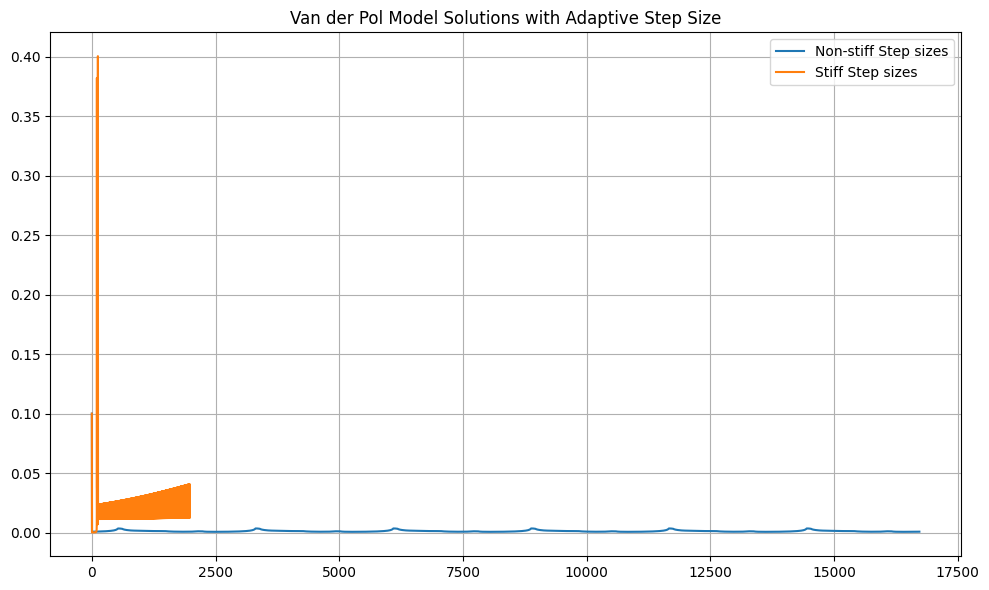

In [ ]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x, solution_adaptive_nonstiff_h = ExplicitEulerAdaptiveStep(f_nonstiff, t_span, x0, h0, abs_tol, rel_tol)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_stiff_t, solution_adaptive_stiff_x, solution_adaptive_stiff_h = ExplicitEulerAdaptiveStep(f_stiff, t_span, x0, h0, abs_tol, rel_tol)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()


#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_nonstiff_h, label = 'Non-stiff Step sizes')
plt.plot(solution_adaptive_stiff_h, label = 'Stiff Step sizes')
plt.title('Van der Pol Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-3

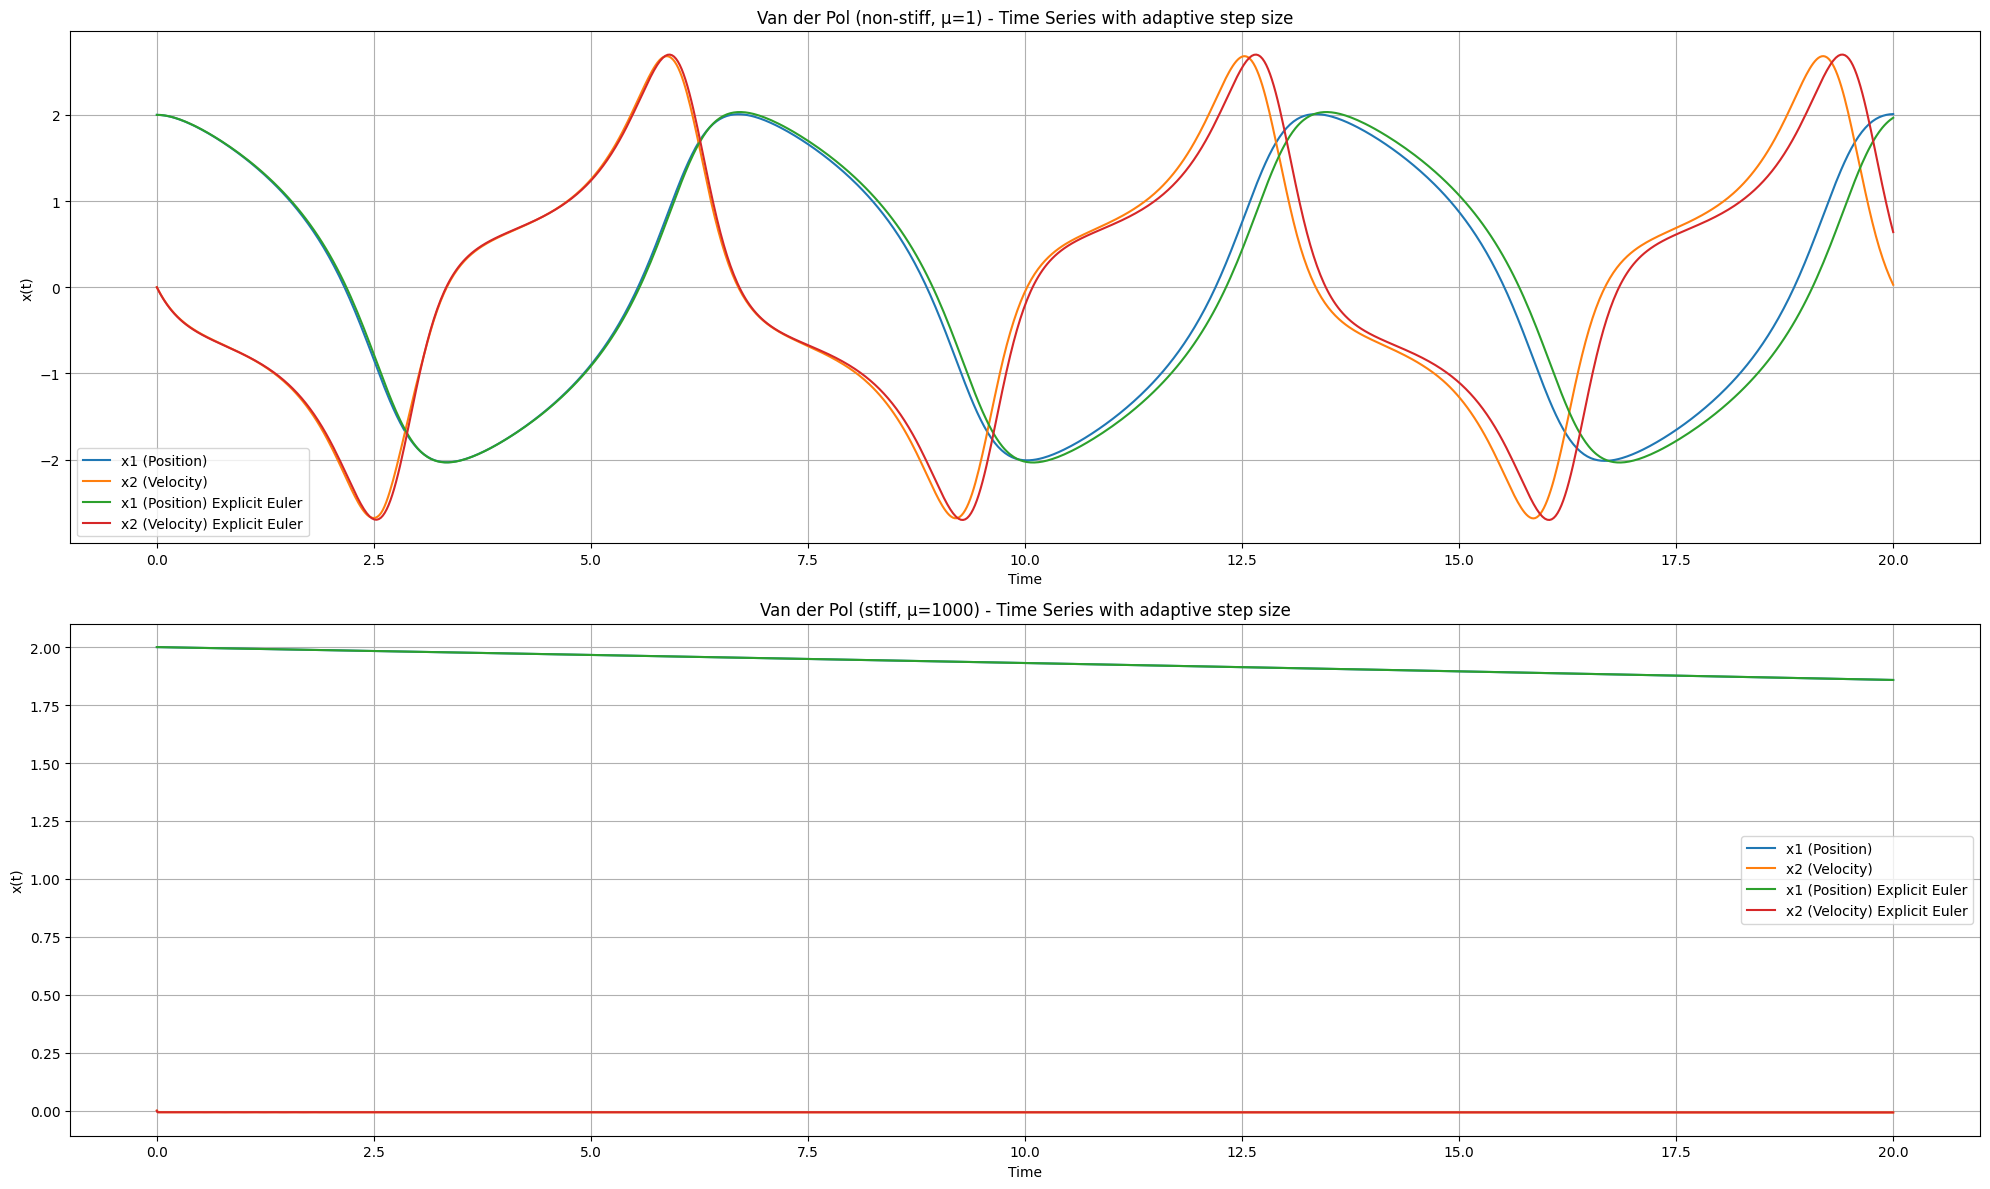

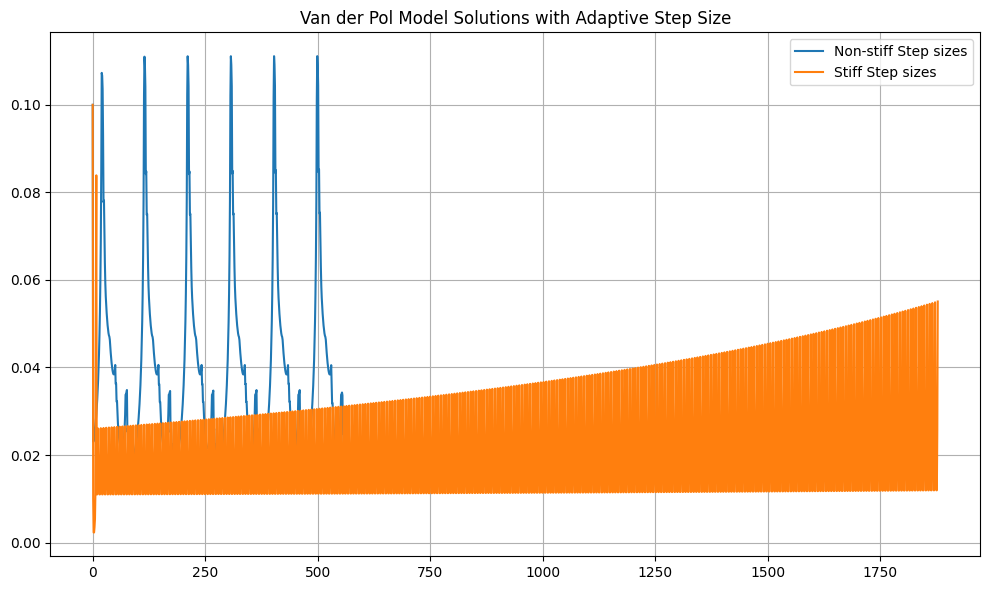

In [ ]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x, solution_adaptive_nonstiff_h = ExplicitEulerAdaptiveStep(f_nonstiff, t_span, x0, h0, abs_tol, rel_tol)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_stiff_t, solution_adaptive_stiff_x, solution_adaptive_stiff_h = ExplicitEulerAdaptiveStep(f_stiff, t_span, x0, h0, abs_tol, rel_tol)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_nonstiff_h, label = 'Non-stiff Step sizes')
plt.plot(solution_adaptive_stiff_h, label = 'Stiff Step sizes')
plt.title('Van der Pol Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### CSTR (3 state model)

#### Explicit Euler with fixed step size = 0.1

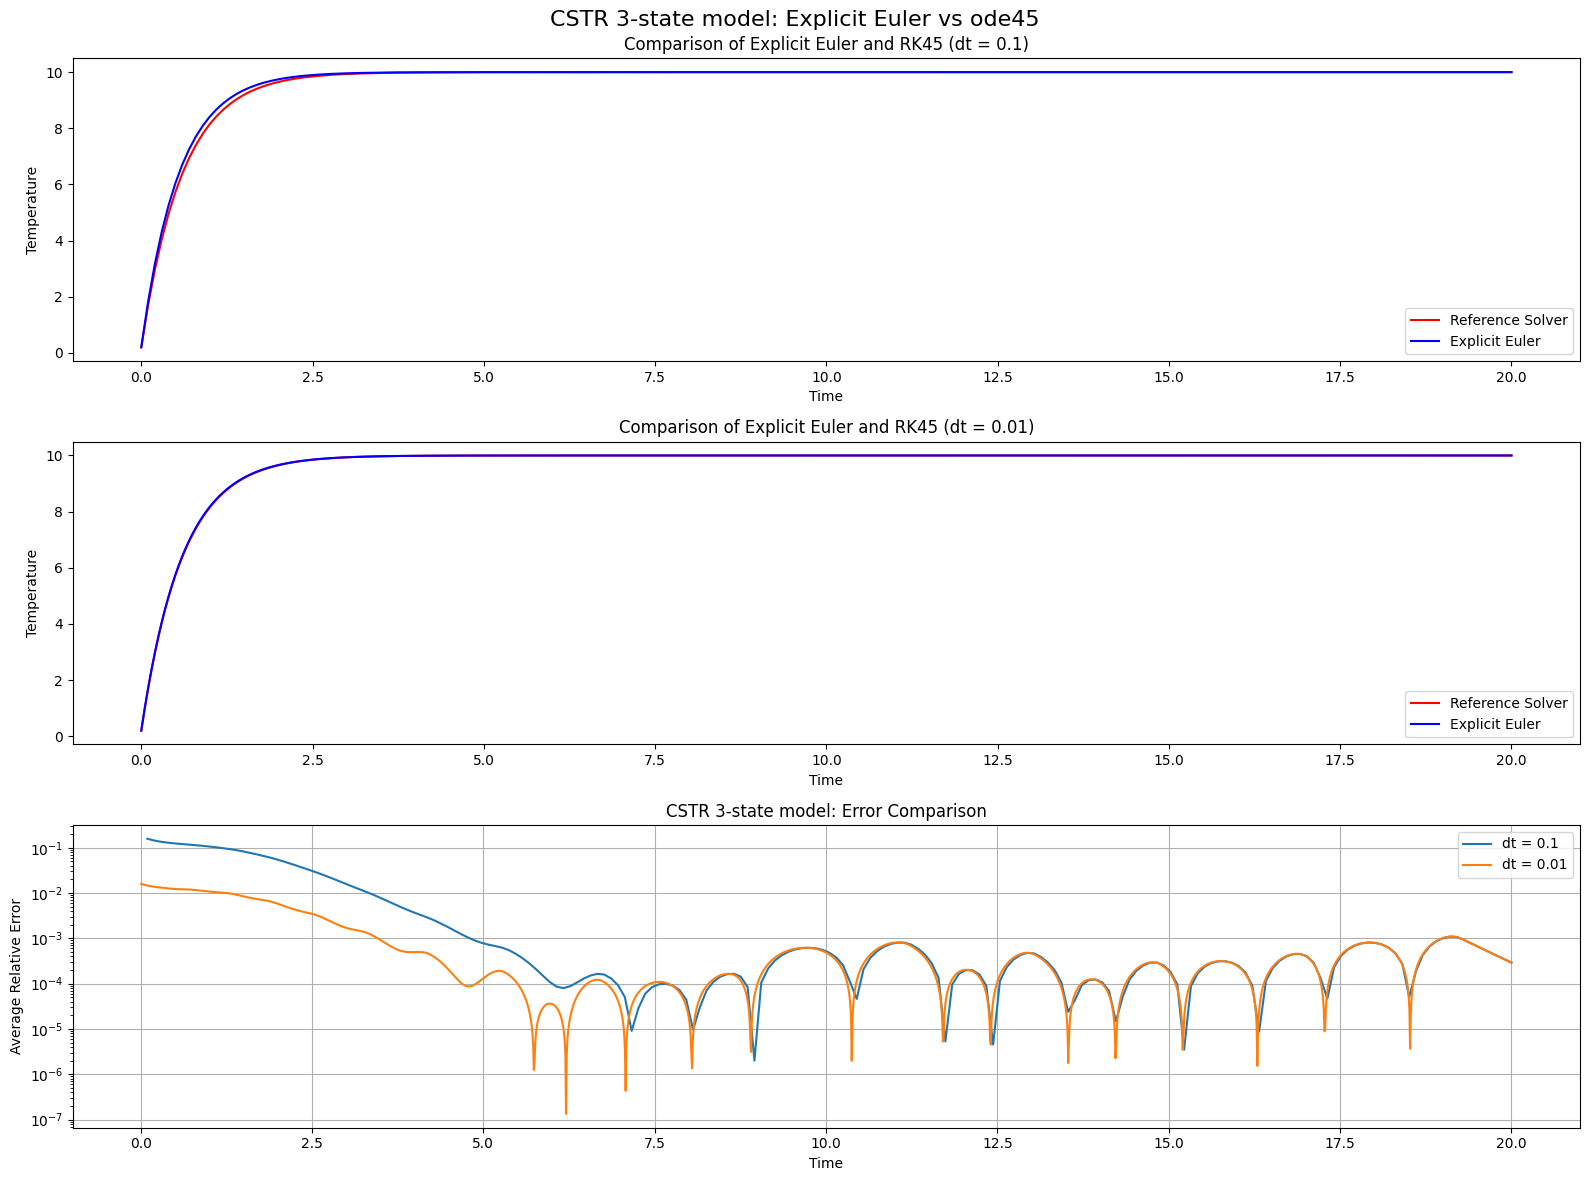

{0.1: {'ref_sol':   message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-01 ...  1.990e+01  2.000e+01]
          y: [[ 1.000e+00  8.618e-01 ...  1.001e-01  1.001e-01]
              [ 5.000e-01  5.768e-01 ...  1.000e+00  1.000e+00]
              [ 2.000e-01  1.705e+00 ...  9.999e+00  9.999e+00]]
        sol: None
   t_events: None
   y_events: None
       nfev: 110
       njev: 0
        nlu: 0,
  'euler_t': array([ 0.        ,  0.09950249,  0.19900498,  0.29850746,  0.39800995,
          0.49751244,  0.59701493,  0.69651741,  0.7960199 ,  0.89552239,
          0.99502488,  1.09452736,  1.19402985,  1.29353234,  1.39303483,
          1.49253731,  1.5920398 ,  1.69154229,  1.79104478,  1.89054726,
          1.99004975,  2.08955224,  2.18905473,  2.28855721,  2.3880597 ,
          2.48756219,  2.58706468,  2.68656716,  2.78606965,  2.88557214,
          2.98507463,  3.08457711,  3.1840796 ,  3.28358

In [ ]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0, 0.5, 0.2])  # Initial conditions for CSTR model

compare_solvers(CSTR_3state_model, t_span, x0, params = [params], model_name = "CSTR 3-state model", reference_solver_name="ode45", time_series=True)

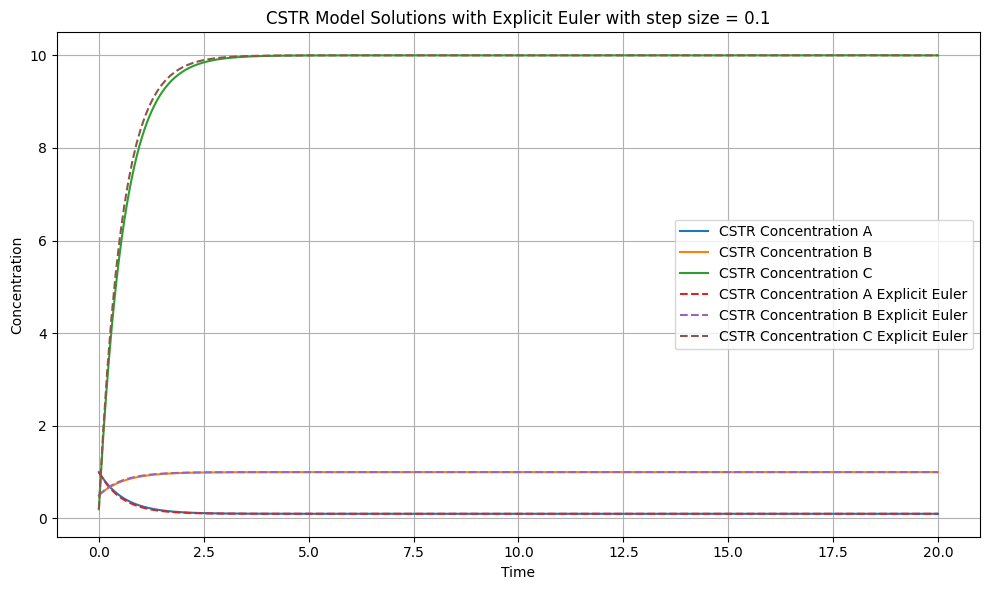

In [ ]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0, 0.5, 0.2])  # Initial conditions for CSTR model

#Solver parameters
N = 200

f, _ = CSTR_3state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B') 
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with fixed step size = 0.01

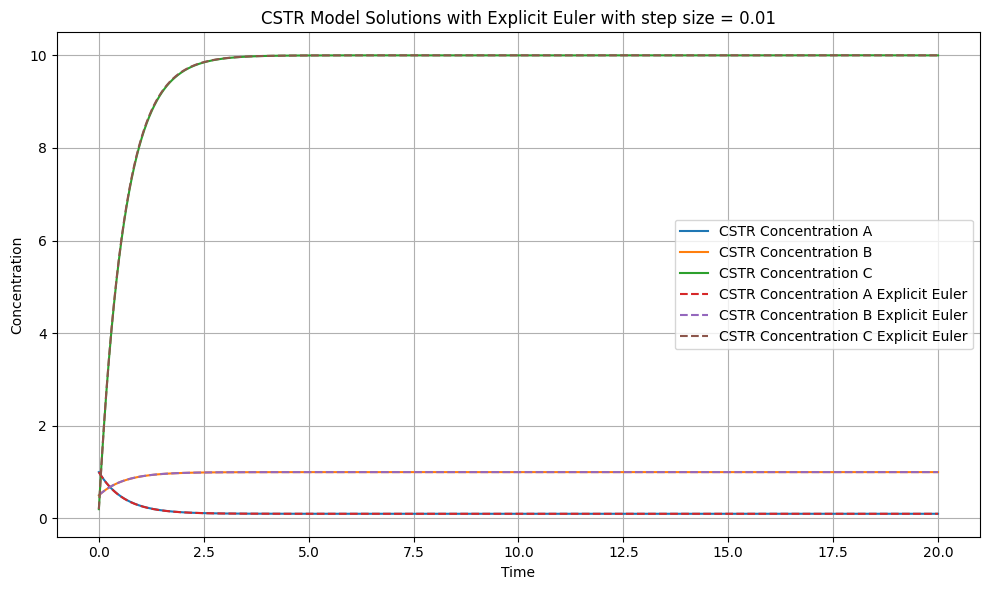

In [ ]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0, 0.5, 0.2])  # Initial conditions for CSTR model

#Solver parameters
N = 2000

f, _ = CSTR_3state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B') 
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with step size = 0.01')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step with tolerance 10^-6

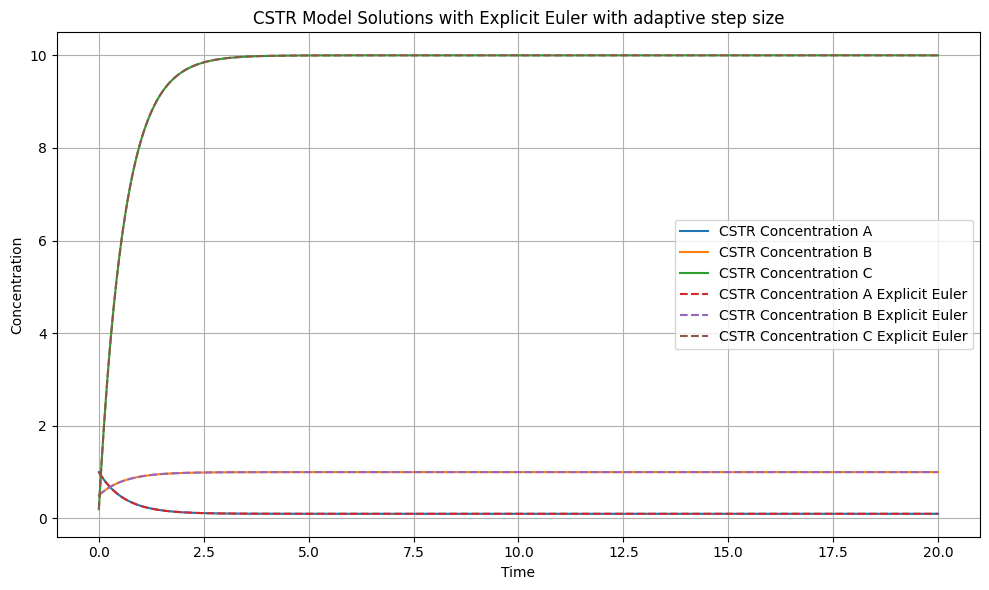

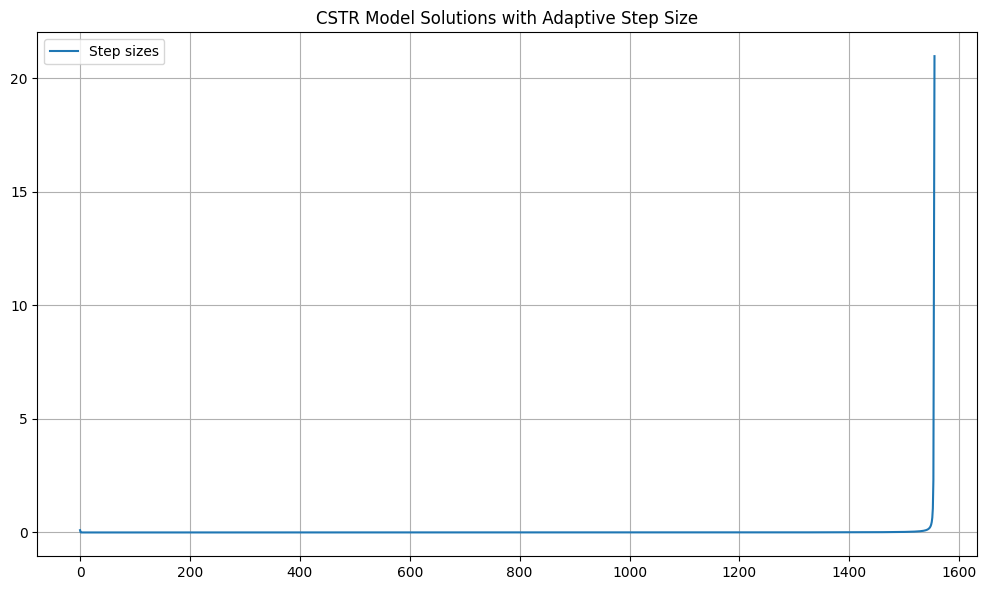

In [ ]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B')
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step with tolerance 10^-3

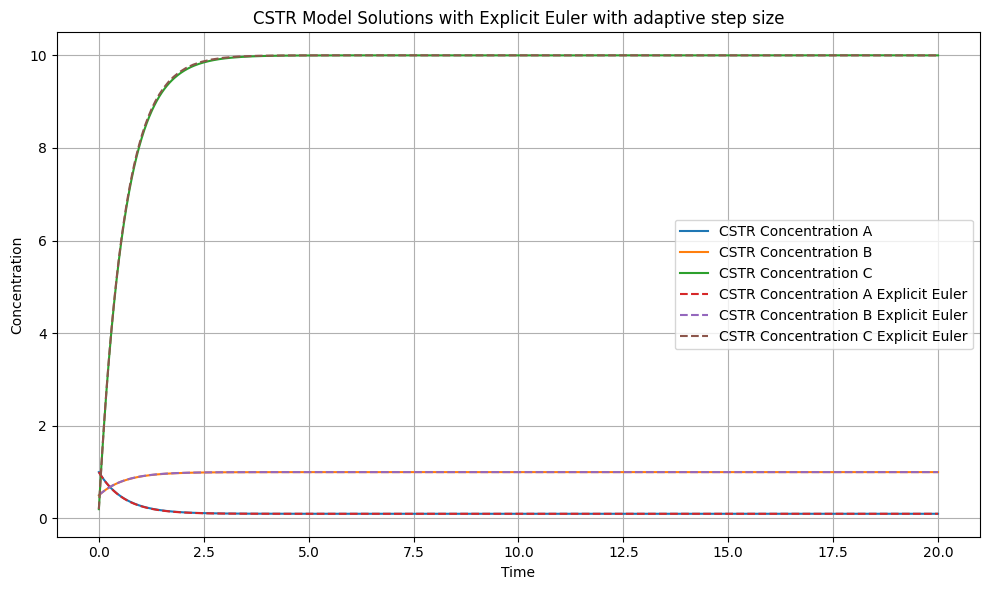

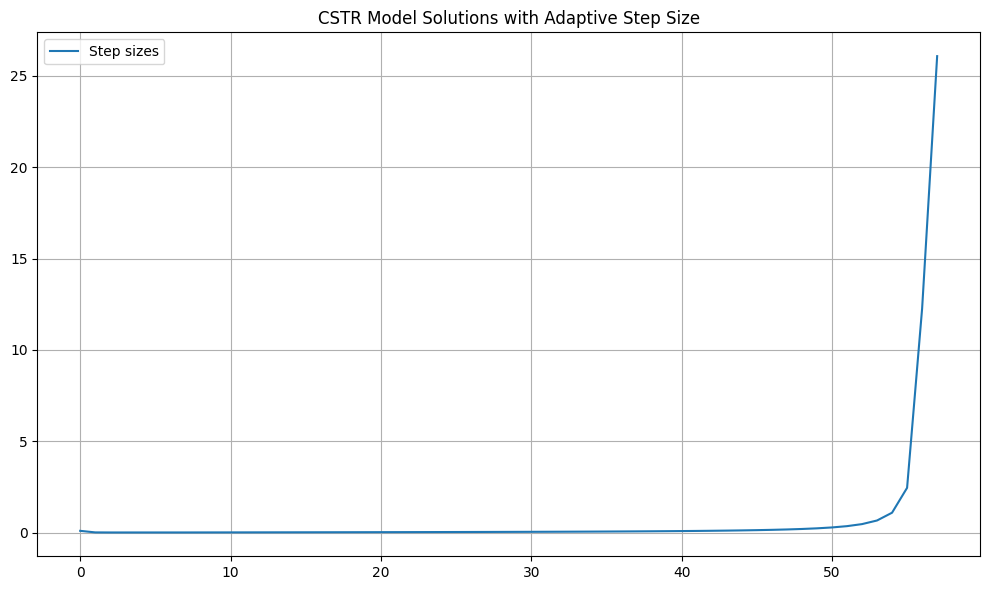

In [ ]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B')
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### CSTR (1 state model)

#### Explicit Euler with fixed step size = 0.1

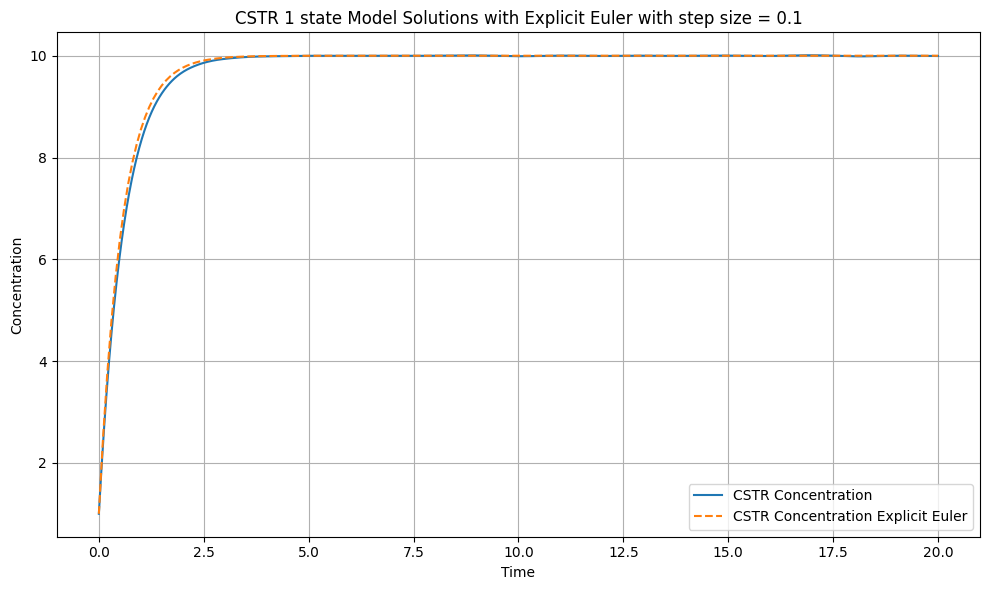

In [ ]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0])  # Initial conditions for CSTR model

#Solver parameters
N = 200

f, _ = CSTR_1state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR 1 state Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with fixed step size = 0.01

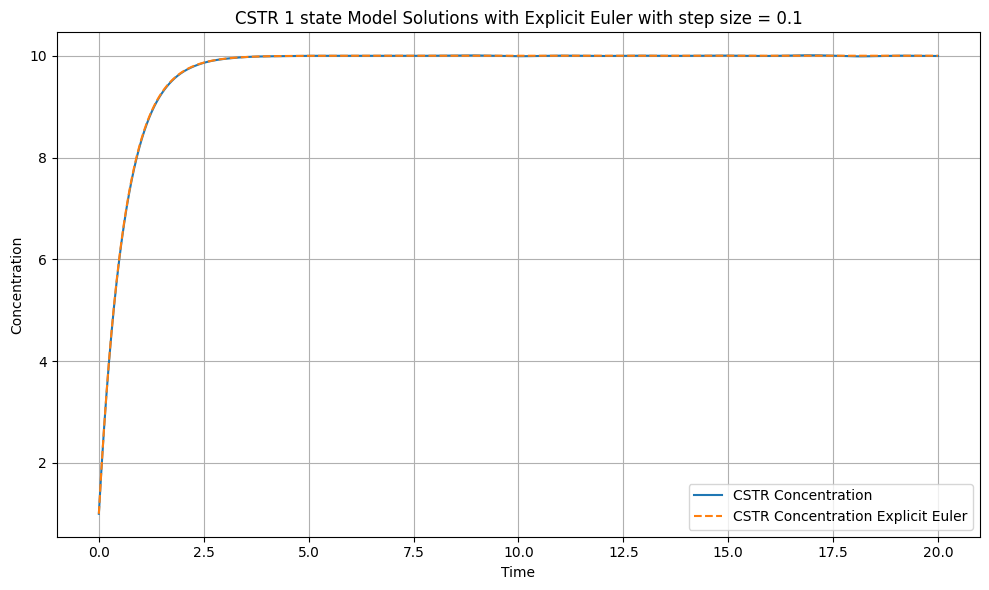

In [ ]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0])  # Initial conditions for CSTR model

#Solver parameters
N = 2000

f, _ = CSTR_1state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR 1 state Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-6

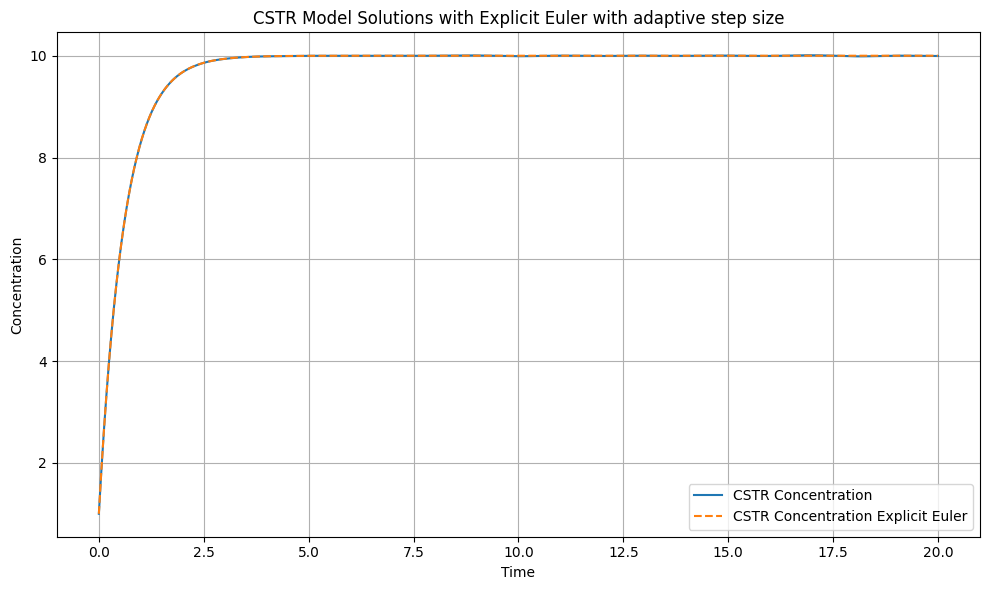

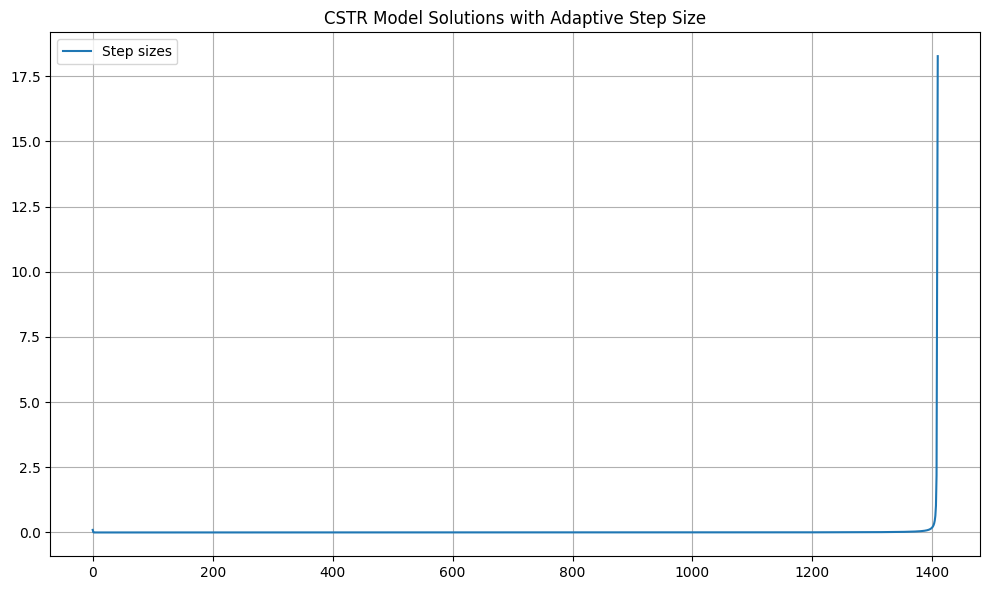

In [ ]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-3

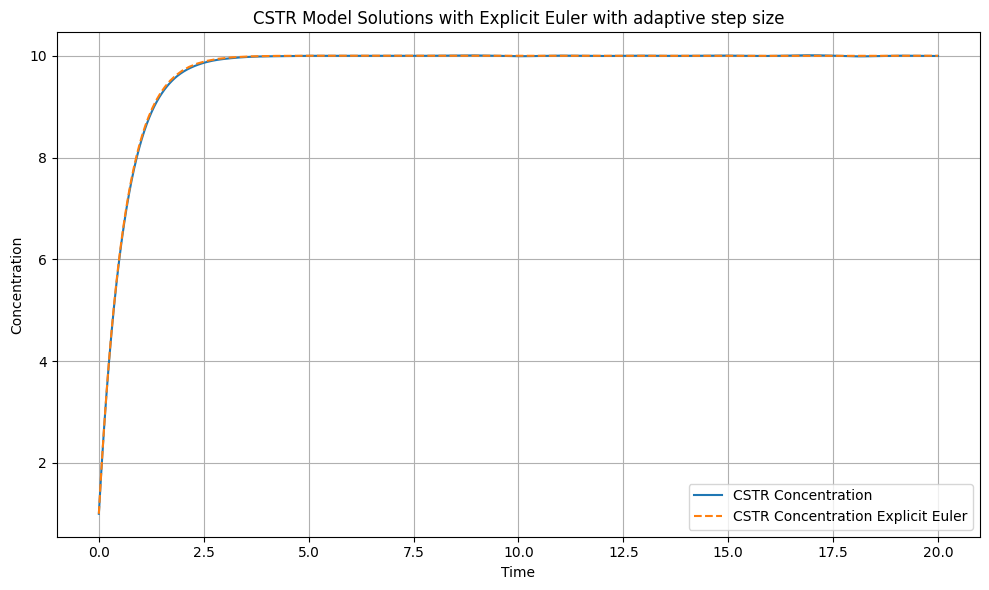

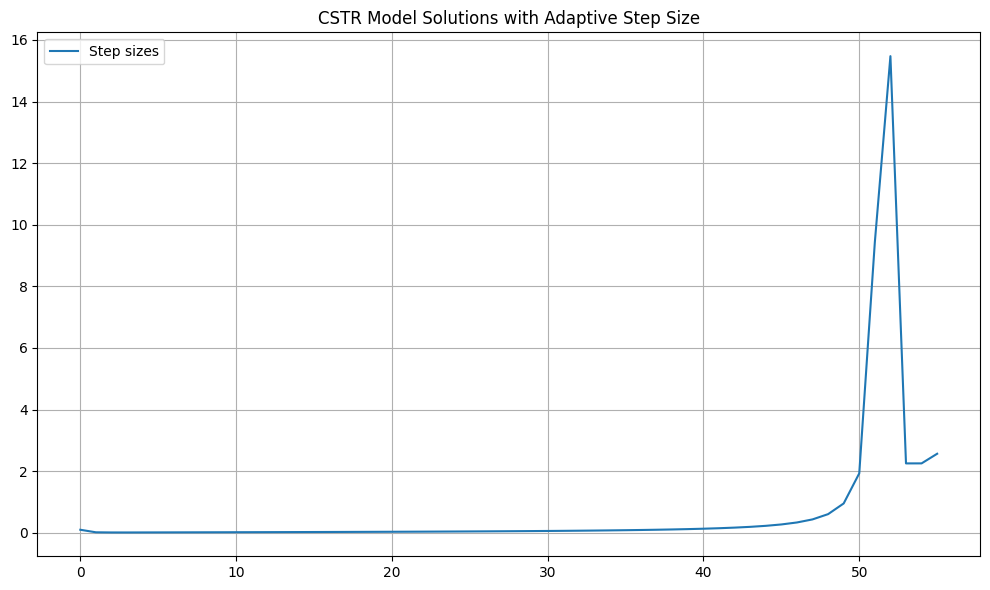

In [ ]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()